### Libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.integrate import simps
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn import metrics
from tqdm import tqdm, trange
import datetime
import xgboost as xgb
import multiprocessing
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from joblib import dump, load

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
    'axes.linewidth':2.0,
})

# Important lists
lig = 'lignin'
features = ['A-A', 'B-B', 'A-B', 'A-A/B-B', 'A-A/(A-A + B-B)']
features_merged = ['A-A_n', 'B-B_n', 'A-B_n', 'A-A_n/B-B_n', 'A-B_n/(A-A_n + B-B_n)',
                   'A-A_l', 'B-B_l', 'A-B_l', 'A-A_l/B-B_l',
                   'A-B_l/(A-A_l + B-B_l)']

### DES and non-DES hbond lifetimes
Creation and cleaning up of dataframes. These cells take in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B lifetimes in a pandas dataframe. The dataframe can be stored as a csv for later use.


### Lignin DES

In [2]:
#DES
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B lifetimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hlife_dict_lignin = {}

for folderz in pathway.glob('./desfiles-irc/des/*'):
    # print(folderz.stem)
    dict_key = folderz.stem  #[6:]
    hlife_list = []
    for file in pathway.glob(f"{folderz}/hbond-*"):
        # print(file)
        if len(os.listdir(file)) < 5:
            hlife_list.append(0)
            continue

        for txt in pathway.glob(f"{file}/hlife*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            x = data[0]/1000
            y = data[2]
            area = 0
            # Change dx to 1 for files prior to 7 Sep 2020
            area = simps(y, dx=0.01)
            hlife_list.append(area)
            # print("The area of {thing} is {val}".format(thing= txt.stem, val=area))
            # print("\n")

    hlife_dict_lignin[f"{dict_key}"] = hlife_list
    # print(hlife_dict_lignin)
    # print("\n")

DES = []
AA = []
AB = []
BB = []

for i in list(hlife_dict_lignin.items()):
    # print(i)
    DES.append(i[0])
    AA.append(i[1][0])
    AB.append(i[1][1])
    BB.append(i[1][2])

des_dict = {
    "DES": DES,
    "A-A": AA,
    "A-B": AB,
    "B-B": BB
}
des_hlife_frame_lignin = pd.DataFrame(des_dict, columns=["DES", "A-A", "B-B", "A-B"])
aa_dlife_lignin = des_hlife_frame_lignin['A-A']
ab_dlife_lignin = des_hlife_frame_lignin['A-B']
bb_dlife_lignin = des_hlife_frame_lignin['B-B']
des_hlife_frame_lignin['A-A/B-B'] = aa_dlife_lignin/bb_dlife_lignin
# des_hlife_frame_lignin['BB/AA'] = bb_dlife_lignin/aa_dlife_lignin
des_hlife_frame_lignin['A-B/(A-A + B-B)'] = ab_dlife_lignin/(aa_dlife_lignin + bb_dlife_lignin)
des_hlife_frame_lignin.describe()


,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,2.142763,1.160553,2.143439,2.322637,0.642668
std,1.122938,0.842266,1.168480,1.502644,0.183063
min,0.232701,0.206614,0.256956,0.661939,0.376253
25%,1.274320,0.512612,1.067480,1.196781,0.515790
50%,2.469649,0.963793,2.158384,1.945579,0.585537
75%,2.747975,1.752335,3.068056,2.910829,0.730091
max,3.859475,3.733872,4.013772,7.043183,1.146823


In [3]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
des_hlife_lignin = des_hlife_frame_lignin[(des_hlife_frame_lignin['B-B'] > 0.0)]
des_hlife_lignin.reset_index(drop=True, inplace=True)

In [138]:
# des_hlife_lignin.describe().to_excel('./csv-files/lignin/des_lignin_hlife_summary.xlsx')
# des_hlife_lignin.to_excel('./csv-files/lignin/des_lignin_hlife.xlsx')

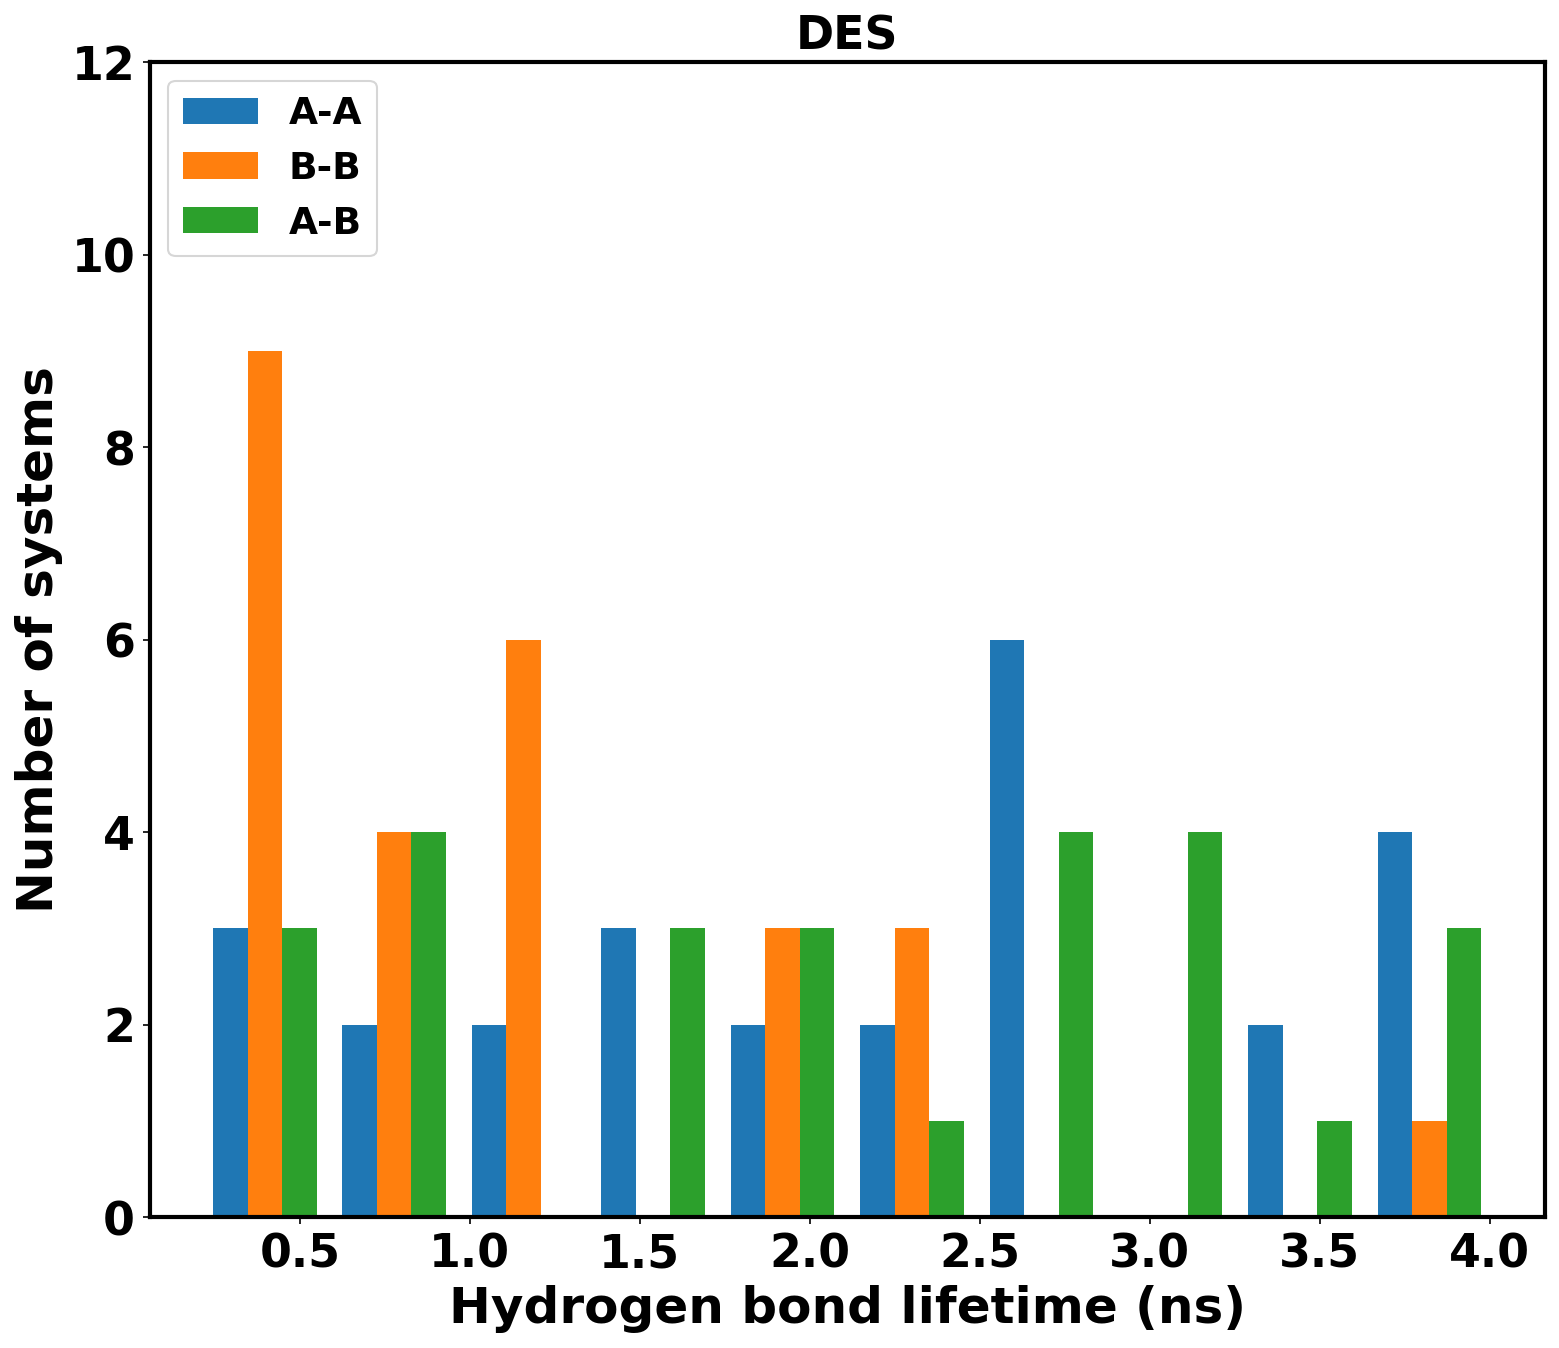

In [4]:
# DES non-overlapping histogram
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
des_fig_lignin = plt.figure()
des_fig_lignin.set_size_inches(12, 10, forward=True)
des_ax_lignin = des_fig_lignin.add_subplot(1,1,1)
des_ax_lignin.set_xlabel("Hydrogen bond lifetime (ns)", fontsize=24, weight='bold')
des_ax_lignin.set_ylabel("Number of systems", fontsize=24, weight='bold')
ytick = np.arange(0,24, 2)
xtick = np.arange(0,5.5, 0.5)
plt.yticks(ytick,fontsize=22, weight='bold')
plt.xticks(xtick,fontsize=22, weight='bold')
plt.title('DES', fontsize=22, weight='bold')
plt.ylim([0,12])
# des_hist = des_slice[['A-A', 'B-B', 'A-B']]
# des_hist.plot.hist(bins=20, alpha=0.5, ylim=[0,16], ax=des_ax_lignin)
# binss = np.linspace(0.09871825, 4.54204605, 10)
# binss = np.linspace(0.0, 4.0, 10)
plt.hist([des_hlife_frame_lignin['A-A'], des_hlife_frame_lignin['B-B'], des_hlife_frame_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
# plt.hist([des_slice['A-A'], des_slice['B-B'], des_slice['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
plt.legend(loc='upper left')
# des_fig_lignin.savefig(f'plots/des_hlife_frame_lignin_nonoverlap_{xdate}.png', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()


### Lignin non-DES

In [5]:
# NON-DES
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B lifetimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hlife_dict_nondes = {}

for folderz in pathway.glob('./desfiles-irc/nondes/*'):
    # print(folderz.stem)
    dict_key = folderz.stem
    hlife_list = []
    for file in pathway.glob(f"{folderz}/hbond-*-?-?"):
        # print(file)
        if len(os.listdir(file)) < 5:
            hlife_list.append(0)
            continue

        for txt in pathway.glob(f"{file}/hlife*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            x = data[0]/1000
            y = data[2]
            area = 0
            # Change dx to 1 for files prior to 7 Sep 2020
            area = simps(y, dx=0.01)
            hlife_list.append(area)
            # print("The area of {thing} is {val}".format(thing= txt.stem, val=area))
            # print("\n")

    hlife_dict_nondes[f"{dict_key}"] = hlife_list
    # print(hlife_dict_nondes)
    # print("\n")

# print(hlife_dict_nondes)
NONDES = []
AA_ = []
AB_ = []
BB_ = []

for i in list(hlife_dict_nondes.items()):
    # print(i)
    NONDES.append(i[0])
    AA_.append(i[1][0])
    AB_.append(i[1][1])
    BB_.append(i[1][2])

nondes_dict_lignin = {
    "Non-DES": NONDES,
    "A-A": AA_,
    "A-B": AB_,
    "B-B": BB_
}
nondes_hlife_frame_lignin = pd.DataFrame(
    nondes_dict_lignin, columns=["Non-DES", "A-A", "B-B", "A-B"])
aa_nlife_lignin = nondes_hlife_frame_lignin['A-A']
ab_nlife_lignin = nondes_hlife_frame_lignin['A-B']
bb_nlife_lignin = nondes_hlife_frame_lignin['B-B']
nondes_hlife_frame_lignin['A-A/B-B'] = aa_nlife_lignin/bb_nlife_lignin
# nondes_hlife_frame_lignin['BB/AA'] = bb_nlife_lignin/aa_nlife_lignin
nondes_hlife_frame_lignin['A-B/(A-A + B-B)'] = ab_nlife_lignin/(aa_nlife_lignin + bb_nlife_lignin)
# nondes_hlife_frame_lignin


In [6]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
nondes_hlife_lignin = nondes_hlife_frame_lignin[(nondes_hlife_frame_lignin['B-B'] > 0.0)]
nondes_hlife_lignin.reset_index(drop=True, inplace=True)
# nondes_hlife_lignin

In [140]:
# nondes_hlife_lignin.describe().to_excel('./csv-files/lignin/nondes_lignin_hlife_summary.xlsx')
# nondes_hlife_lignin.to_excel('./csv-files/lignin/nondes_lignin_hlife.xlsx')

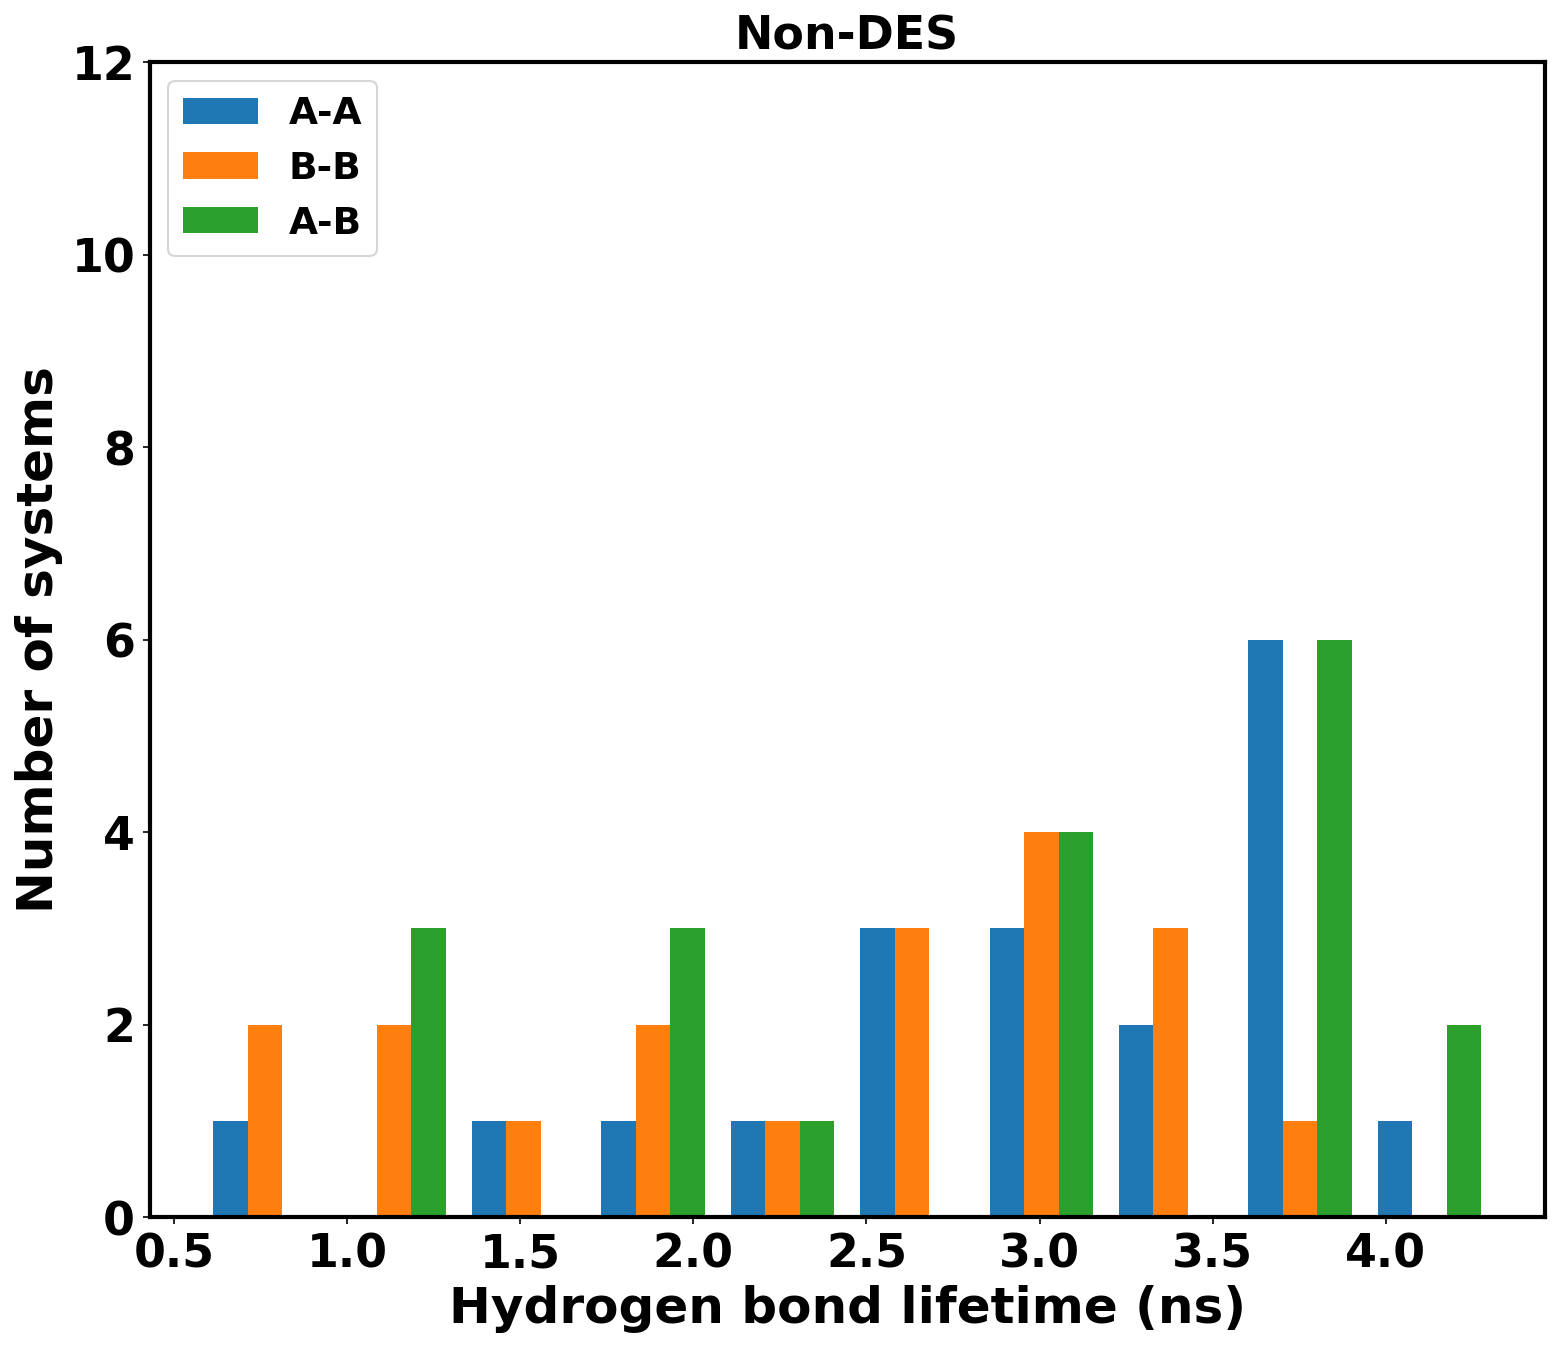

In [7]:
# NON-DES non-overlapping histo 
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
non_des_fig_lignin = plt.figure()
non_des_fig_lignin.set_size_inches(12, 10, forward=True)
non_des_ax_lignin = non_des_fig_lignin.add_subplot(1,1,1)
non_des_ax_lignin.set_xlabel("Hydrogen bond lifetime (ns)", fontsize=24, weight='bold')
non_des_ax_lignin.set_ylabel("Number of systems", fontsize=24, weight='bold')
ytick = np.arange(0,24, 2)
xtick = np.arange(0,10, 0.5)
plt.yticks(ytick,fontsize=22, weight='bold')
plt.xticks(xtick,fontsize=22, weight='bold')
plt.title('Non-DES', fontsize=22, weight='bold')
plt.ylim([0,12])
# non_des_hist = nondes_slice[['A-A', 'B-B', 'A-B']]
# non_des_hist.plot.hist(bins=20, alpha=0.5, ylim=[0,16], ax =non_des_ax_lignin) 
# binss = np.linspace(0.09871825, 4.54204605, 10)
# plt.hist([nondes_slice['A-A'], nondes_slice['B-B'], nondes_slice['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
plt.hist([nondes_hlife_lignin['A-A'], nondes_hlife_lignin['B-B'], nondes_hlife_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
plt.legend(loc='upper left')
# non_des_fig_lignin.savefig(f'plots/distributions/nondes-ligninhlife_nonoverlap_{xdate}.png', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()


### DES and non-DES hbond numbers
Creation and cleaning up of dataframes.

#### Lignin DES

In [8]:
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B numtimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hnum_dict_lignin = {}

for folderz in pathway.glob('./desfiles-irc/des/*'):
    # print(folderz.stem)
    dict_key = folderz.stem
    hnum_list = []
    for file in pathway.glob(f"{folderz}/hbond-*"):
        # print(file)
        if len(os.listdir(file)) < 5:
            hnum_list.append(0)
            continue

        for txt in pathway.glob(f"{file}/hnum*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            y = data[1]
            avg = 0
            avg = np.average(y)  # Change dx to 1 for files prior to 7 Sep 2020
            hnum_list.append(avg)
            # print("The avg of {thing} is {val}".format(thing= txt.stem, val=avg))
            # print("\n")

    hnum_dict_lignin[f"{dict_key}"] = hnum_list
    # print(hnum_dict_lignin)
    # print("\n")

DES = []
AA = []
AB = []
BB = []

for i in list(hnum_dict_lignin.items()):
    # print(i)
    DES.append(i[0])
    AA.append(i[1][0])
    AB.append(i[1][1])
    BB.append(i[1][2])

des_dict = {
    "DES": DES,
    "A-A": AA,
    "A-B": AB,
    "B-B": BB
}
des_hnum_frame_lignin = pd.DataFrame(des_dict, columns=["DES", "A-A", "B-B", "A-B"])
# des_hnum_frame_lignin
aa_dnum_lignin = des_hnum_frame_lignin['A-A']
ab_dnum_lignin = des_hnum_frame_lignin['A-B']
bb_dnum_lignin = des_hnum_frame_lignin['B-B']
des_hnum_frame_lignin['A-A/B-B'] = aa_dnum_lignin/bb_dnum_lignin
# des_hnum_frame_lignin['BB/AA'] = bb_dnum_lignin/aa_dnum_lignin
des_hnum_frame_lignin['A-B/(A-A + B-B)'] = ab_dnum_lignin/(aa_dnum_lignin + bb_dnum_lignin)
des_hnum_frame_lignin.describe()

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,17.246830,14.643741,33.427726,3.945979,1.179298
std,14.788687,12.679645,11.829933,5.570041,0.647870
min,2.206793,0.770230,17.978022,0.101887,0.591553
25%,8.069930,5.386863,24.994505,0.366204,0.860307
50%,11.476523,11.018981,31.138861,1.243531,0.997544
75%,18.657842,21.802947,37.902098,5.873390,1.289181
max,57.322677,52.633367,58.005994,19.902724,3.877503


In [ ]:
des_hnum_frame_lignin

In [9]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
des_hnum_lignin = des_hnum_frame_lignin[(des_hnum_frame_lignin['B-B'] > 0.0)]
des_hnum_lignin.reset_index(drop=True, inplace=True)
# des_hnum_lignin

In [10]:
des_hnum_lignin.describe()

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,17.246830,14.643741,33.427726,3.945979,1.179298
std,14.788687,12.679645,11.829933,5.570041,0.647870
min,2.206793,0.770230,17.978022,0.101887,0.591553
25%,8.069930,5.386863,24.994505,0.366204,0.860307
50%,11.476523,11.018981,31.138861,1.243531,0.997544
75%,18.657842,21.802947,37.902098,5.873390,1.289181
max,57.322677,52.633367,58.005994,19.902724,3.877503


In [46]:
# des_hnum_lignin.describe().to_excel('./des_lignin_hnum_summary.xlsx')
# des_hnum_lignin.to_excel('./des_lignin_hnum.xlsx')

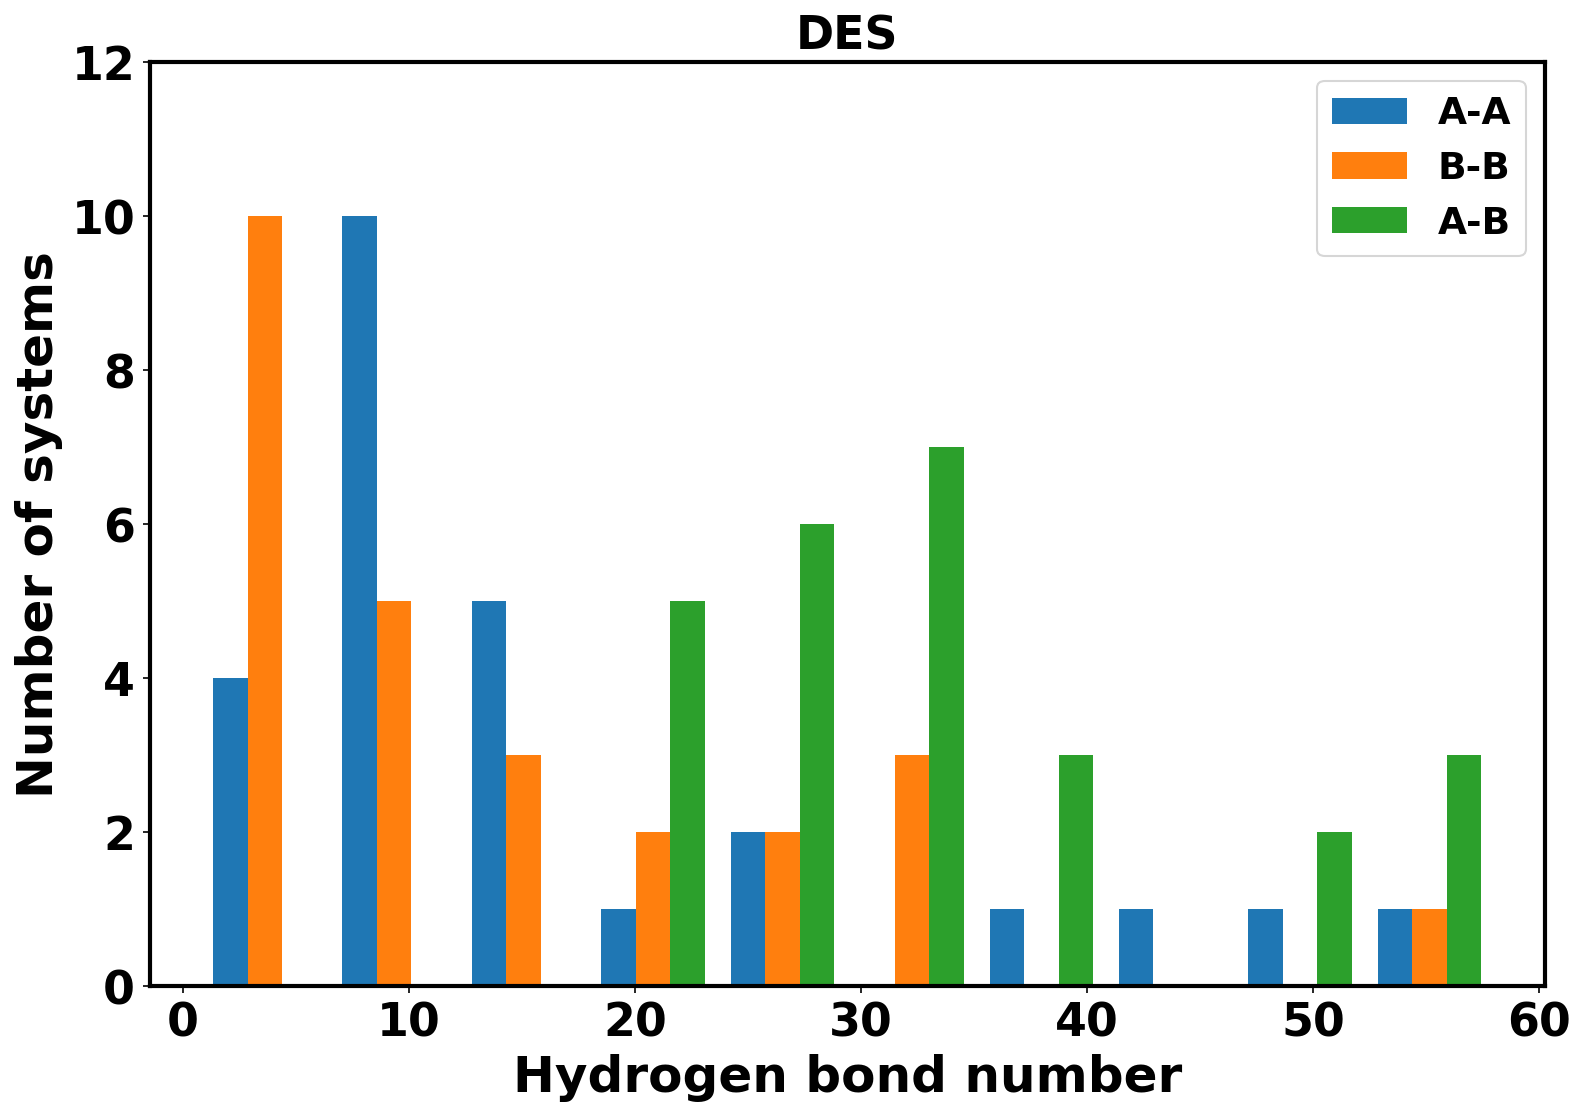

In [11]:
# non-overlapping histo DES
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
des_fig_lignin = plt.figure()
des_fig_lignin.set_size_inches(12, 8, forward=True)
des_ax_lignin = des_fig_lignin.add_subplot(1,1,1)
des_ax_lignin.set_xlabel("Hydrogen bond number", fontsize=24, weight='bold')
des_ax_lignin.set_ylabel("Number of systems", fontsize=24, weight='bold')
ytick = np.arange(0,40, 2)
xtick = np.arange(0,140, 10)
plt.yticks(ytick,fontsize=22, weight='bold')
plt.xticks(xtick,fontsize=22, weight='bold')
plt.title('DES', fontsize=22, weight='bold')
plt.ylim([0,12])
# des = des[['AA', 'BB', 'AB']]
# des.plot.hist(bins=20, alpha=0.5, ylim=[0,22], ax=des_ax_lignin)
plt.hist([des_hnum_lignin['A-A'], des_hnum_lignin['B-B'], des_hnum_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
# plt.hist([des['A-A'], des['B-B'], des['A-B']], bins=binss, label=['A-A', 'B-B', 'A-B'])
plt.legend(loc='upper right', prop={'weight':'bold'})
# des_fig_lignin.savefig(f'des_hnum_lignin_nonoverlap_{xdate}.png', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()

#### Lignin non-DES

In [12]:
''' This function takes in a path to GROMACS outputs from hydrogen bond calculations, and stores the 
A-A, B-B, and B-B numtimes in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''

pathway = Path()

hnum_dict_nondes_lignin = {}

for folderz in pathway.glob('./desfiles-irc/nondes/*'):
    # print(folderz.stem)
    dict_key = folderz.stem
    hnum_list_nondes = []
    for file in pathway.glob(f"{folderz}/hbond-???-*"):
        # print(file)
        if len(os.listdir(file)) < 3:
            hnum_list_nondes.append(0)
            continue

        for txt in pathway.glob(f"{file}/hnum*.txt"):
            # print(txt)
            txtfile = txt.name
            data = pd.read_csv('{}'.format(txt), sep='\s+',
                               header=None, skiprows=[0, 1])
            data = pd.DataFrame(data)
            y = data[1]
            avg = 0
            avg = np.average(y)  # Change dx to 1 for files prior to 7 Sep 2020
            hnum_list_nondes.append(avg)
            # print("The avg of {thing} is {val}".format(thing= txt.stem, val=avg))
            # print("\n")

    hnum_dict_nondes_lignin[f"{dict_key}"] = hnum_list_nondes
    # print(hnum_dict_nondes_lignin)
    # print("\n")

NONDES = []
AA = []
AB = []
BB = []

for i in list(hnum_dict_nondes_lignin.items()):
    # print(i)
    NONDES.append(i[0])
    AA.append(i[1][0])
    AB.append(i[1][1])
    BB.append(i[1][2])
    # try:
    #     BB.append(i[1][2])
    # except:
    #     BB.append(0)

nondes_dict_lignin = {
    "DES": NONDES,
    "A-A": AA,
    "A-B": AB,
    "B-B": BB
}
nondes_hnum_frame_lignin = pd.DataFrame(nondes_dict_lignin, columns=["DES", "A-A", "B-B", "A-B"])
# nondes_hnum_frame_lignin
aa_nnum_lignin = nondes_hnum_frame_lignin['A-A']
ab_nnum_lignin = nondes_hnum_frame_lignin['A-B']
bb_nnum_lignin = nondes_hnum_frame_lignin['B-B']
nondes_hnum_frame_lignin['A-A/B-B'] = aa_nnum_lignin/bb_nnum_lignin
# nondes_hnum_frame_lignin['BB/AA'] = bb_nnum_lignin/aa_nnum_lignin
nondes_hnum_frame_lignin['A-B/(A-A + B-B)'] = ab_nnum_lignin/(aa_nnum_lignin + bb_nnum_lignin)
nondes_hnum_frame_lignin.describe()

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B)
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,15.999632,25.291130,40.553184,2.004421,1.007132
std,9.111275,12.022864,14.826011,4.894201,0.346748
min,4.112887,0.695305,13.884116,0.122597,0.460512
25%,7.978022,13.910090,30.129870,0.268757,0.818927
50%,12.703297,28.919081,46.457542,0.592641,0.939760
75%,23.010989,35.719281,52.648851,1.405557,1.276453
max,31.319680,39.716284,58.141858,21.818966,1.697535


In [47]:
# nondes_hnum_frame_lignin.to_excel('./nondes_lignin_hnum.xlsx')
# nondes_hnum_frame_lignin.describe().to_excel('./nondes_lignin_hnum_summary.xlsx')

In [13]:
''' This cell deletes the A-A, B-B, and B-B lifetimes with 0.00 values in a pandas dataframe. The dataframe can be stored as a csv for later use.
'''
nondes_hnum_lignin = nondes_hnum_frame_lignin[(nondes_hnum_frame_lignin['B-B'] > 0.0)]
nondes_hnum_lignin.reset_index(drop=True, inplace=True)
# nondes_hnum_lignin

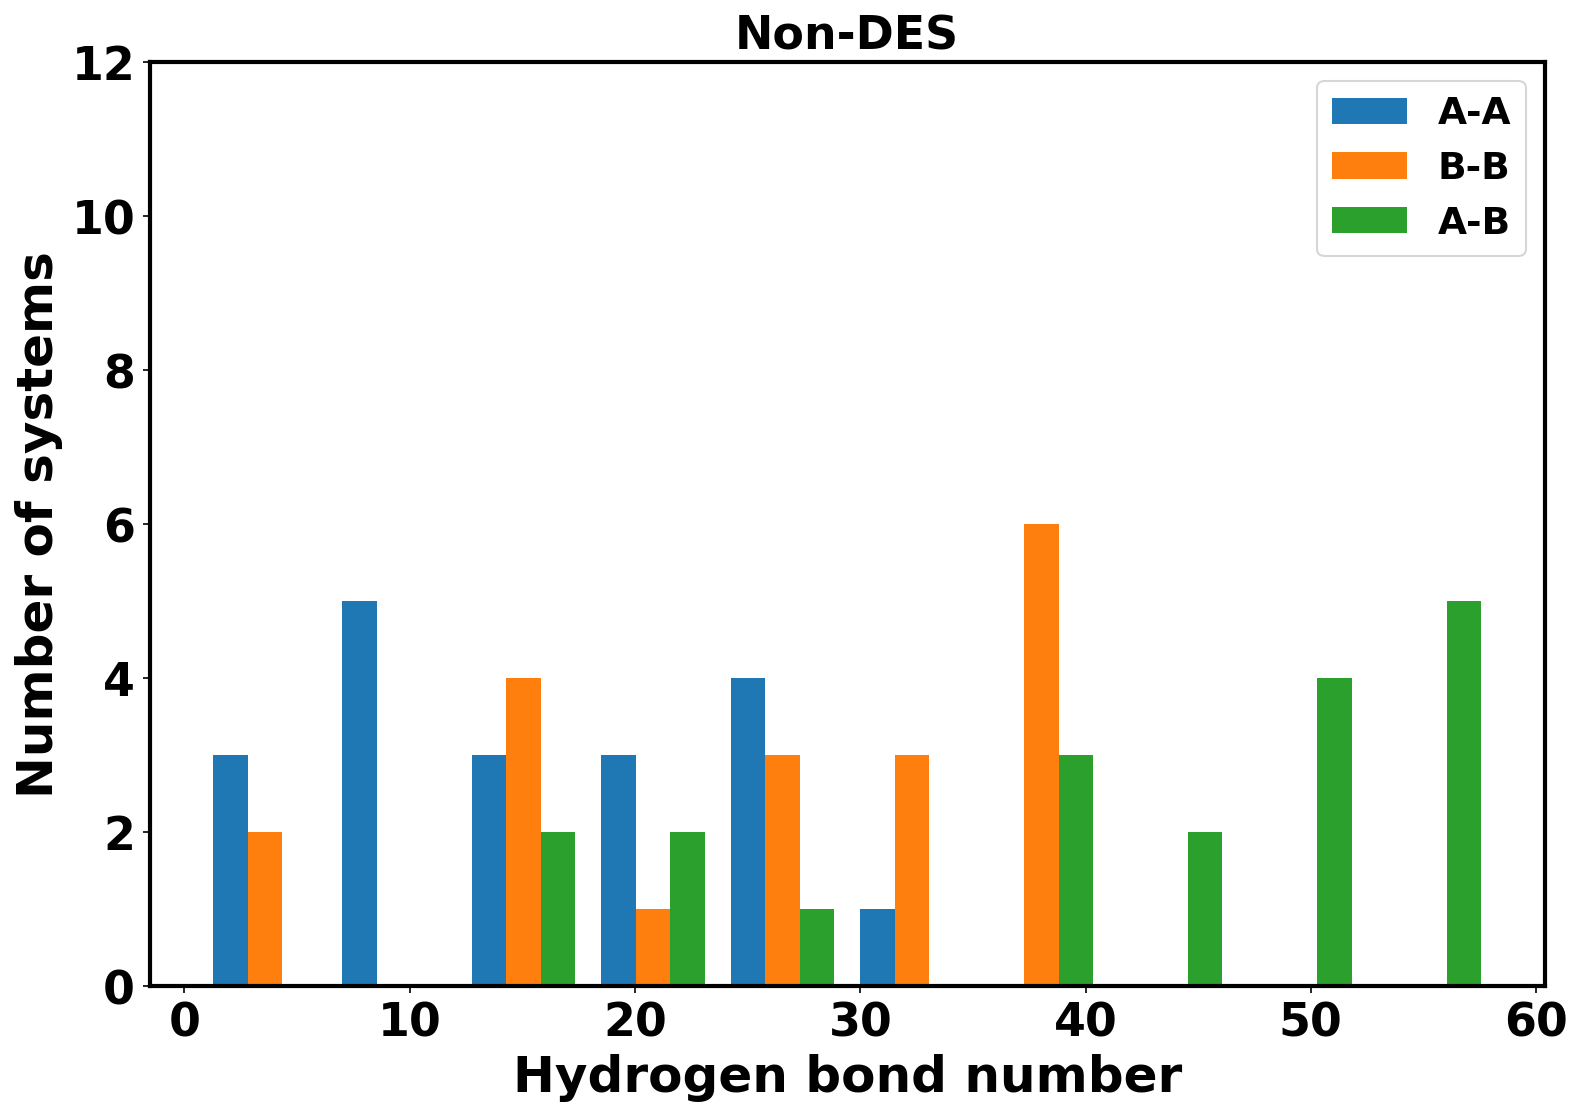

In [14]:
# non-overlapping histo NON-DES
xdate = datetime.datetime.now().strftime("%m-%d-%Y")
non_des_fig_lignin = plt.figure()
non_des_fig_lignin.set_size_inches(12, 8, forward=True)
non_des_ax_lignin = non_des_fig_lignin.add_subplot(1,1,1)
non_des_ax_lignin.set_xlabel("Hydrogen bond number", fontsize=24, weight='bold')
non_des_ax_lignin.set_ylabel("Number of systems", fontsize=24, weight='bold')
ytick = np.arange(0,40, 2)
xtick = np.arange(0,90, 10)
plt.yticks(ytick,fontsize=22, weight='bold')
plt.xticks(xtick,fontsize=22, weight='bold')
plt.title('Non-DES', fontsize=22, weight='bold')
plt.ylim([0,12])
# non_des_hist = non_des[['AA', 'BB', 'AB']]
# non_des_hist.plot.hist(bins=20, alpha=0.5, ylim=[0,22], ax =non_des_ax_lignin) # ylim=[0,22], 
plt.hist([nondes_hnum_lignin['A-A'], nondes_hnum_lignin['B-B'], nondes_hnum_lignin['A-B']], bins=10, label=['A-A', 'B-B', 'A-B'])
plt.legend(loc='upper right', prop={'weight':'bold'})
# non_des_fig_lignin.savefig(f'nondes_hnum_lignin_nonoverlap_{xdate}.png', dpi=350,facecolor='white', bbox_inches='tight')
plt.show()


### Utility functions

In [15]:
def dirmaker(path):
    '''
    path is the folder path you want to make if it exists
    '''
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)
        pass


#### data generation for hnum or hlife or merged data
This generates random data samples of training and testing set for hnum or hlife or merged scenarios.

In [118]:
def data_validate(des, nondes, batch_size=19, random_state=1):
    '''
    This generates batches of equally sized data samples from two dataframes
    and returns training datasets.
    '''
    des_batch_df = des.sample(n=batch_size, replace=False, random_state=random_state)
    df = [des_batch_df, nondes]
    df_train = pd.concat(df).drop_duplicates(keep=False)
    df_train = df_train.reset_index()

    X_train = np.array(df_train.drop(columns=['output', 'index']))
    y_train = np.array(df_train['output'])

    # if folder_type == 'hlife' or folder_type == 'hnum':
    #     X_train = np.array(df_train.drop(columns=['output', 'index']))
    #     y_train = np.array(df_train['output'])
    # elif folder_type == 'merged':
    #     X_train = np.array(df_train.drop(columns=['output_l', 'output_n', 'index']))
    #     y_train = np.array(df_train['output'])
    # else:
    #     print('Something is wrong somewhere')            

    return X_train, y_train


#### Validation functions
Functions for validating different model types.

In [132]:
def validate_trained_models(model, X, y, file_name, folder_type='unclassified', num=100, rand_seed=1000):
    '''
    This function validates a saved model on hnum/hlife/merged data.
    Works with sklearn GradBoost, AdaBoost, RandomForest,
    ExtraTreesForest, and DecisionTrees. 

    model is the model instance,
    X is the input and y is the output
    file_name is the txt file for logs,
    folder_type can be hlife, hnum, merged, or unclassified.
    n_repeats is passed to grid search,
    rand_seed ensures replicability of CV.
    '''
    xdate = datetime.datetime.now().strftime("%m-%d-%Y")
    # print(xdate)

    roc_auc_list = []
    folder_name = folder_type
    model_name = model.__str__().split('(')[0]
    if model_name.__contains__("XGBClassifier"):
        model_name = "XGBClassifier"

        
    # file = open(f"./model-logs/hlife_{num}_{xdate}.txt", "w+")
    file = file_name

    X_test = X
    y_test = y
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)  # roc_auc_score needs probabilities
    print(f'Prediction probabilities: \n{y_pred_proba}', file=file)
    # print('Prediction probabilities: \n', y_pred_proba)
    print(f'Predictions: {y_pred}', file=file)
    # print('Predictions: ', y_pred)
    target_names = ['non-DES', 'DES']  # non-DES is 0, DES is 1
    print(metrics.classification_report(y_test, y_pred,
        target_names=target_names), file=file)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    print(f"roc_auc_score: {roc_auc}", file=file)
    roc_auc_list.append(roc_auc)
    # print(model.feature_importances_, file=file)
    print('\n', file=file)
    # print(model_feature_df, file=file)
    print('\n'*2, file=file)


    # plotting roc_auc score
    fig = plt.figure()
    fig.set_size_inches(12, 10, forward=True)
    fig_ax = fig.add_subplot(1, 1, 1)
    fig_ax.set_xlabel("Number of iterations", fontsize=24, weight='bold')
    fig_ax.set_ylabel("ROC_AUC Score", fontsize=24, weight='bold')

    if folder_name == 'hlife':
        title_tag = 'lifetimes'
    elif folder_name == 'hnum':
        title_tag = 'numbers'
    elif folder_name == 'merged':
        title_tag = 'numbers + lifetimes'
    else:
        title_tag = ''  # this could be an indication that the folder_type was not set properly


    ytick = np.arange(0, 1.2, 0.2)
    xtick = np.arange(0, 2.2, 1.0)
    plt.yticks(ytick, fontsize=22, weight='bold')
    plt.xticks(xtick, fontsize=22, weight='bold')
    fig_ax.set_ylim(0, 1.0)
    fig_ax.set_xlim(0, 2.0)
    plt.title(f'{model_name} hbond {title_tag}', fontsize=22, weight='bold')


    roc = [z for z in range(1, num+1)]
    print(f"roc_auc scores: {roc_auc_list}", file=file)
    print(
        f"Average roc_auc scores: {np.average(roc_auc_list)}", file=file)
    print(
        f"std dev of roc_auc scores: {np.std(roc_auc_list)}", file=file)
    print(
        f"Best roc_auc score: {max(roc_auc_list)} at index {roc_auc_list.index(max(roc_auc_list)) + 1}", file=file)
    print('\n', file=file)
    plt.plot(roc, roc_auc_list, '-o', linewidth=2, markersize=8.0, label=f"avg roc_auc: {round(np.average(roc_auc_list),2)}\nstd roc_auc : {round(np.std(roc_auc_list),2)}")
    plt.legend(loc='lower left', fontsize=16)    
    dirmaker(f'./plots/validation/{folder_name}/{xdate}')
    fig.savefig(f'plots/validation/{folder_name}/{xdate}/{model_name}_{lig}_{folder_name}_{num}-{xdate}.png', dpi=350, facecolor='white', bbox_inches='tight')
    plt.show()
    file.close()


## hbond lifetimes
Train models using hlife data alone.

#### hlife house cleaning

In [33]:
nondes_df_hlife = nondes_hlife_lignin.drop(columns=['Non-DES'])
nondes_df_hlife['output'] = 0
nondes_df_hlife

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,3.385798,3.155948,3.796678,1.072831,0.580377,0
1,2.849065,1.202049,3.117173,2.370173,0.769461,0
2,2.548177,2.454365,1.991729,1.038223,0.398143,0
3,1.591568,0.932191,1.228077,1.707342,0.486606,0
4,3.592210,3.197229,2.905294,1.123539,0.427914,0
5,3.059960,2.043980,2.156269,1.497060,0.422471,0
6,2.283029,1.045423,1.294826,2.183833,0.389018,0
7,3.076017,2.779366,3.105455,1.106733,0.530359,0
8,2.682118,3.330352,3.830274,0.805356,0.637055,0
9,2.734466,1.777658,3.015204,1.538241,0.668245,0


In [ ]:
des_df_hlife = des_hlife_lignin.drop(columns=['DES'])
des_df_hlife['output'] = 1
des_df_hlife

In [59]:
nondes_df_hlife

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,3.385798,3.155948,3.796678,1.072831,0.580377,0
1,2.849065,1.202049,3.117173,2.370173,0.769461,0
2,2.548177,2.454365,1.991729,1.038223,0.398143,0
3,1.591568,0.932191,1.228077,1.707342,0.486606,0
4,3.592210,3.197229,2.905294,1.123539,0.427914,0
5,3.059960,2.043980,2.156269,1.497060,0.422471,0
6,2.283029,1.045423,1.294826,2.183833,0.389018,0
7,3.076017,2.779366,3.105455,1.106733,0.530359,0
8,2.682118,3.330352,3.830274,0.805356,0.637055,0
9,2.734466,1.777658,3.015204,1.538241,0.668245,0


## Validation

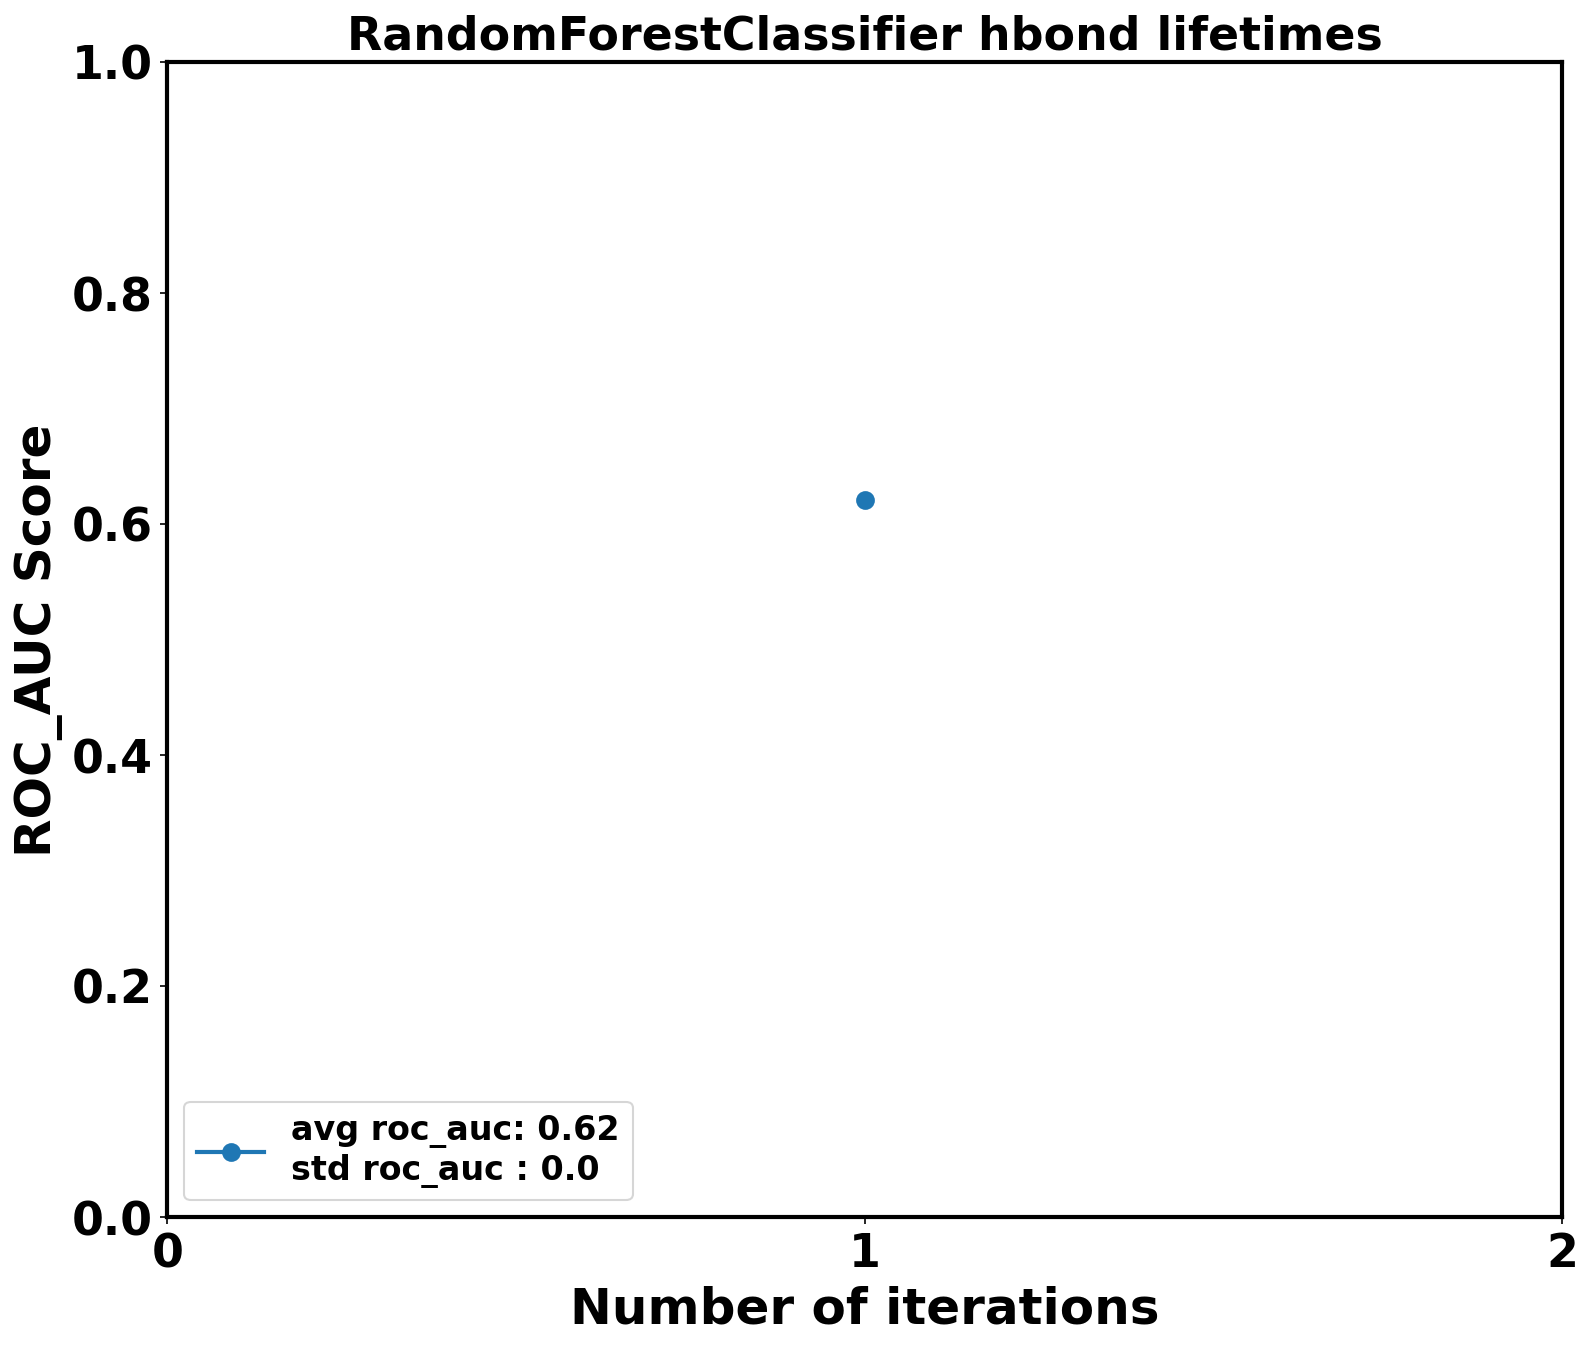

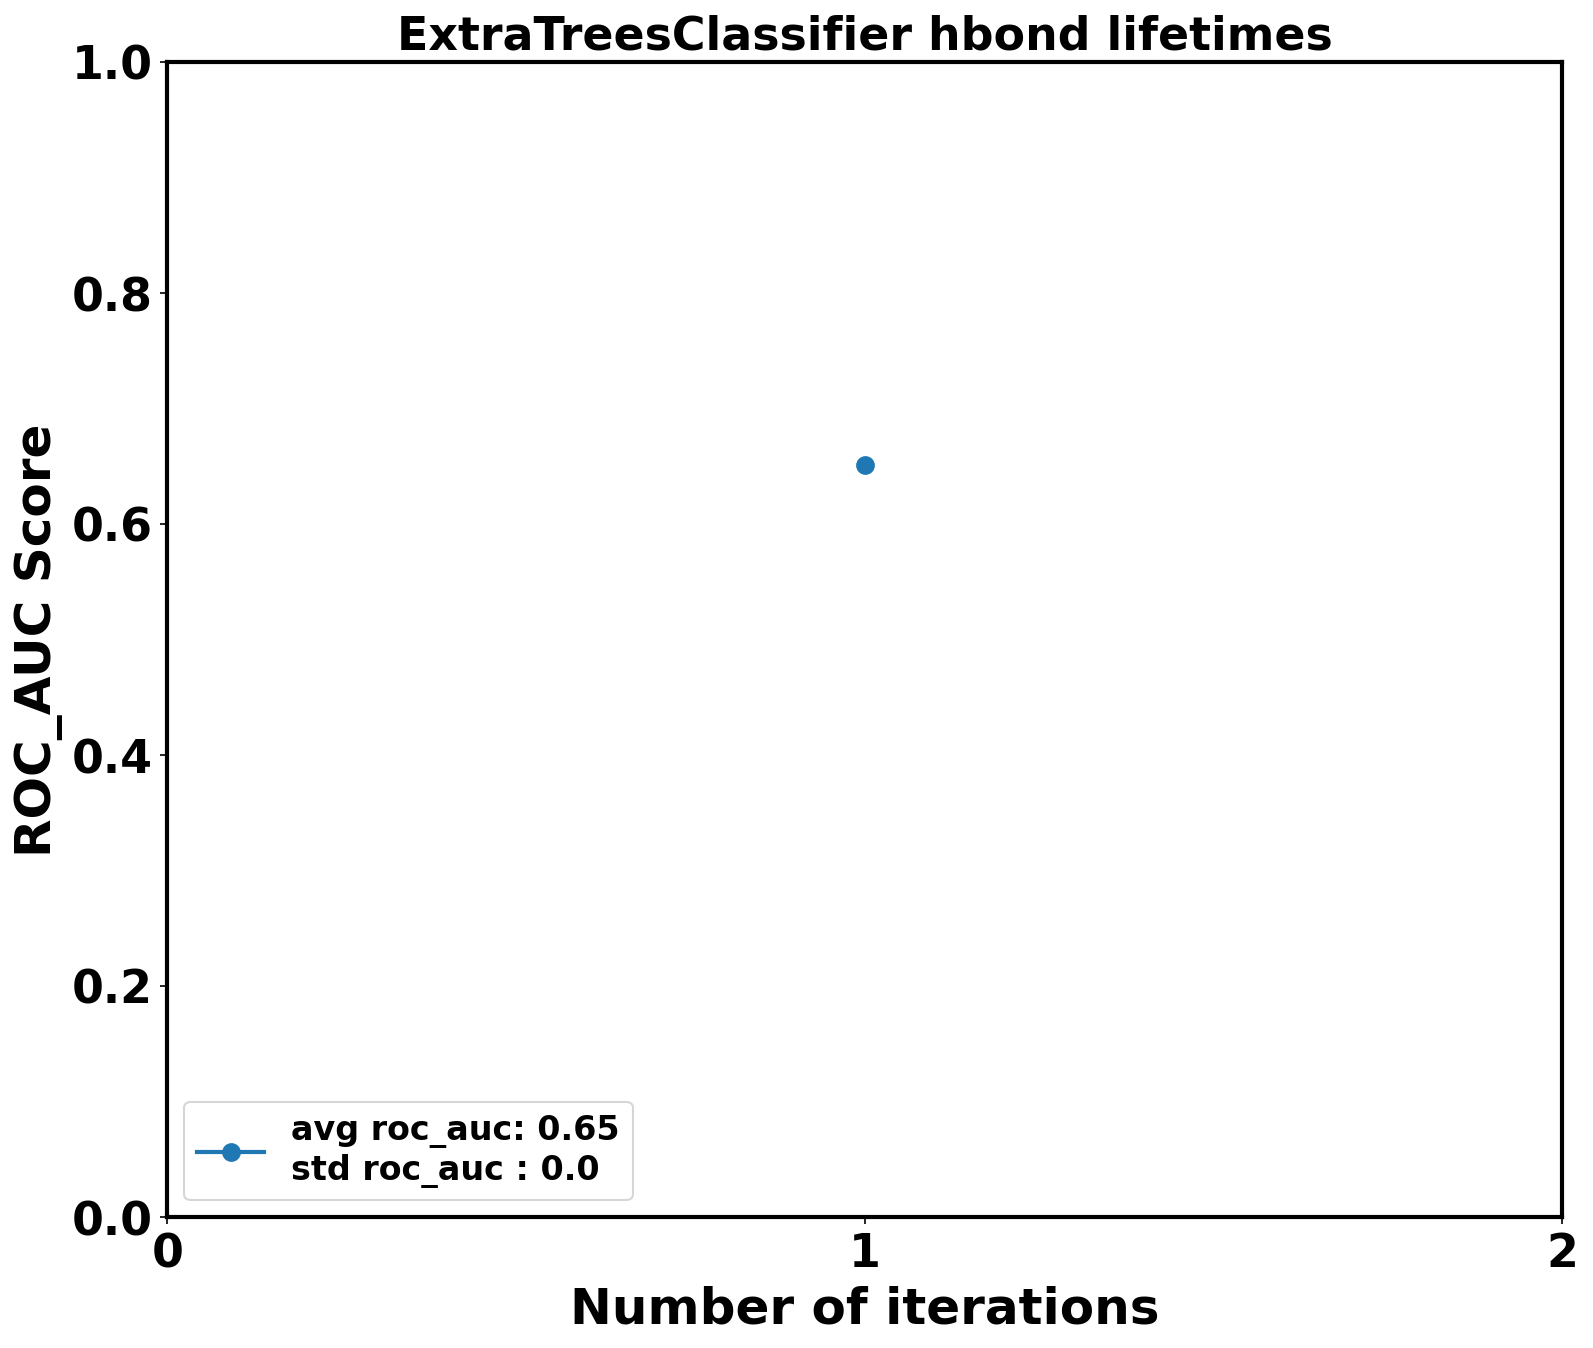

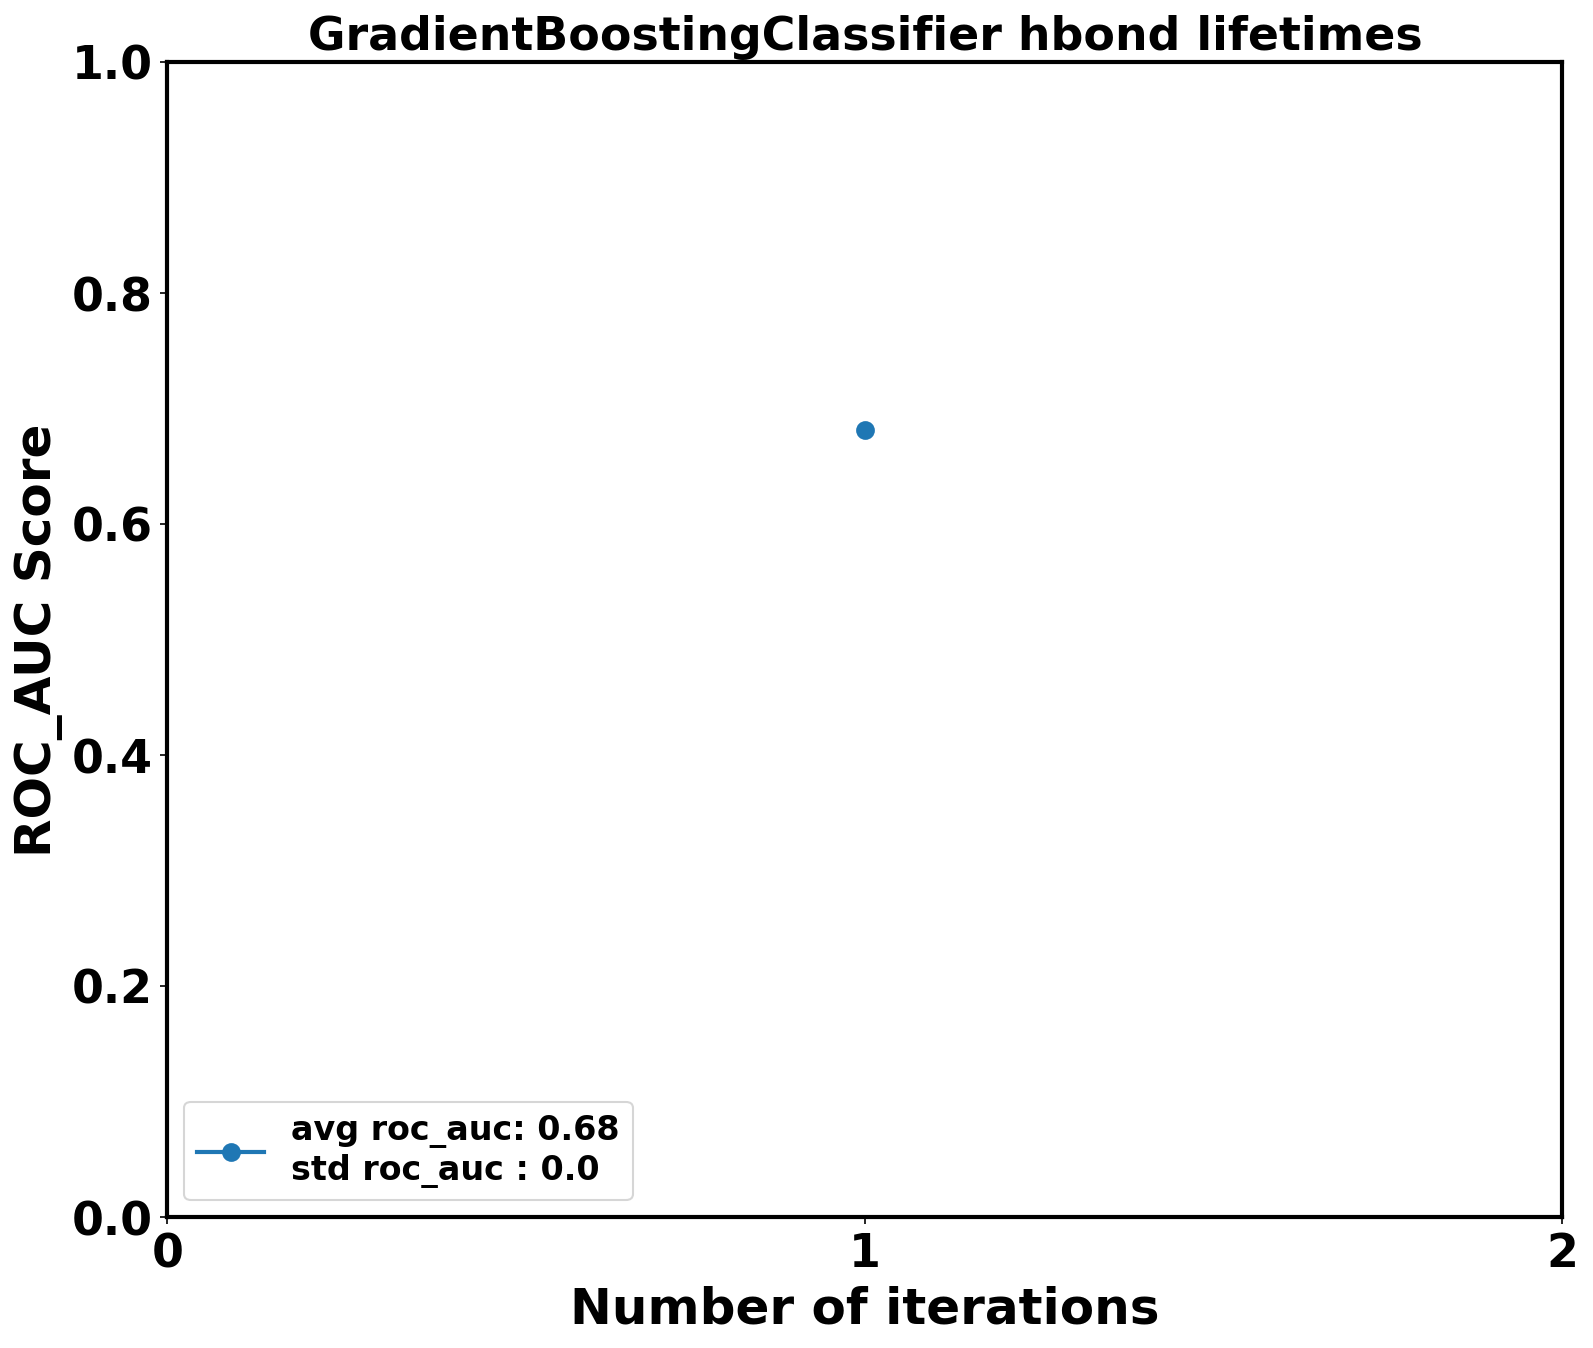

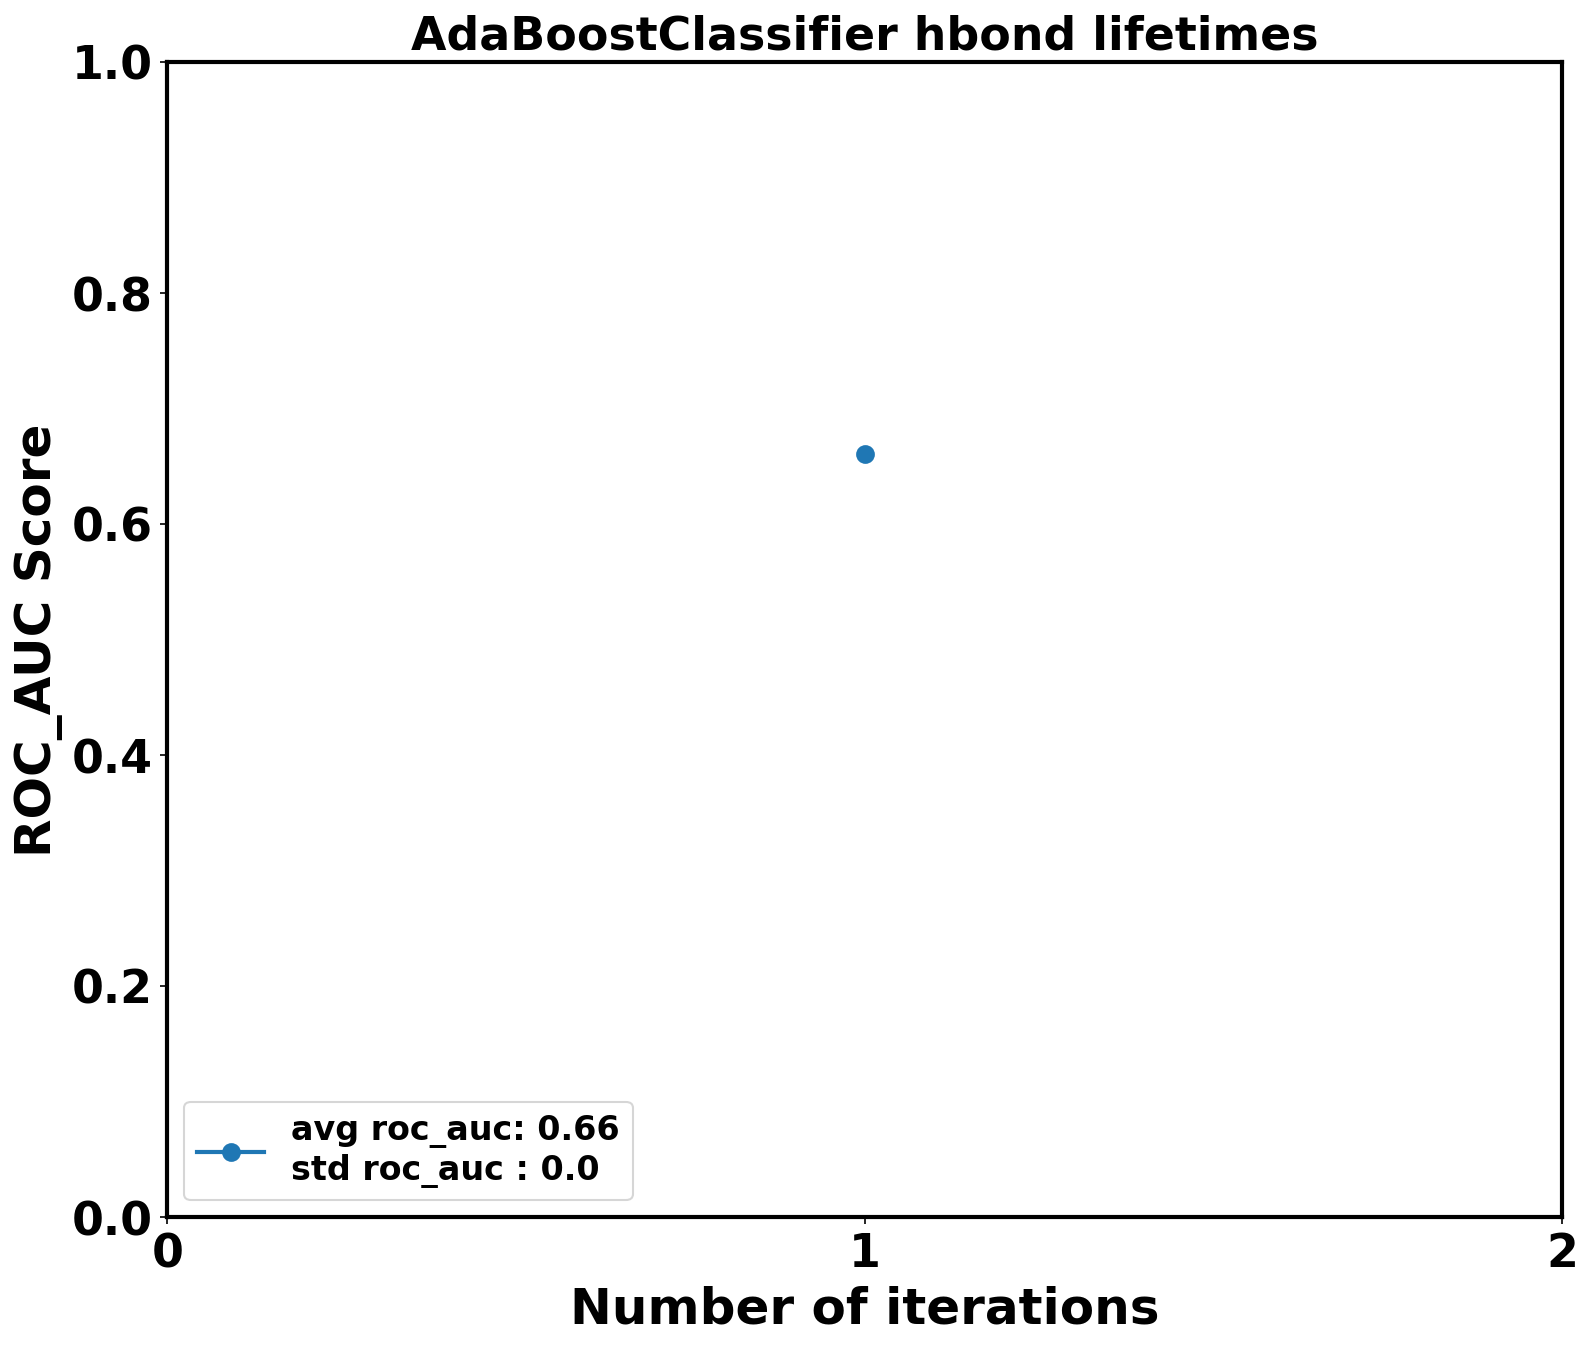

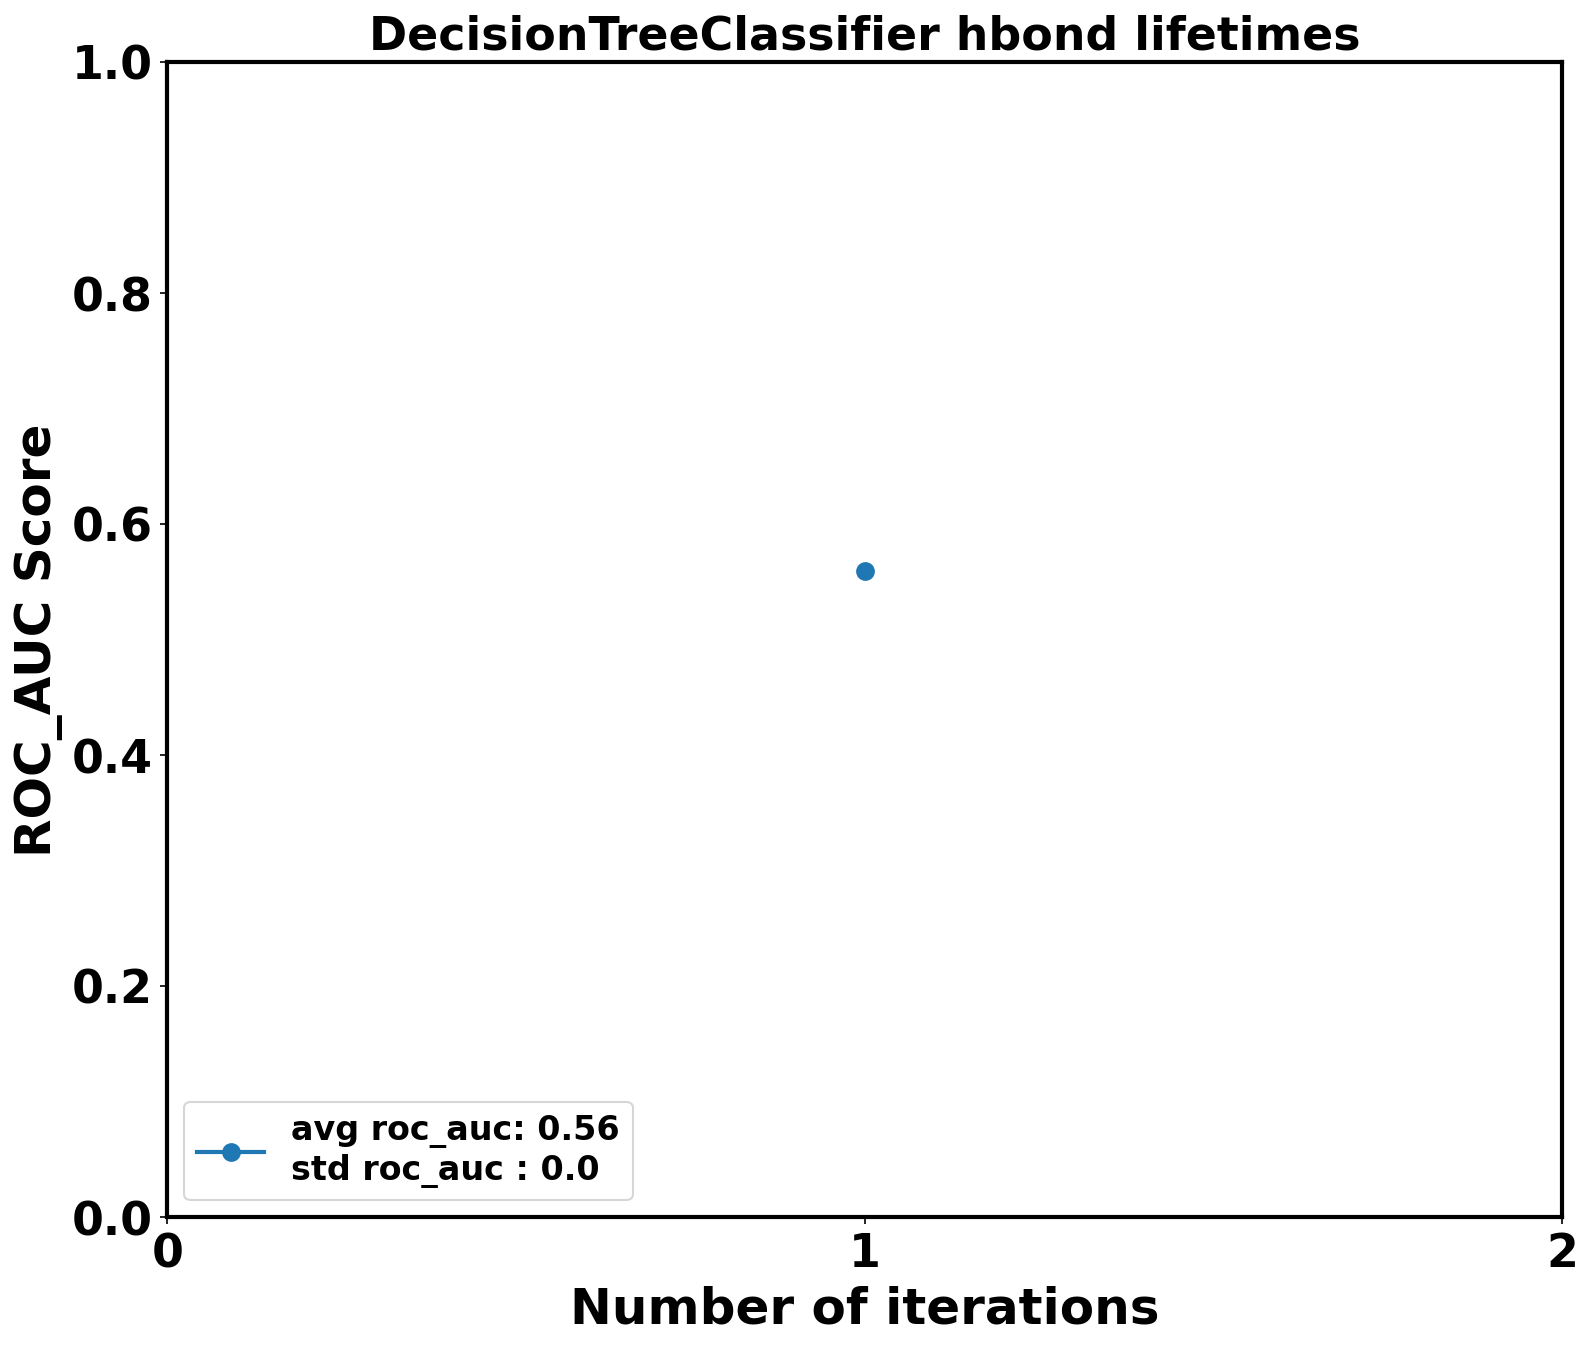

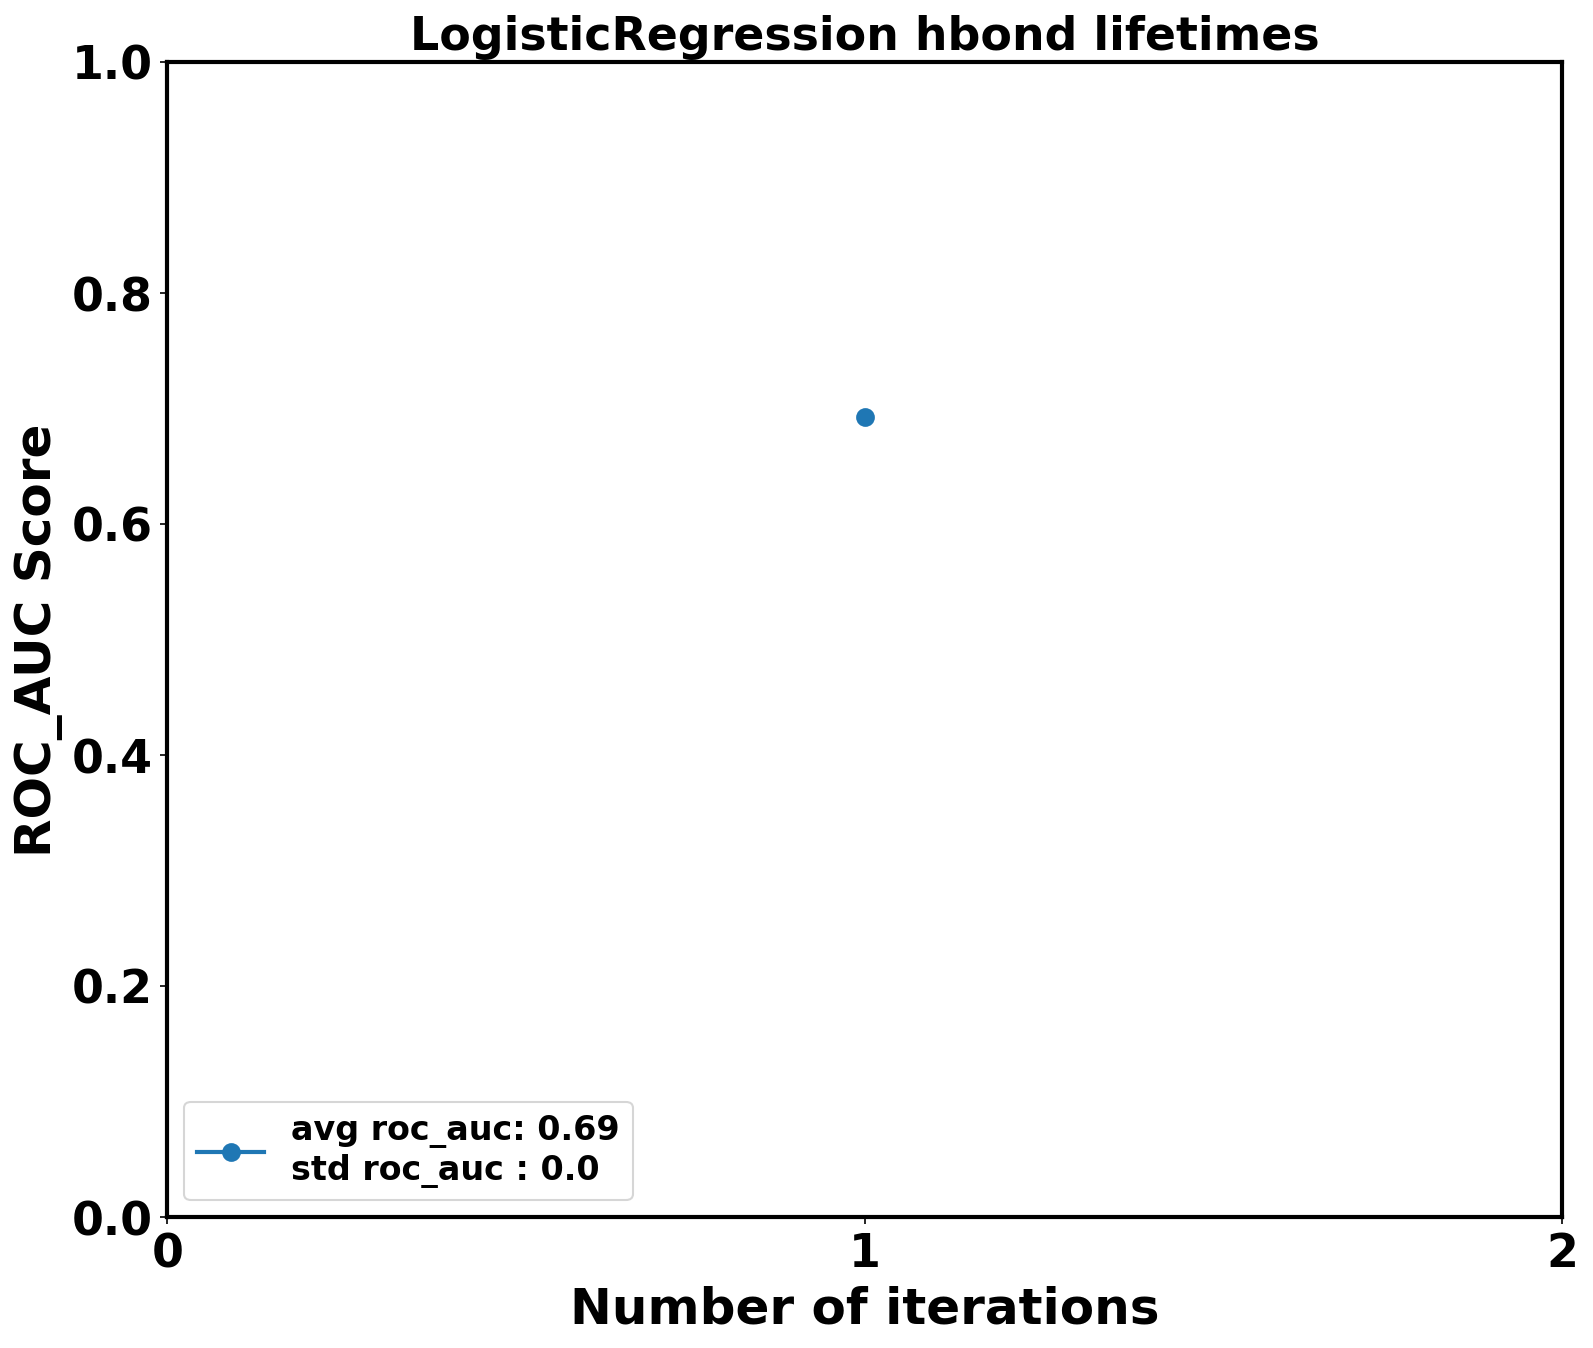

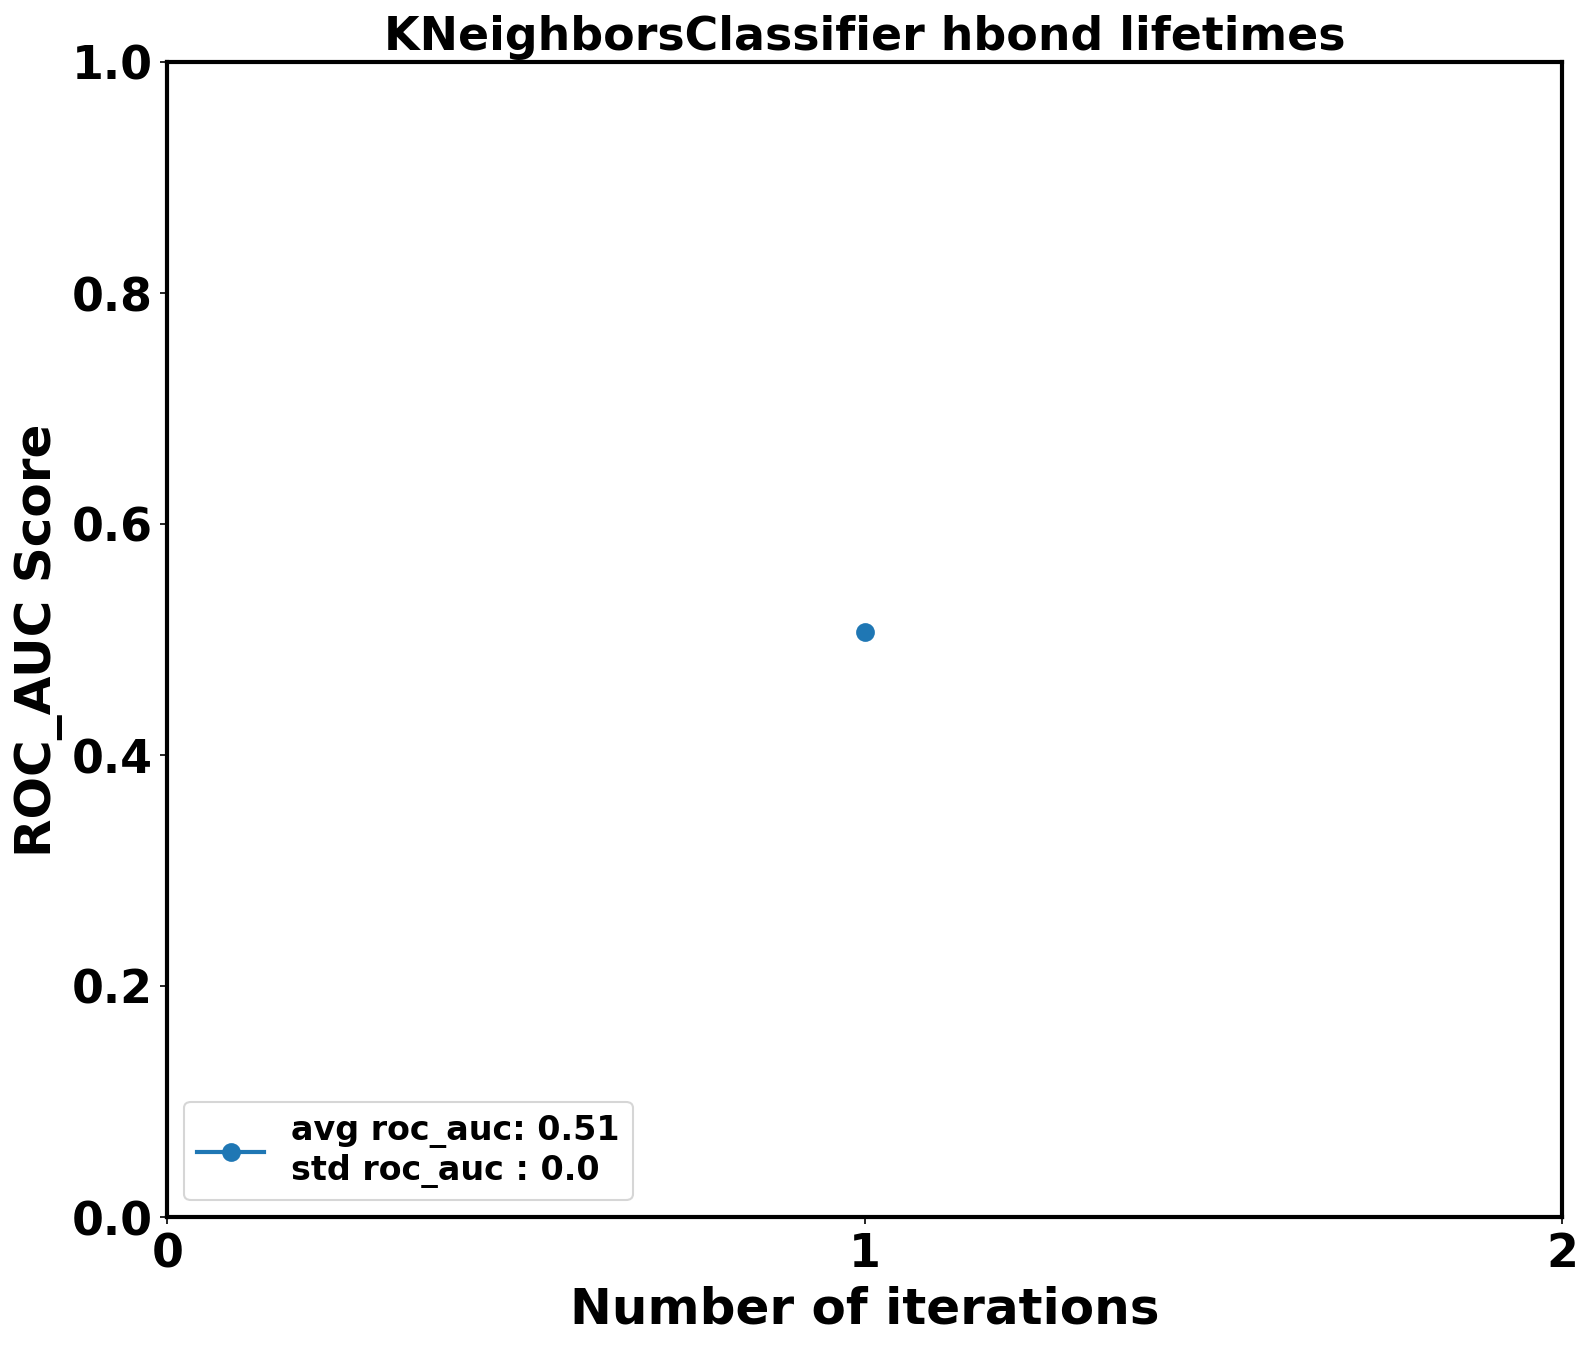

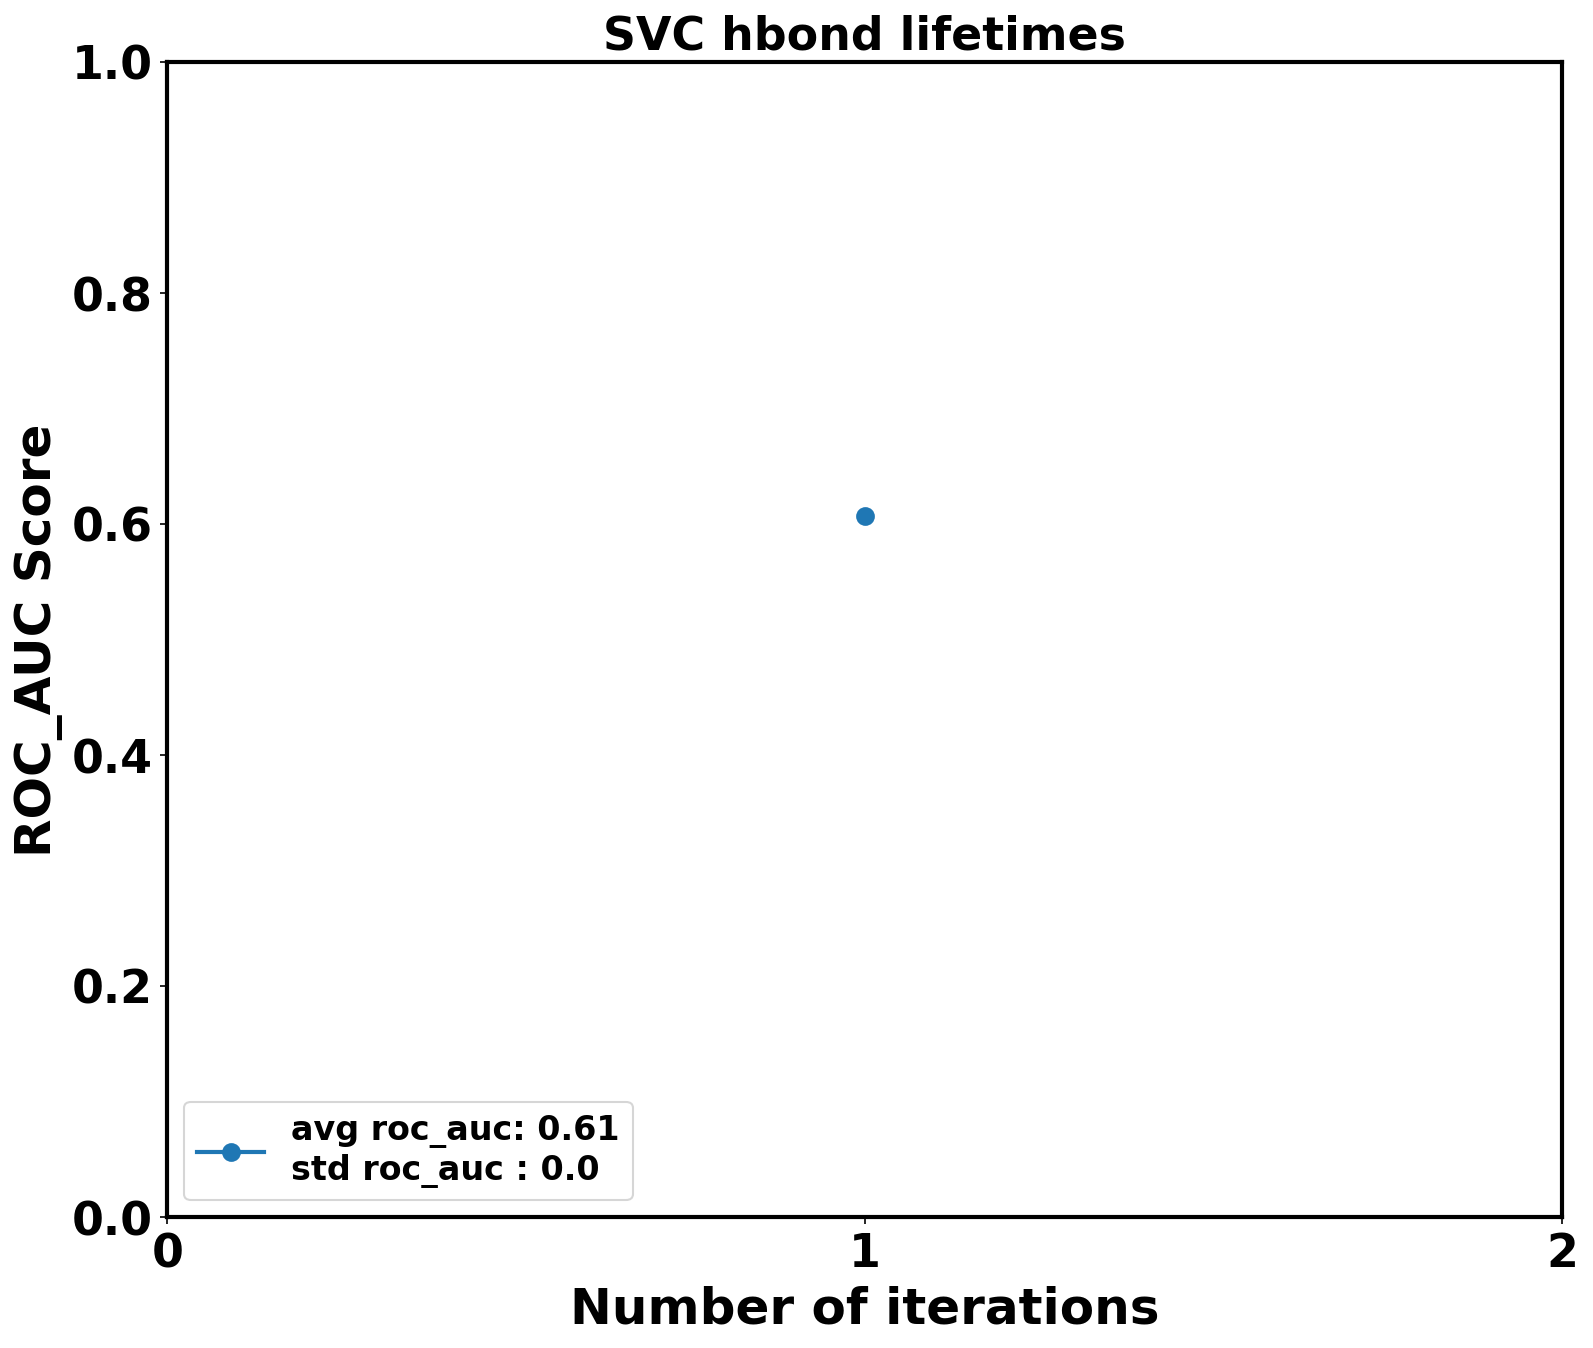

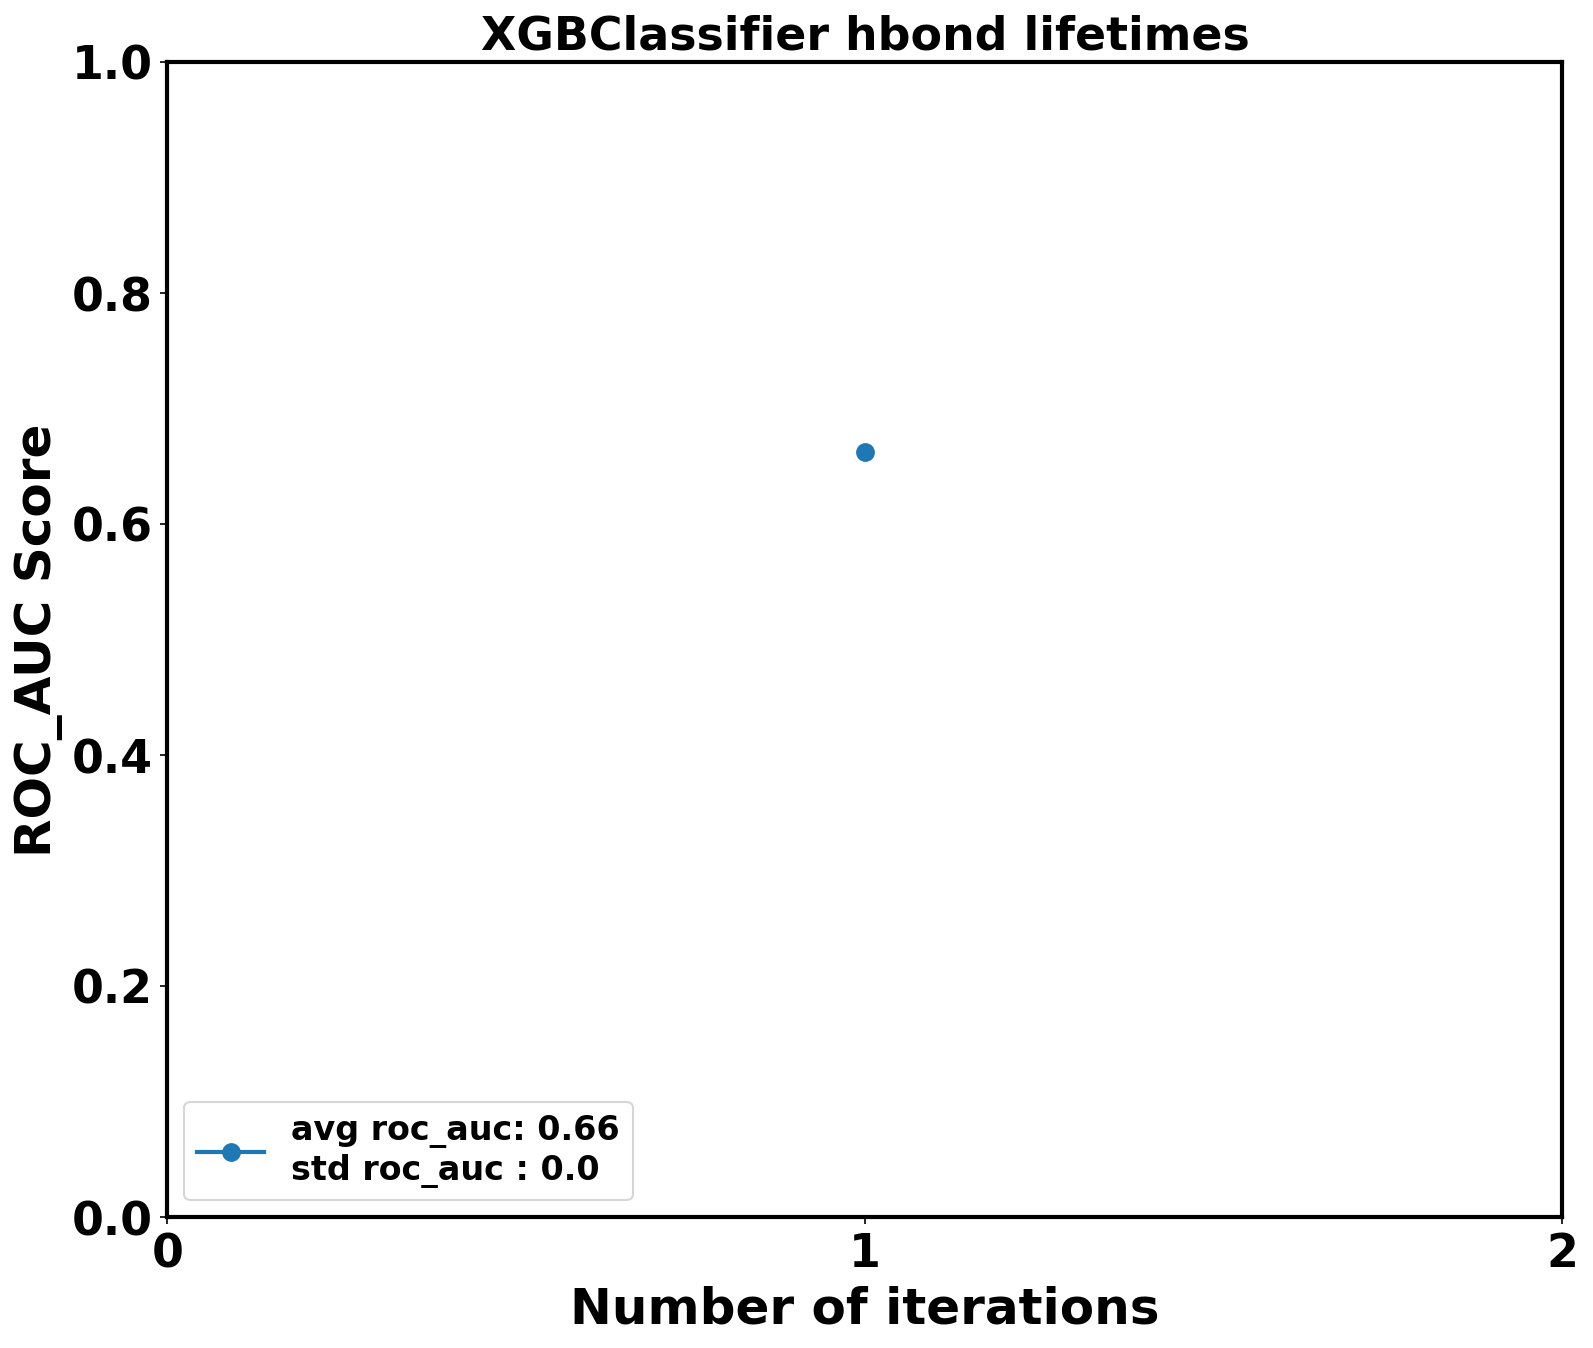

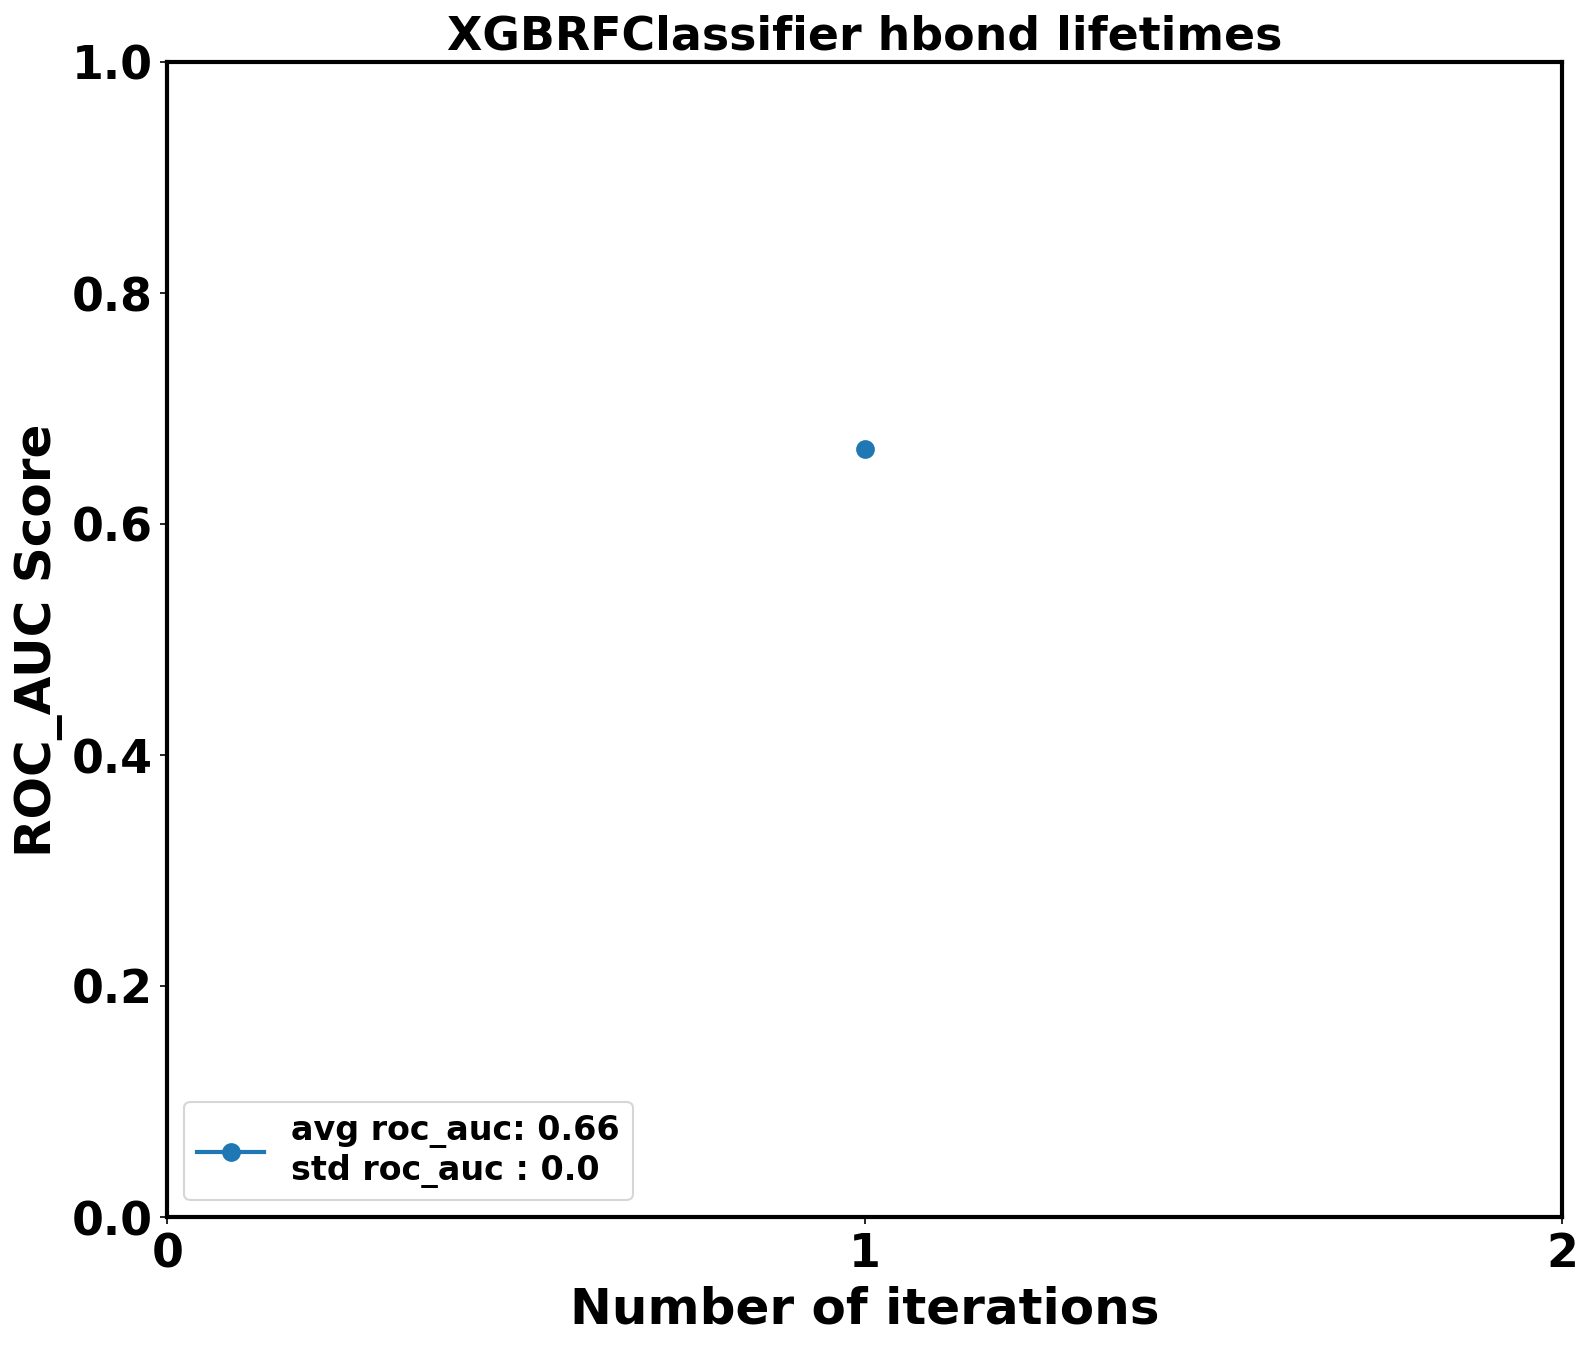

In [133]:
# Validation with lignin

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='hlife'
folder_types = ['hlife', 'hnum', 'merged']
tag = "LR"

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./model-logs/validation/{folder_type}/{xdate}')
    file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_hlife, nondes_df_hlife)   
    validate_trained_models(model_type, X, Y,file_name=file_name, folder_type=folder_type, num=n_repeat, rand_seed=rand_seed)

## hnumber only

#### non-des hnum

In [36]:
nondes_df_hnum = nondes_hnum_lignin.drop(columns=['DES'])  # should change this to non-DES
nondes_df_hnum['output'] = 0
nondes_df_hnum

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,4.112887,22.075924,40.374625,0.186306,1.541675,0
1,15.170829,0.695305,13.884116,21.818966,0.875079,0
2,29.220779,35.496503,53.883117,0.823202,0.832592,0
3,23.880120,36.495504,52.185814,0.654330,0.864352,0
4,19.677323,33.202797,53.625375,0.592641,1.014093,0
5,28.627373,14.524476,24.582418,1.970975,0.569672,0
6,31.319680,13.295704,20.875125,2.355624,0.467891,0
7,28.134865,23.941059,47.306693,1.175172,0.908418,0
8,4.645355,37.891109,55.707293,0.122597,1.309636,0
9,8.237762,33.521479,53.111888,0.245746,1.271860,0


#### des hnum

In [37]:
des_df_hnum = des_hnum_lignin.drop(columns=['DES'])  # should change this to DES
des_df_hnum['output'] = 1
des_df_hnum

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
0,8.405594,22.092907,30.725275,0.380466,1.007436,1
1,15.329670,0.770230,18.419580,19.902724,1.144080,1
2,6.903097,29.975025,33.074925,0.230295,0.896871,1
3,13.204795,2.059940,20.208791,6.410281,1.323887,1
4,5.362637,52.633367,34.727273,0.101887,0.598787,1
5,7.165834,5.254745,48.160839,1.363688,3.877503,1
6,2.206793,20.933067,52.064935,0.105421,2.250011,1
7,47.078921,2.828172,58.005994,16.646415,1.162280,1
8,19.658342,11.382617,40.727273,1.727049,1.312049,1
9,8.469530,33.392607,54.238761,0.253635,1.295652,1


## Validation

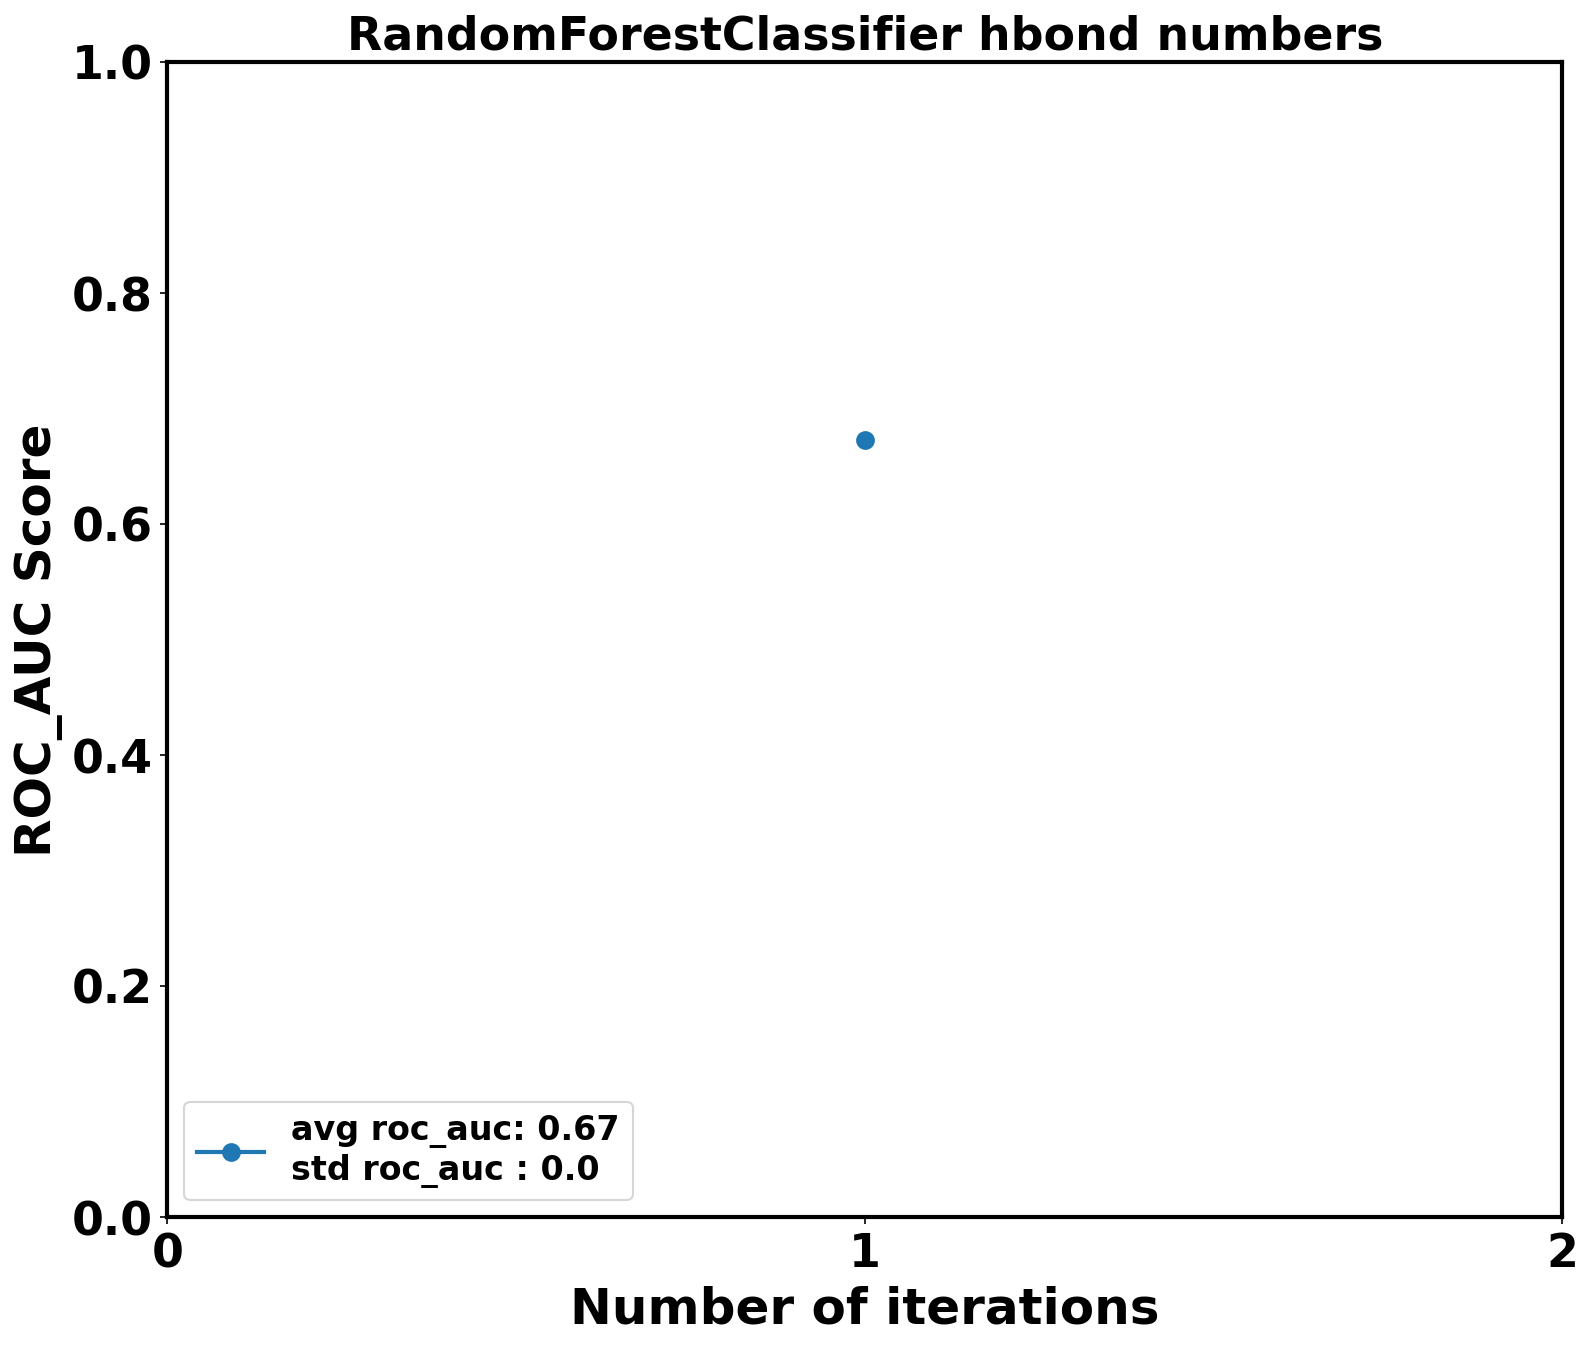

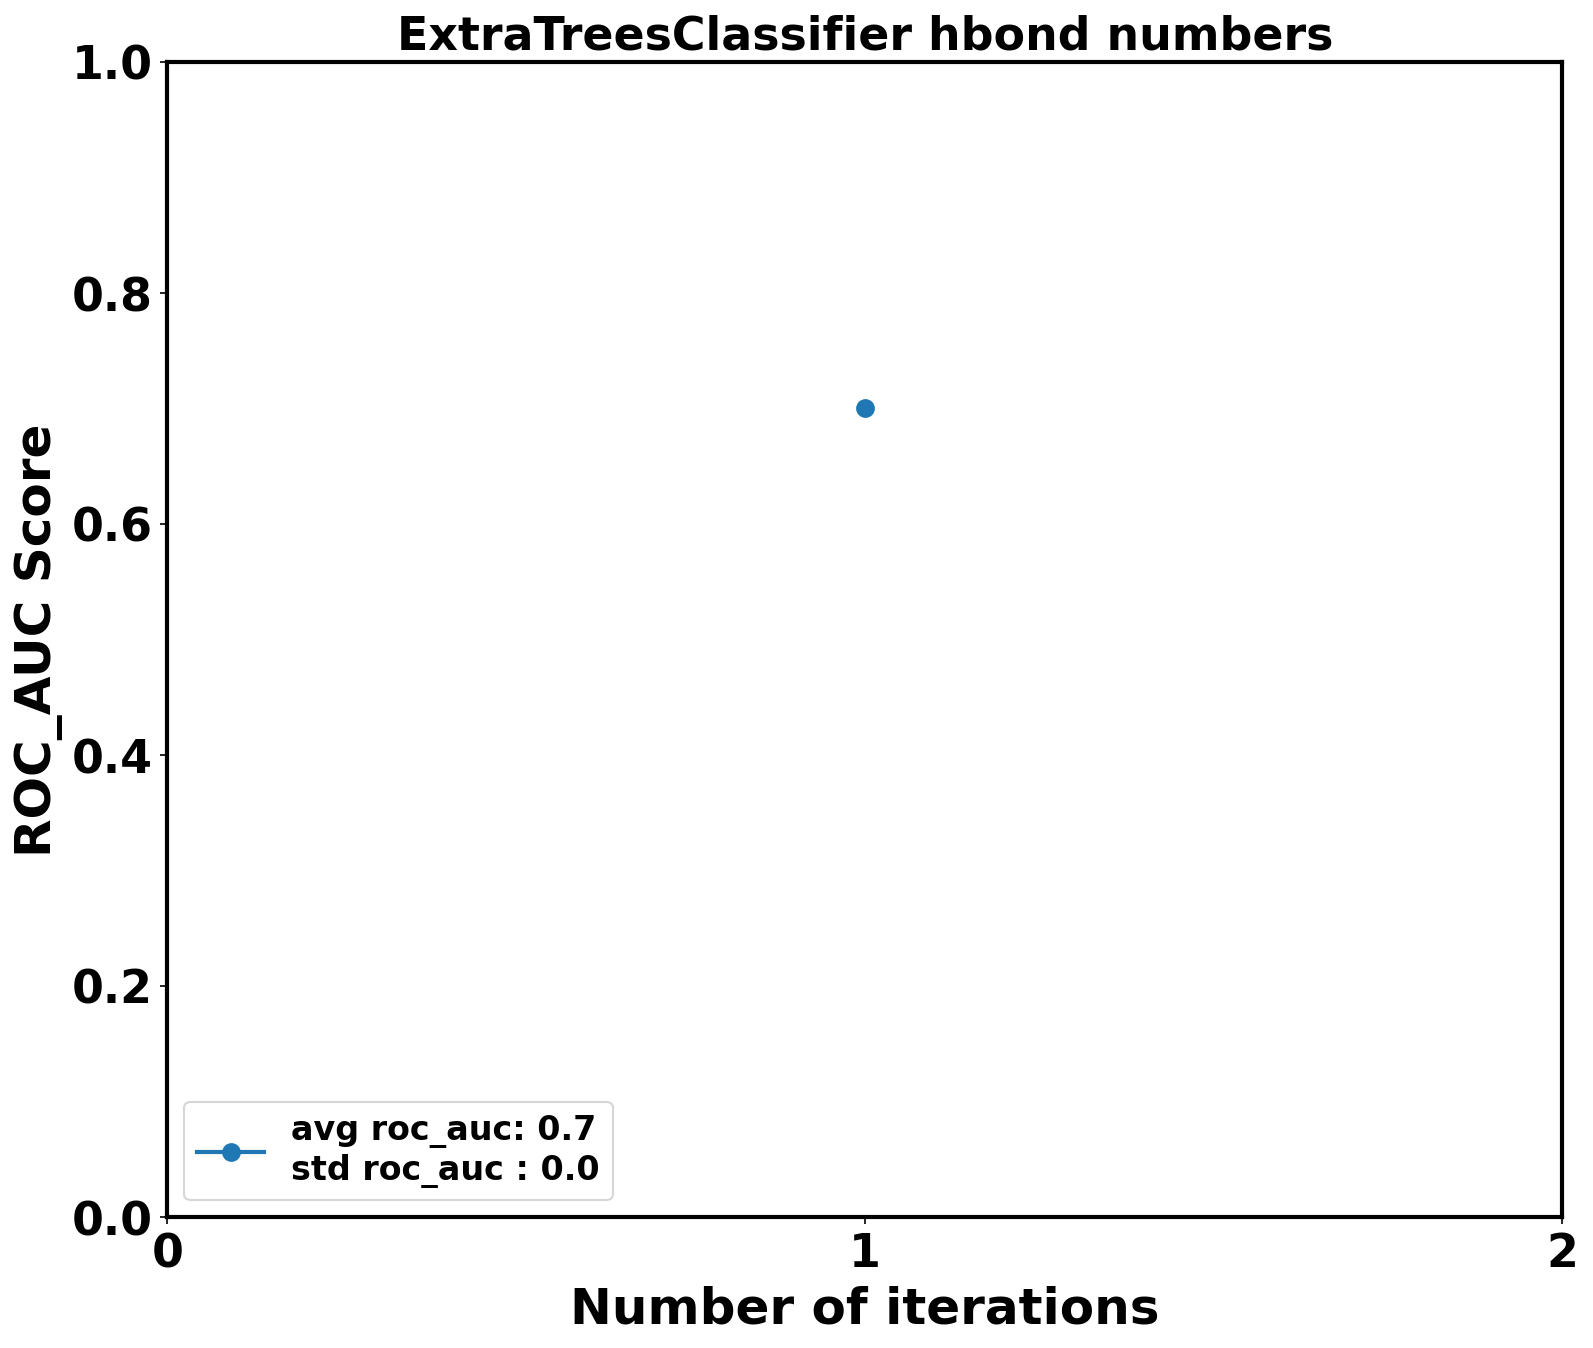

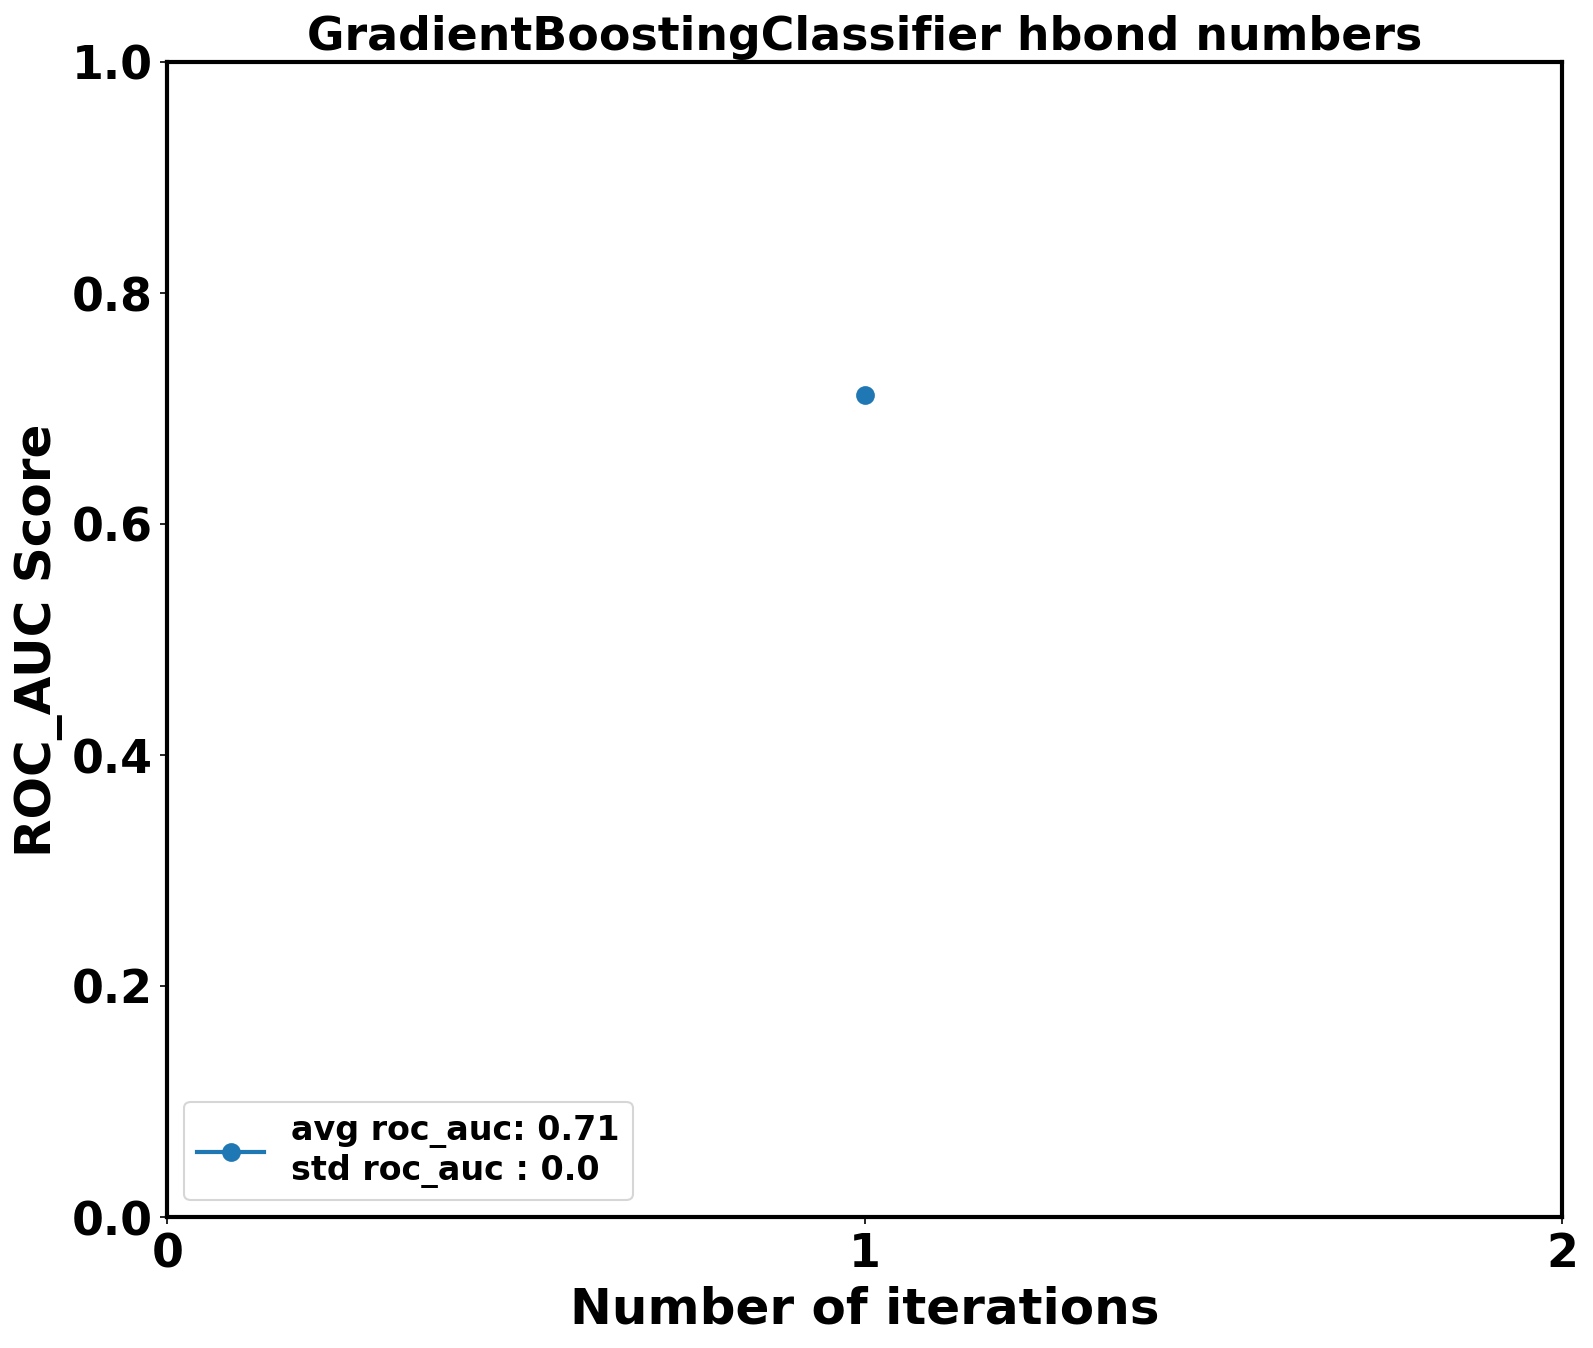

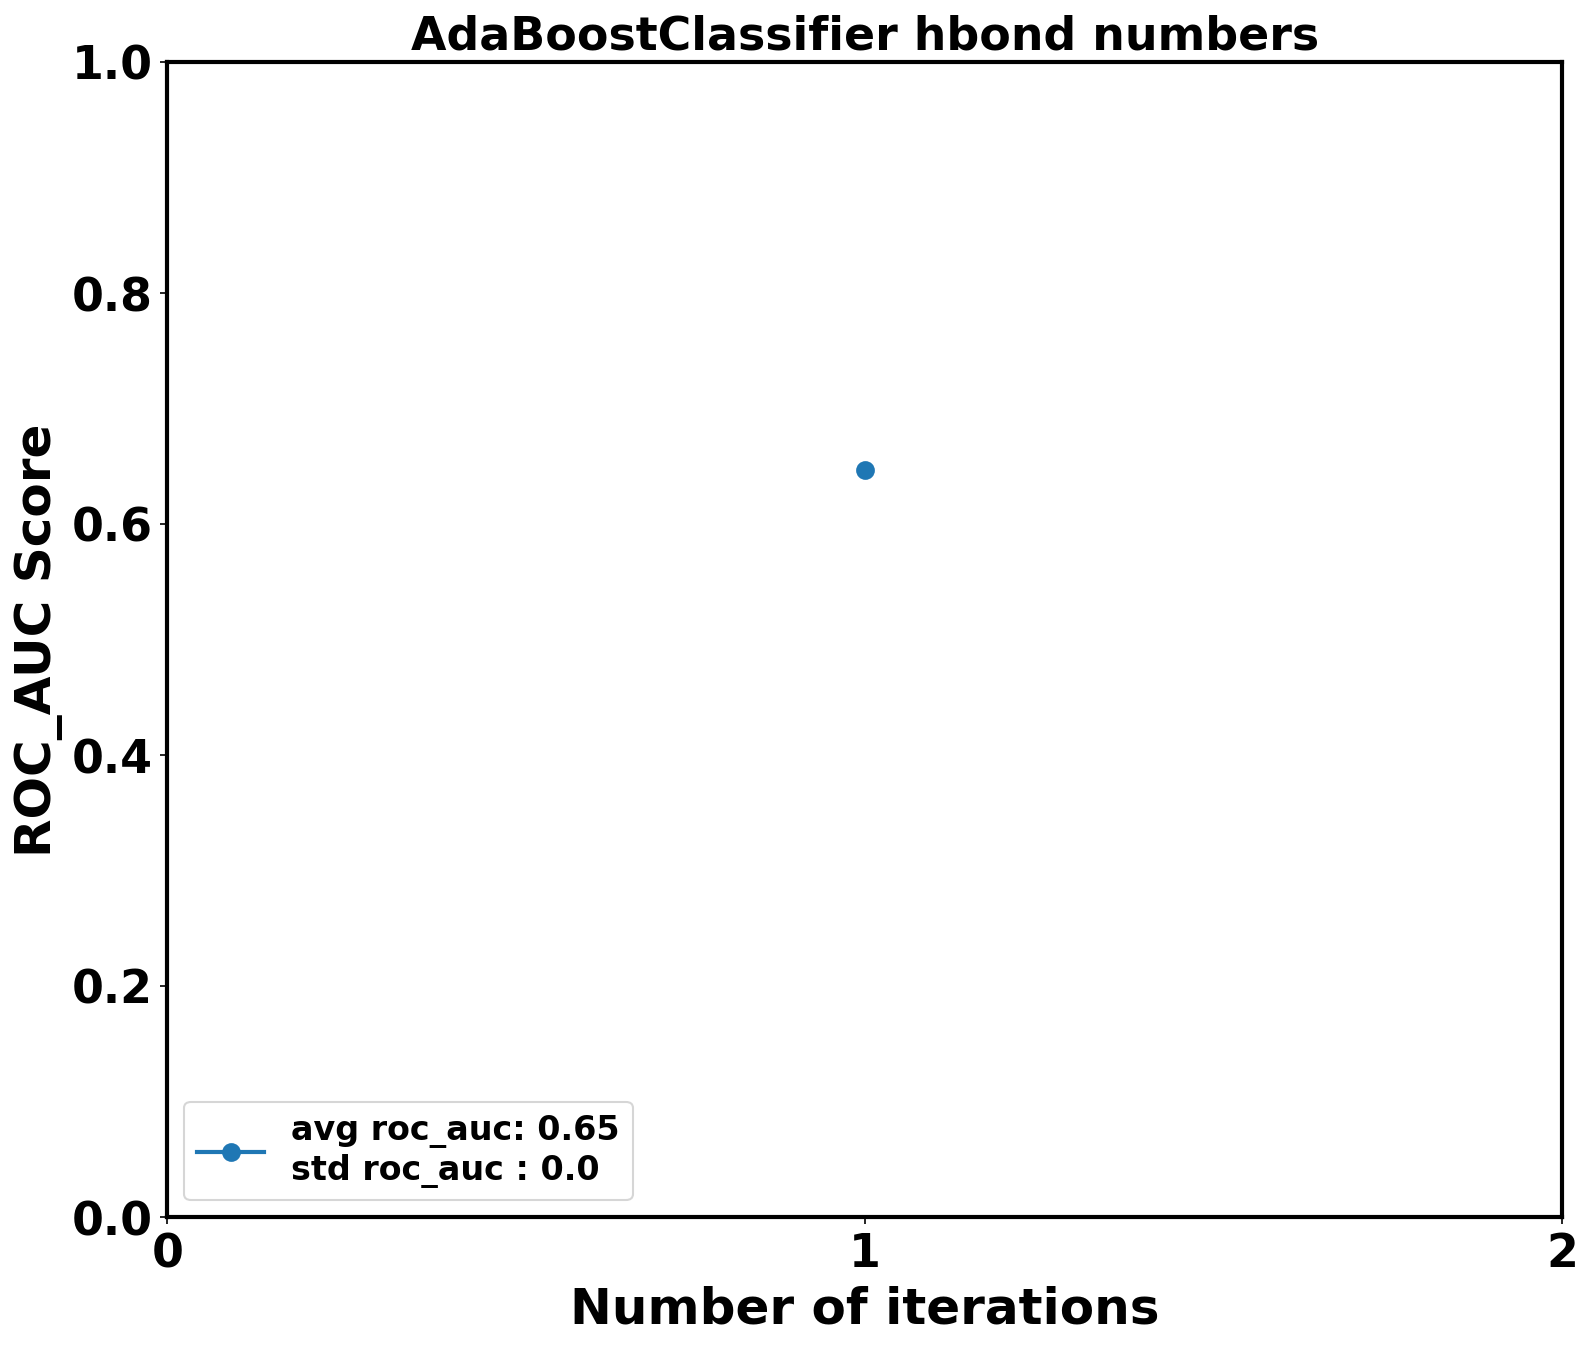

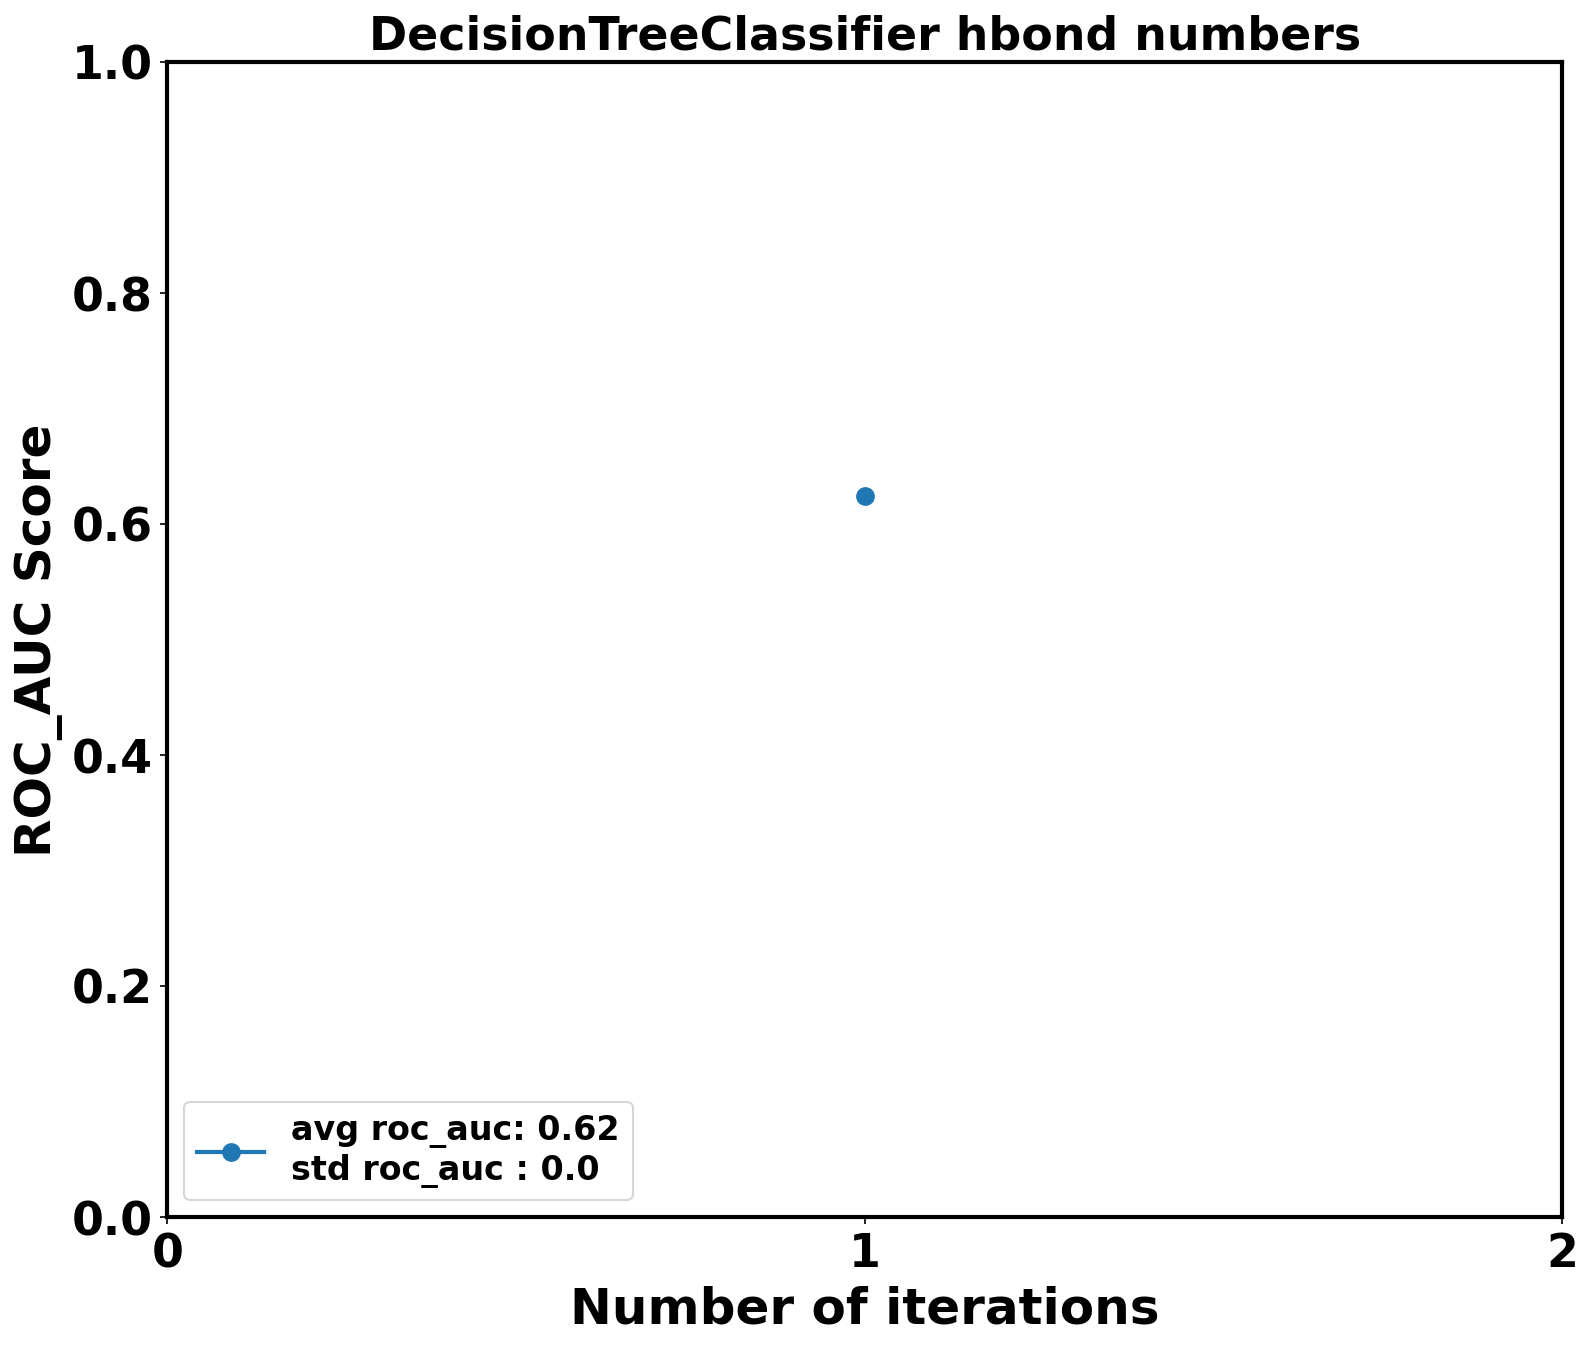

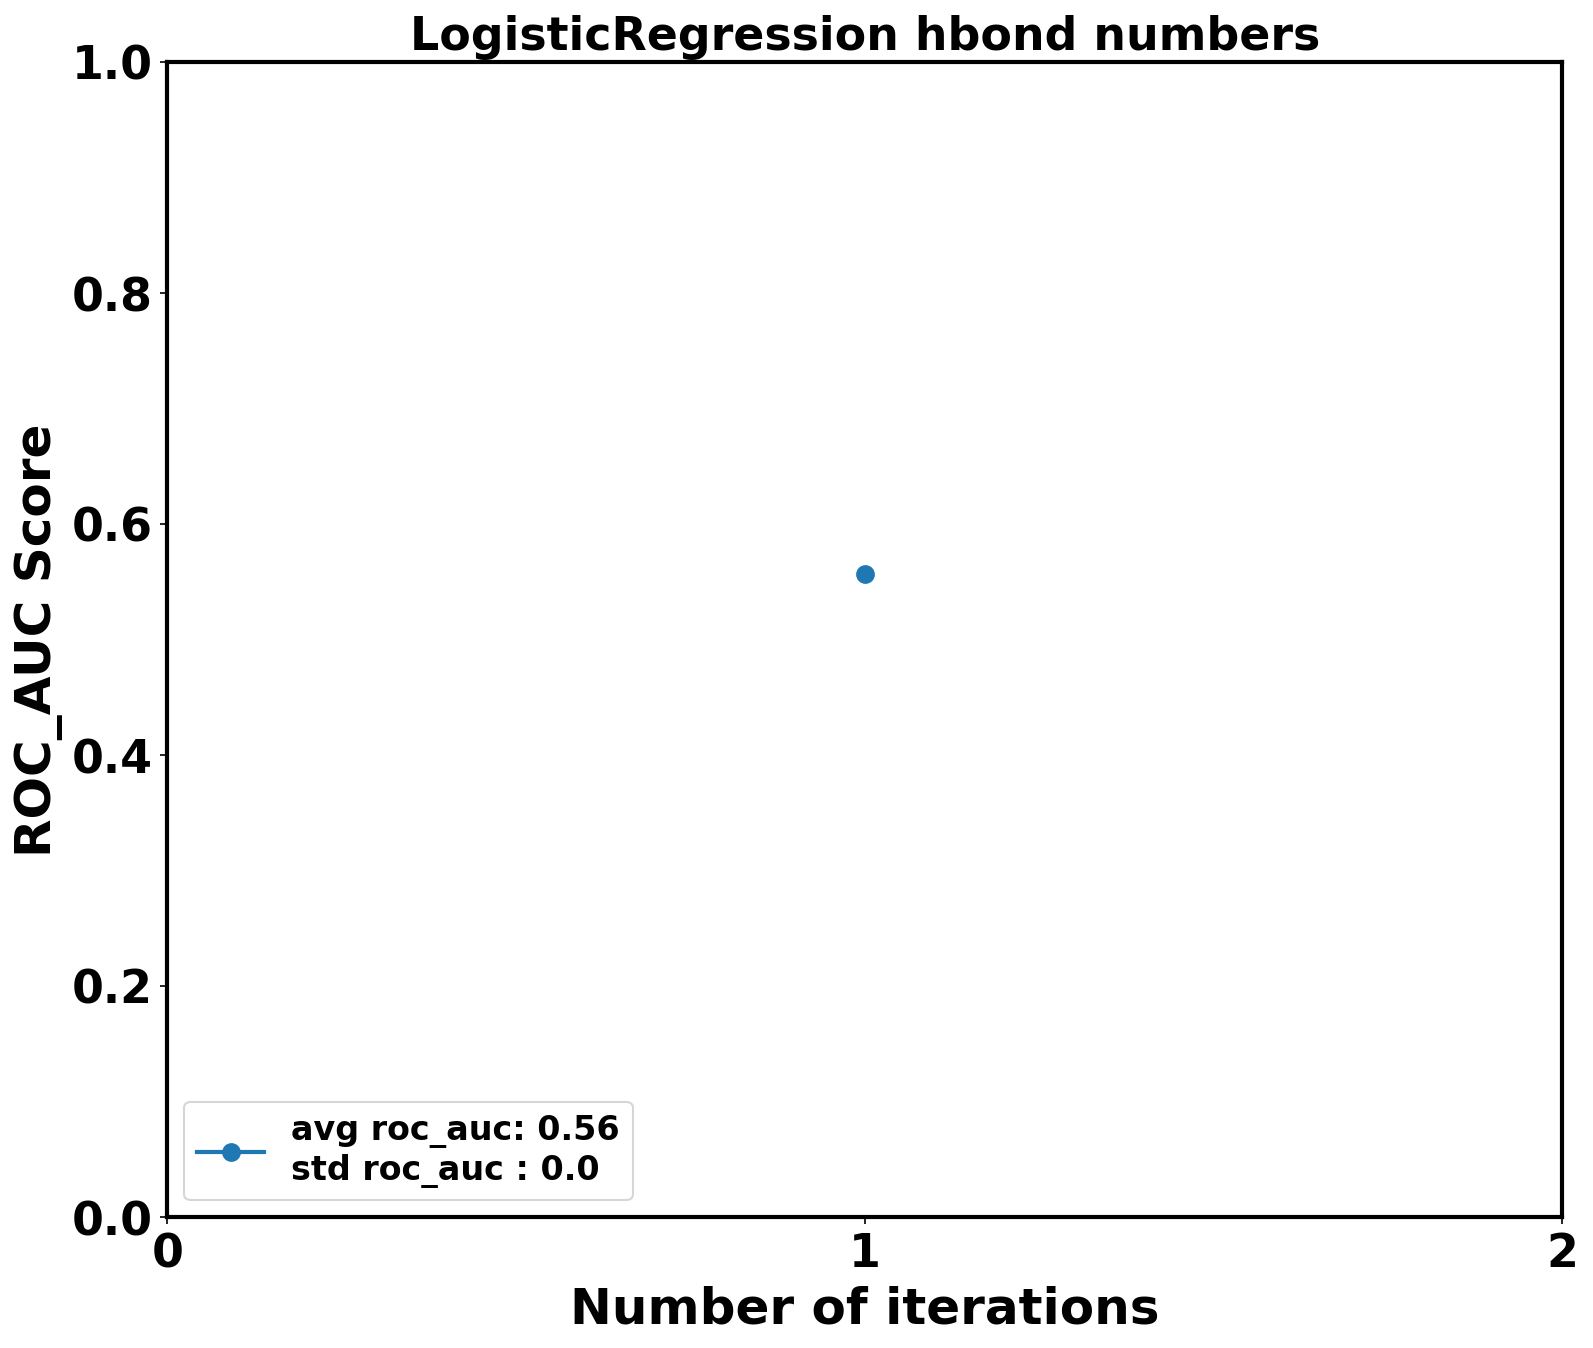

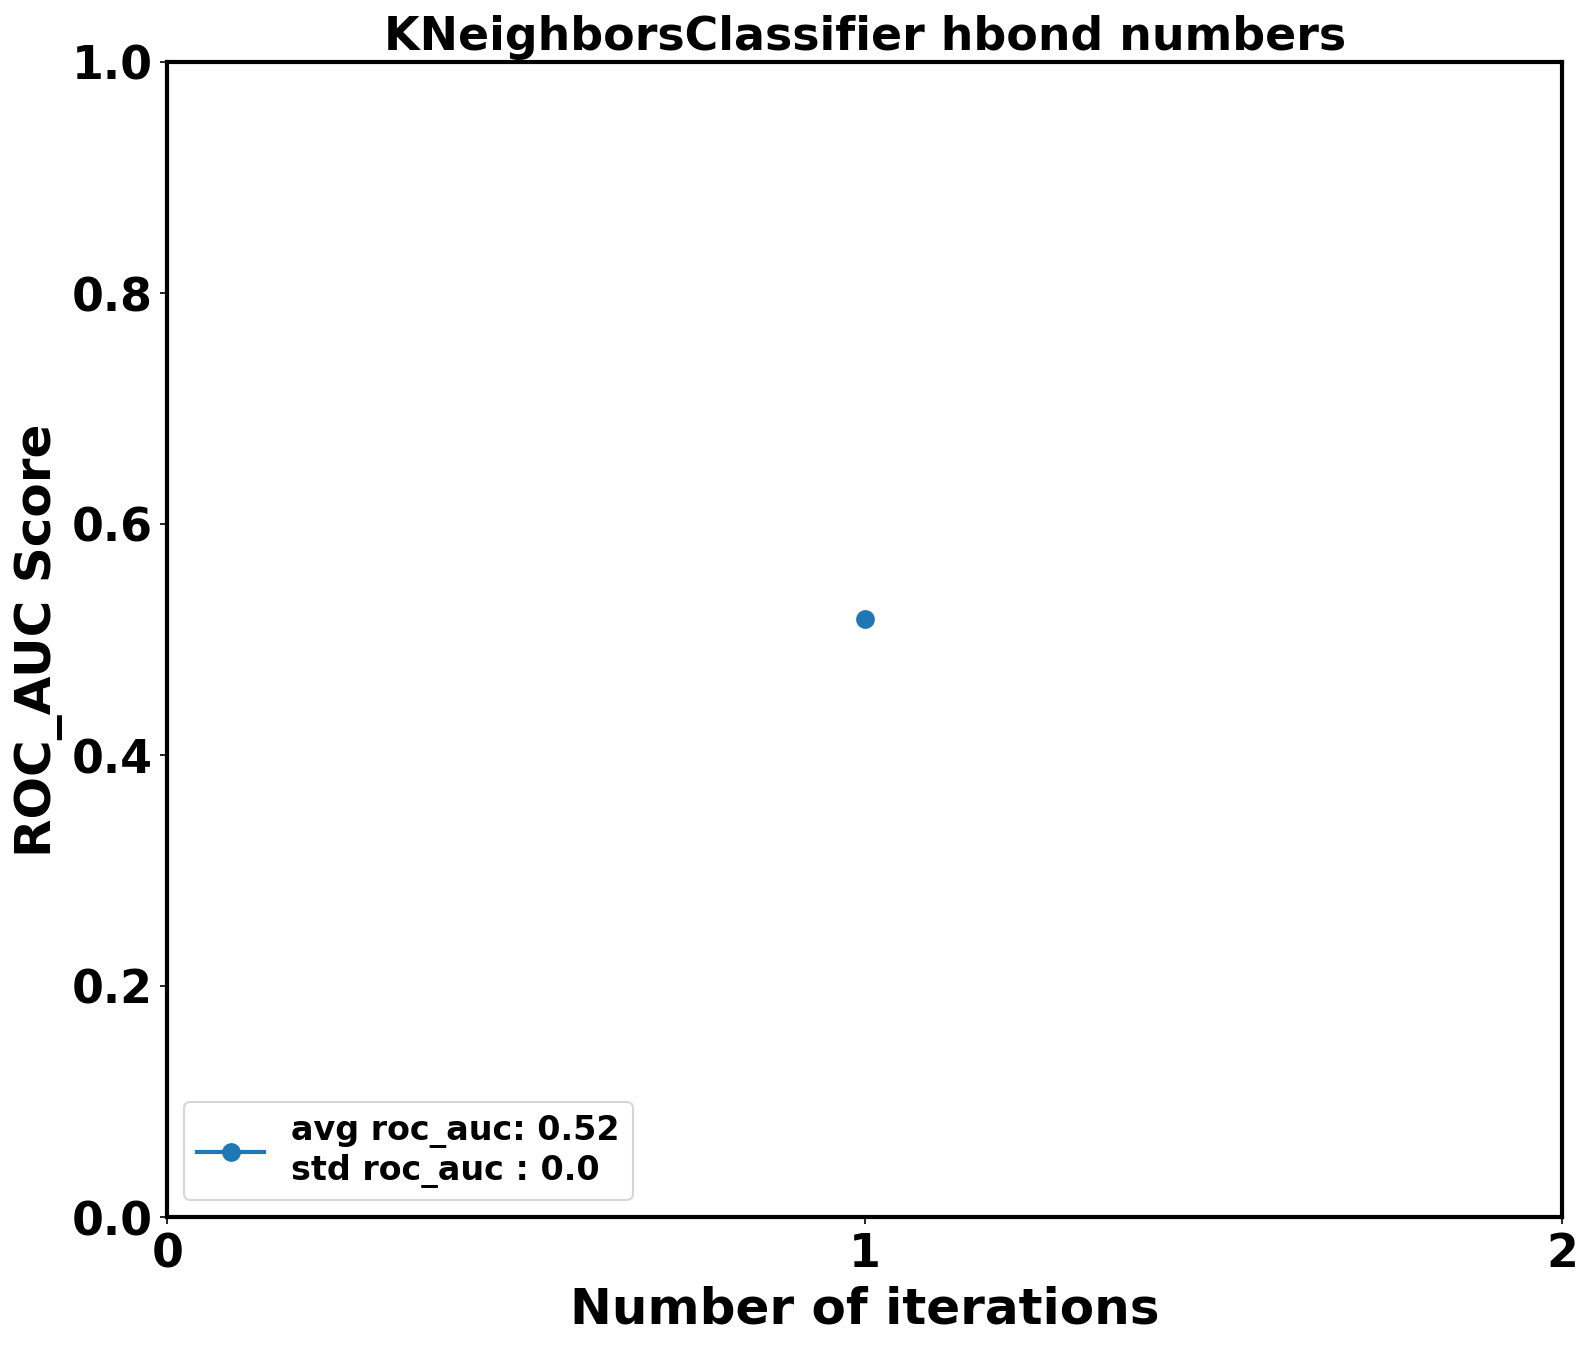

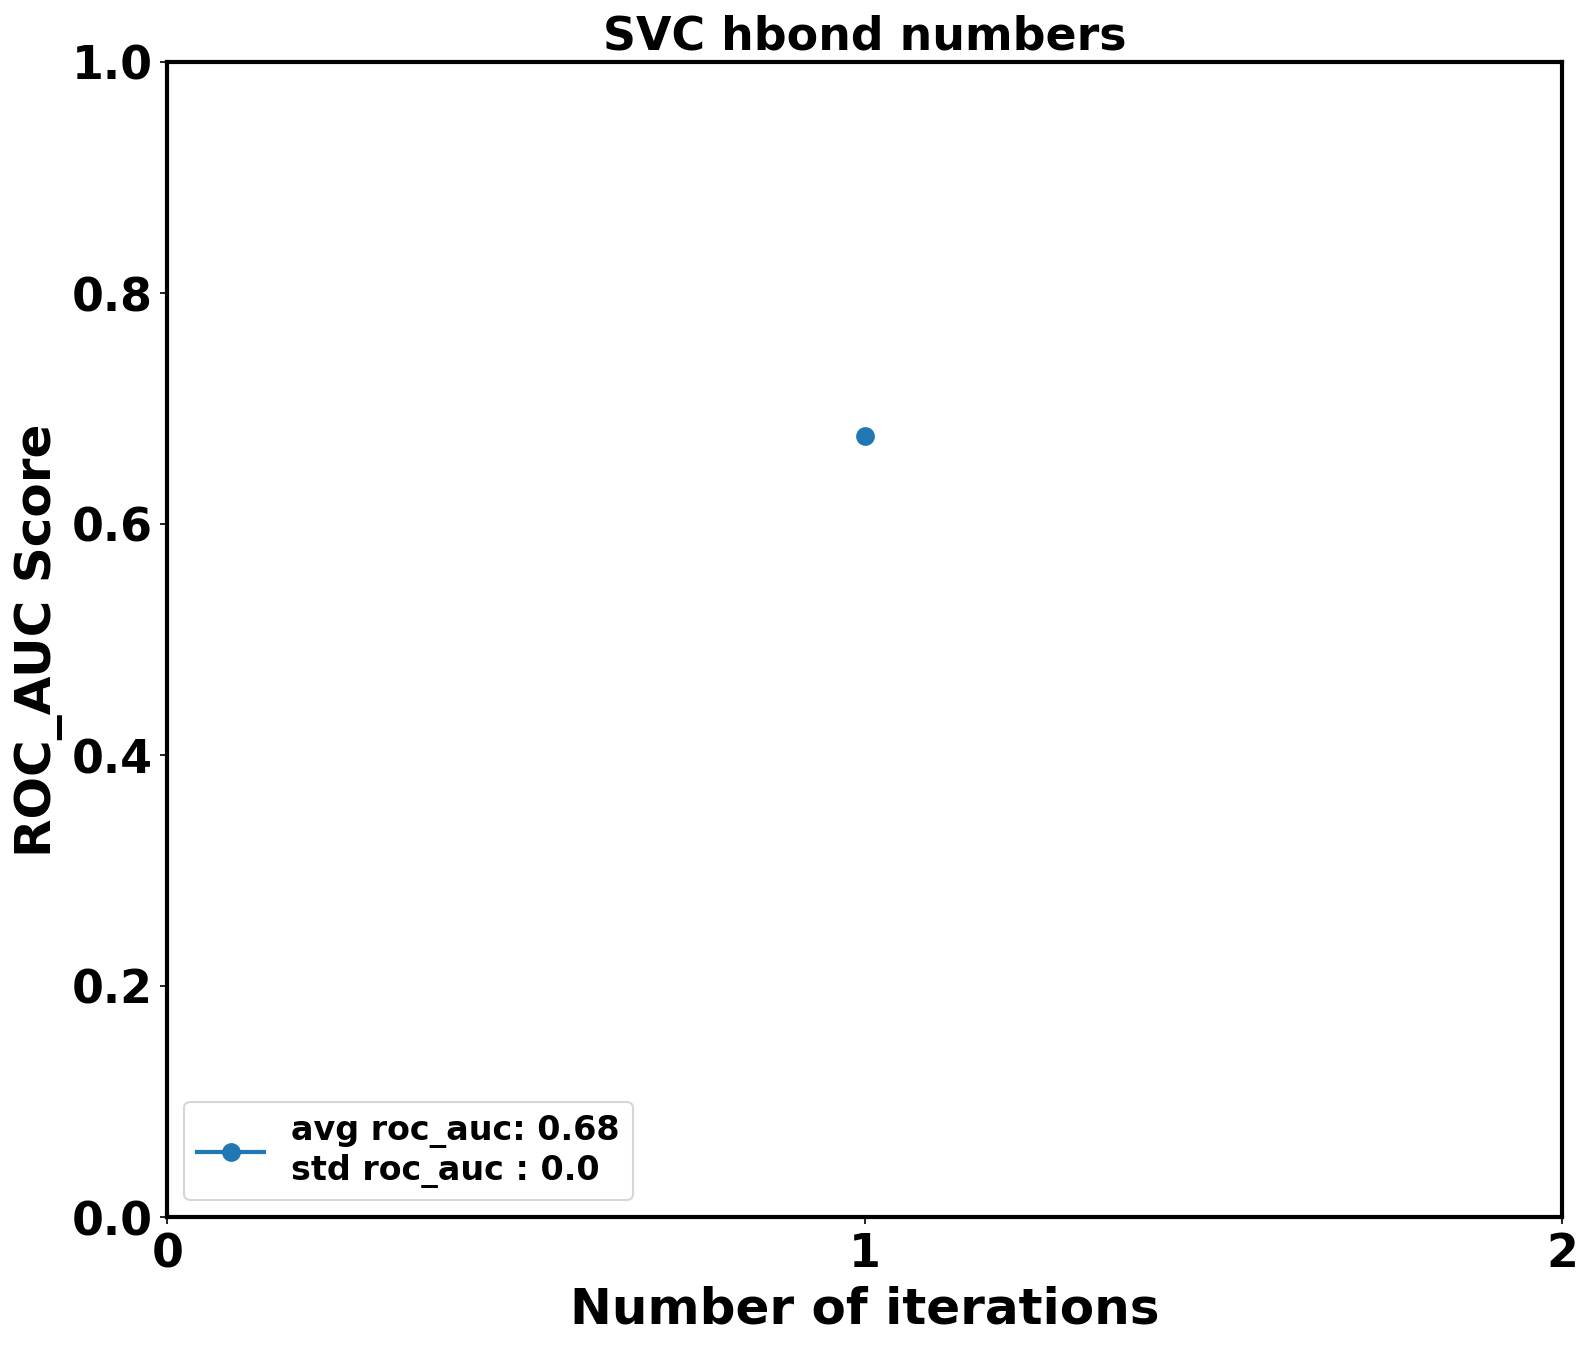

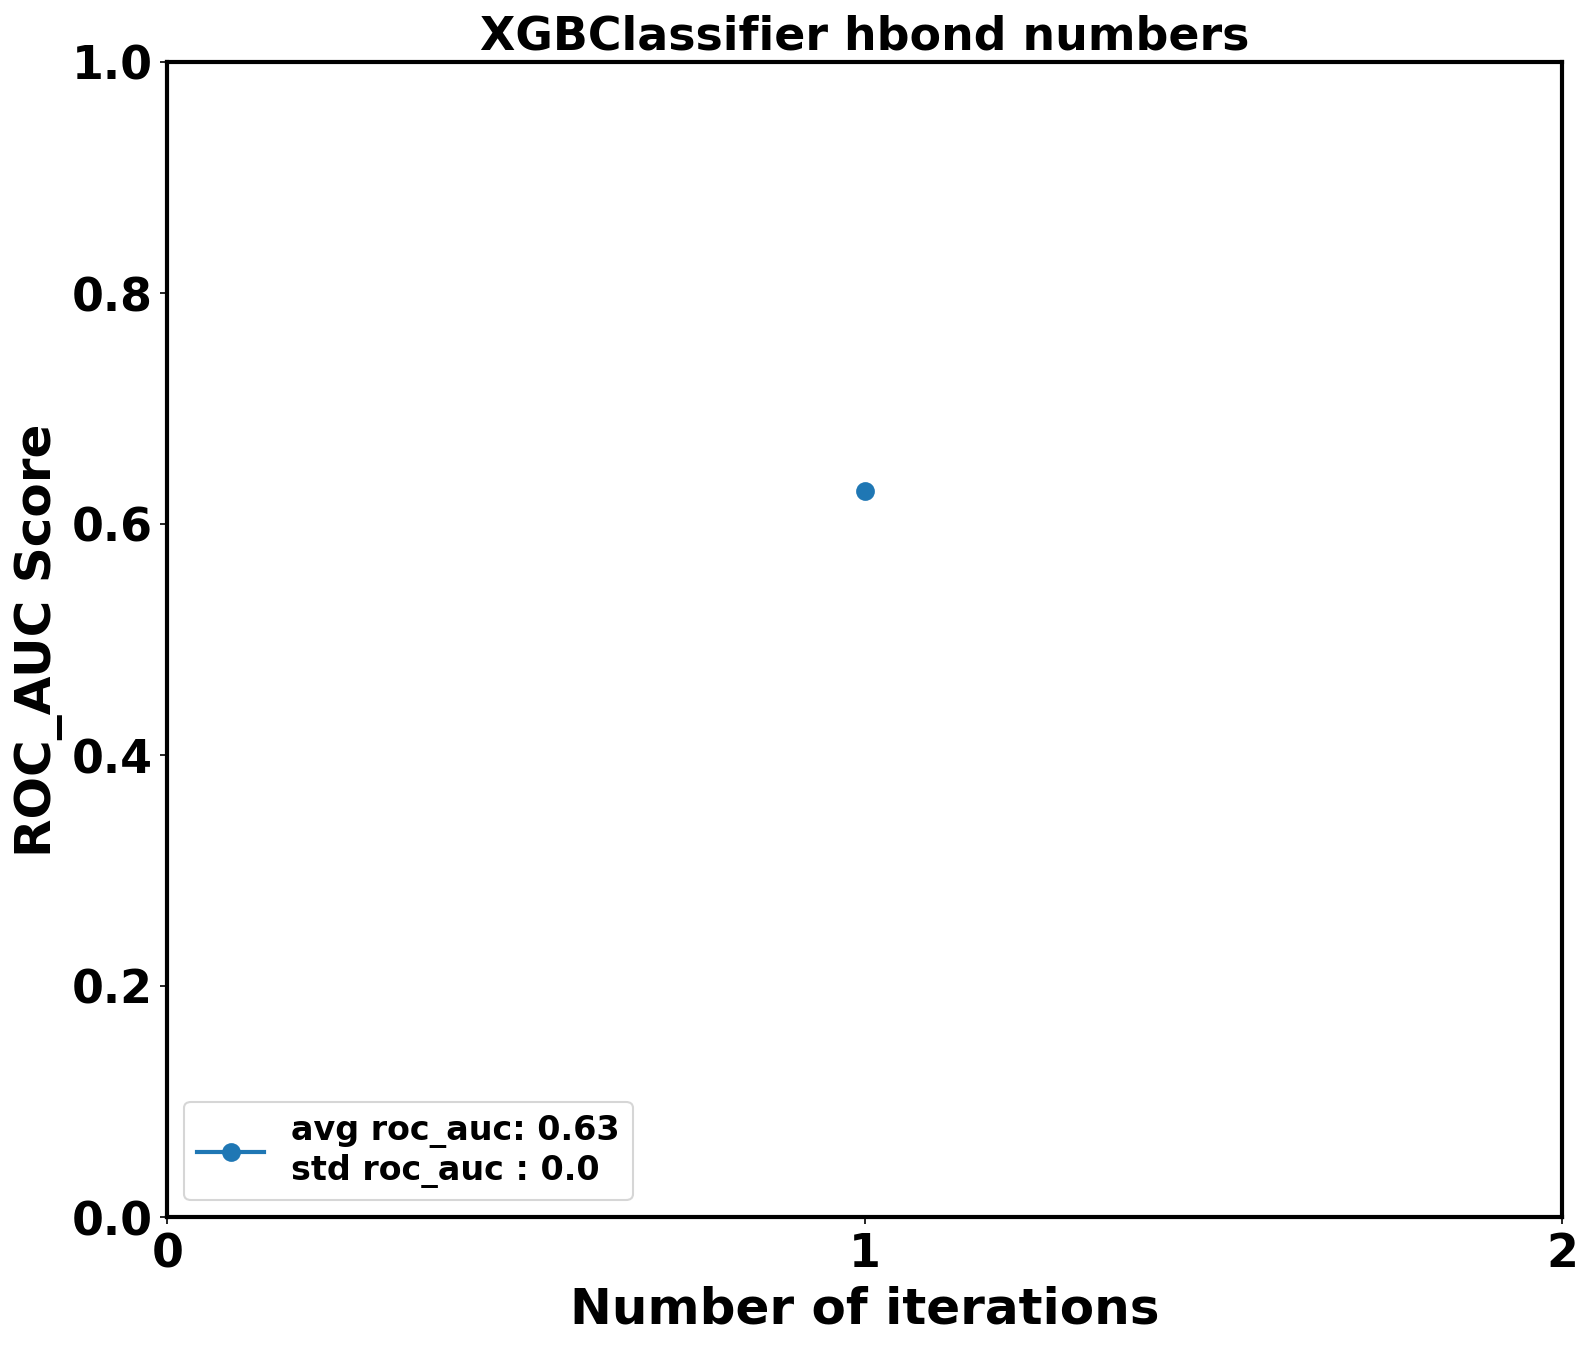

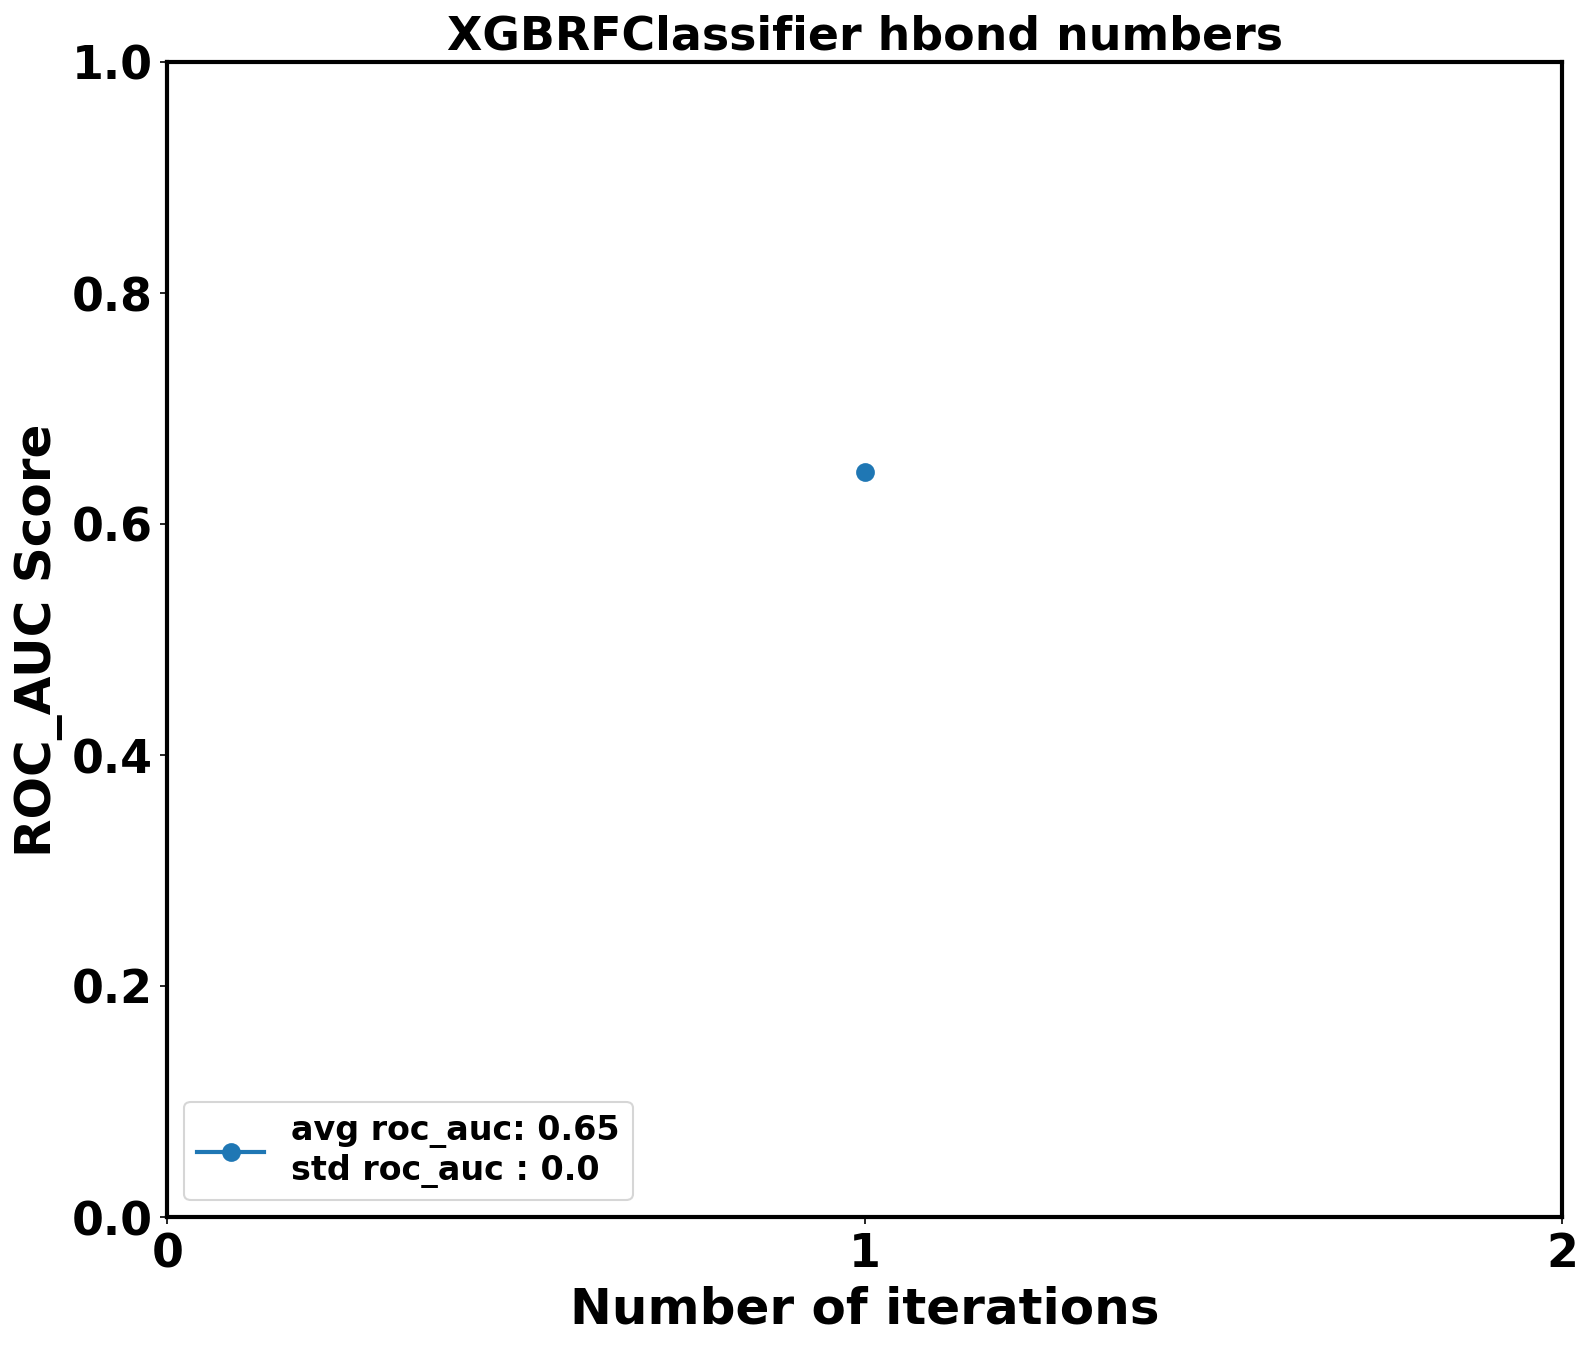

In [135]:
# Validation with lignin

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='hnum'
folder_types = ['hlife', 'hnum', 'merged']
tag = "LR"

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./model-logs/validation/{folder_type}/{xdate}')
    file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_hnum, nondes_df_hnum)   
    validate_trained_models(model_type, X, Y,file_name=file_name, folder_type=folder_type, num=n_repeat, rand_seed=rand_seed)

## Hbond number + lifetime
Models are trained n merged hbond number and lifetime data

#### des

In [99]:
des_df_hlife_edited = des_df_hlife.rename(columns={'A-A': 'A-A_l', 'B-B': 'B-B_l', 'A-B': 'A-B_l',
                                          'A-A/B-B': 'A-A_l/B-B_l', 'A-B/(A-A + B-B)': 'A-B_l/(A-A_l + B-B_l)'})
# des_df_hlife_edited

In [100]:
des_df_hnum_edited = des_df_hnum.rename(columns={'A-A': 'A-A_n', 'B-B': 'B-B_n', 'A-B': 'A-B_n',
                                        'A-A/B-B': 'A-A_n/B-B_n', 'A-B/(A-A + B-B)': 'A-B_n/(A-A_n + B-B_n)'})
# des_df_hnum_edited

#### nondes

In [101]:
nondes_df_hlife_edited = nondes_df_hlife.rename(
    columns={'A-A': 'A-A_l', 'B-B': 'B-B_l', 'A-B': 'A-B_l', 'A-A/B-B': 'A-A_l/B-B_l', 'A-B/(A-A + B-B)': 'A-B_l/(A-A_l + B-B_l)'})
# nondes_df_hlife_edited

In [102]:
nondes_df_hnum_edited = nondes_df_hnum.rename(
    columns={'A-A': 'A-A_n', 'B-B': 'B-B_n', 'A-B': 'A-B_n', 'A-A/B-B': 'A-A_n/B-B_n', 'A-B/(A-A + B-B)': 'A-B_n/(A-A_n + B-B_n)'})
# nondes_df_hnum_edited

#### merged

In [107]:
des_df_hnum_edited = des_df_hnum_edited.drop(columns=['output'])
des_df_merged_list = [des_df_hnum_edited, des_df_hlife_edited]
des_df_merged = pd.concat(des_df_merged_list, axis=1)
des_df_merged

,A-A_n,B-B_n,A-B_n,A-A_n/B-B_n,A-B_n/(A-A_n + B-B_n),A-A_l,B-B_l,A-B_l,A-A_l/B-B_l,A-B_l/(A-A_l + B-B_l),output
0,8.405594,22.092907,30.725275,0.380466,1.007436,2.471595,3.733872,3.380121,0.661939,0.544701,1
1,15.329670,0.770230,18.419580,19.902724,1.144080,3.407539,0.483807,3.221856,7.043183,0.827954,1
2,6.903097,29.975025,33.074925,0.230295,0.896871,2.534453,2.204221,2.777686,1.149818,0.586174,1
3,13.204795,2.059940,20.208791,6.410281,1.323887,3.723772,1.914069,3.239760,1.945475,0.574646,1
4,5.362637,52.633367,34.727273,0.101887,0.598787,2.677184,1.205634,2.302465,2.220561,0.592988,1
5,7.165834,5.254745,48.160839,1.363688,3.877503,2.518668,1.267136,3.882003,1.987686,1.025410,1
6,2.206793,20.933067,52.064935,0.105421,2.250011,2.467704,2.214447,4.013772,1.114365,0.857250,1
7,47.078921,2.828172,58.005994,16.646415,1.162280,2.705312,0.500789,3.676830,5.402096,1.146823,1
8,19.658342,11.382617,40.727273,1.727049,1.312049,1.420395,0.730024,1.664087,1.945682,0.773843,1
9,8.469530,33.392607,54.238761,0.253635,1.295652,1.381339,0.566631,1.556223,2.437813,0.798895,1


In [108]:
nondes_df_hnum_edited = nondes_df_hnum_edited.drop(columns=['output'])
nondes_df_merged_list = [nondes_df_hnum_edited, nondes_df_hlife_edited]
nondes_df_merged = pd.concat(nondes_df_merged_list, axis=1)
nondes_df_merged

,A-A_n,B-B_n,A-B_n,A-A_n/B-B_n,A-B_n/(A-A_n + B-B_n),A-A_l,B-B_l,A-B_l,A-A_l/B-B_l,A-B_l/(A-A_l + B-B_l),output
0,4.112887,22.075924,40.374625,0.186306,1.541675,3.385798,3.155948,3.796678,1.072831,0.580377,0
1,15.170829,0.695305,13.884116,21.818966,0.875079,2.849065,1.202049,3.117173,2.370173,0.769461,0
2,29.220779,35.496503,53.883117,0.823202,0.832592,2.548177,2.454365,1.991729,1.038223,0.398143,0
3,23.880120,36.495504,52.185814,0.654330,0.864352,1.591568,0.932191,1.228077,1.707342,0.486606,0
4,19.677323,33.202797,53.625375,0.592641,1.014093,3.592210,3.197229,2.905294,1.123539,0.427914,0
5,28.627373,14.524476,24.582418,1.970975,0.569672,3.059960,2.043980,2.156269,1.497060,0.422471,0
6,31.319680,13.295704,20.875125,2.355624,0.467891,2.283029,1.045423,1.294826,2.183833,0.389018,0
7,28.134865,23.941059,47.306693,1.175172,0.908418,3.076017,2.779366,3.105455,1.106733,0.530359,0
8,4.645355,37.891109,55.707293,0.122597,1.309636,2.682118,3.330352,3.830274,0.805356,0.637055,0
9,8.237762,33.521479,53.111888,0.245746,1.271860,2.734466,1.777658,3.015204,1.538241,0.668245,0


In [109]:
data_validate(des_df_merged, nondes_df_merged) 

(array([[ 4.4985015 , 26.58541459, 32.1958042 ,  0.16920938,  1.03577053,
          1.81418826,  2.30592659,  3.02853105,  0.78675022,  0.73505986],
        [29.25774226,  3.37962038, 24.75324675,  8.65710907,  0.75843281,
          0.92818704,  0.39196066,  0.94414844,  2.36806173,  0.71518394],
        [ 8.46053946, 10.65534466, 24.27272727,  0.79401838,  1.26976744,
          1.43198264,  1.97424511,  1.99092112,  0.72533174,  0.58449442],
        [13.2047952 ,  2.05994006, 20.20879121,  6.41028128,  1.32388743,
          3.72377215,  1.91406851,  3.23976045,  1.94547486,  0.57464562],
        [15.65634366, 12.51148851, 27.24075924,  1.25135739,  0.96708753,
          2.7621959 ,  0.85004967,  1.43747611,  3.24945234,  0.39794529],
        [57.32267732,  5.78321678, 56.63036963,  9.91190188,  0.89738638,
          1.82773932,  1.00862613,  2.01430285,  1.81210784,  0.71017042],
        [14.23176823,  3.33866134, 28.49250749,  4.26271694,  1.62161701,
          3.65186392,  1.0373485

## Validation

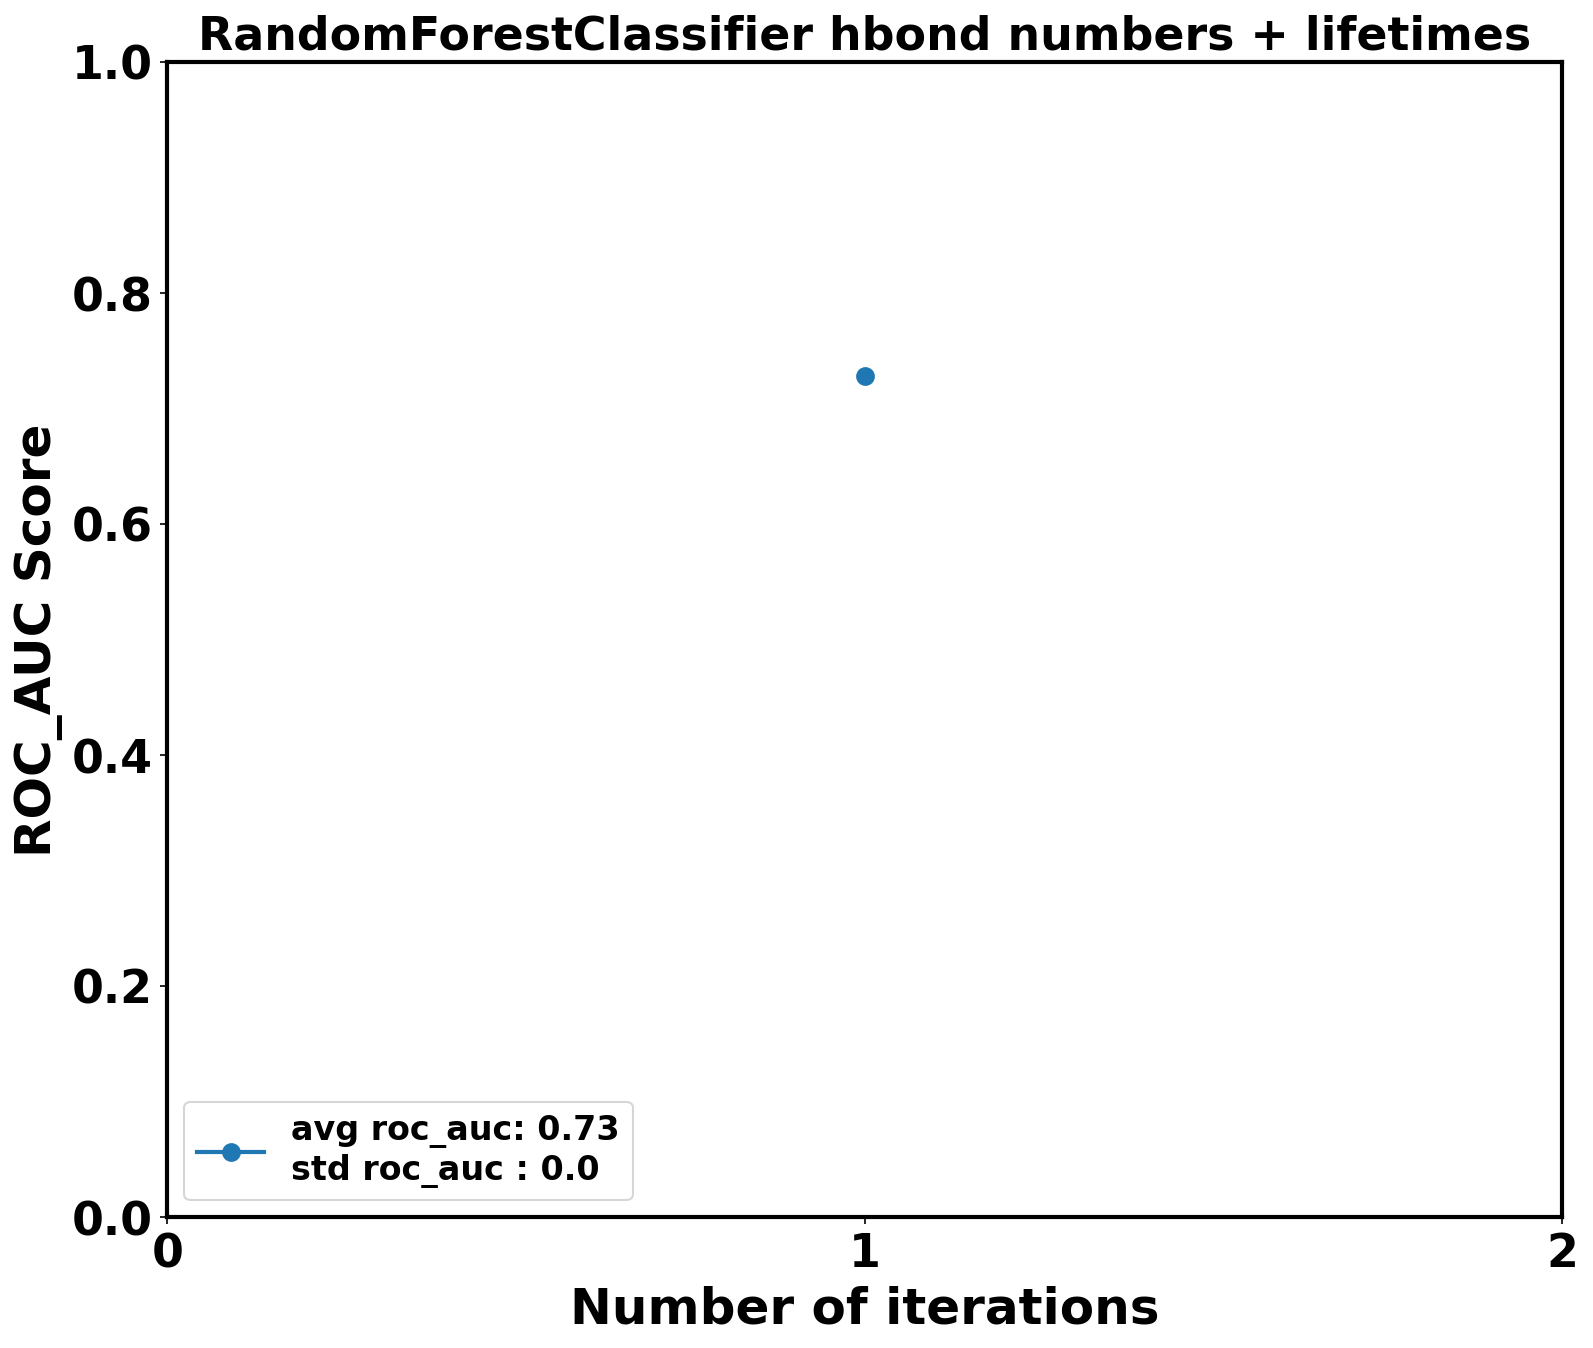

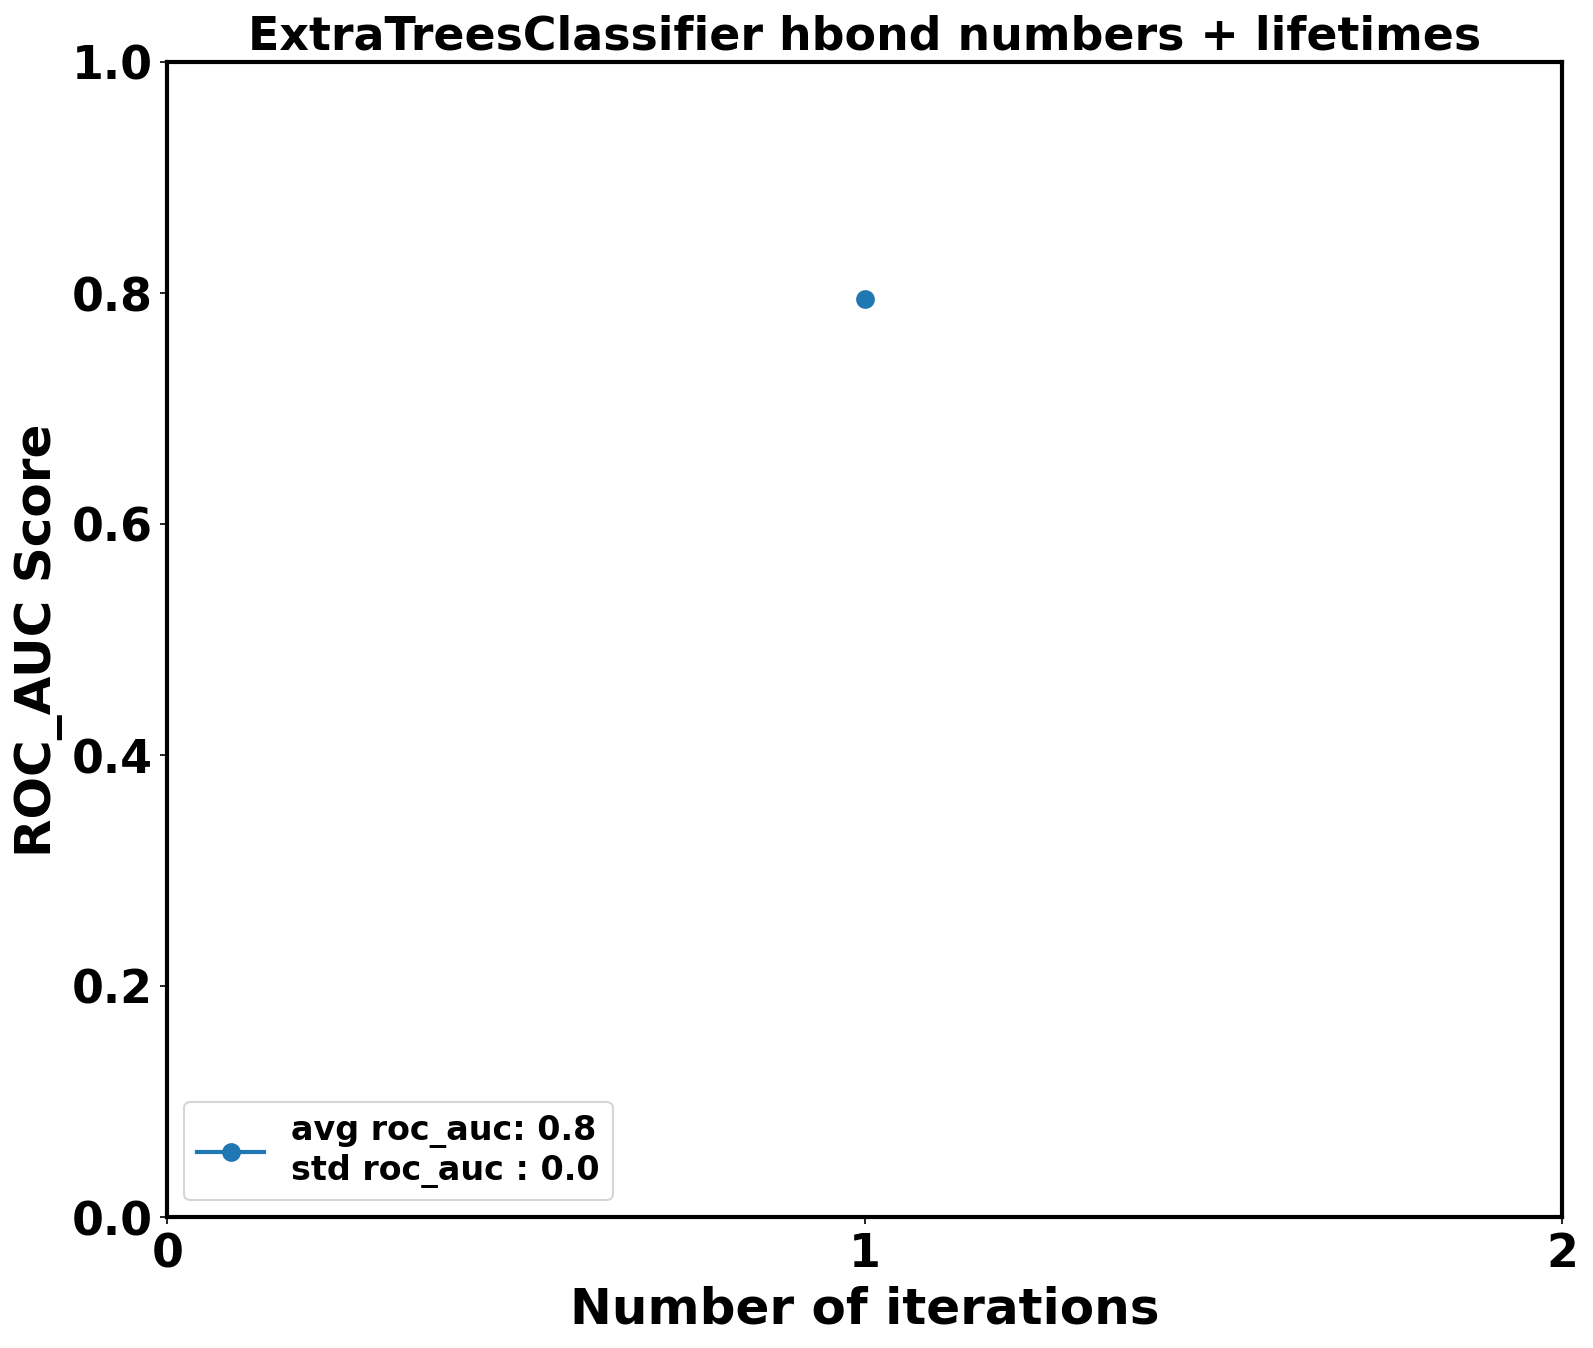

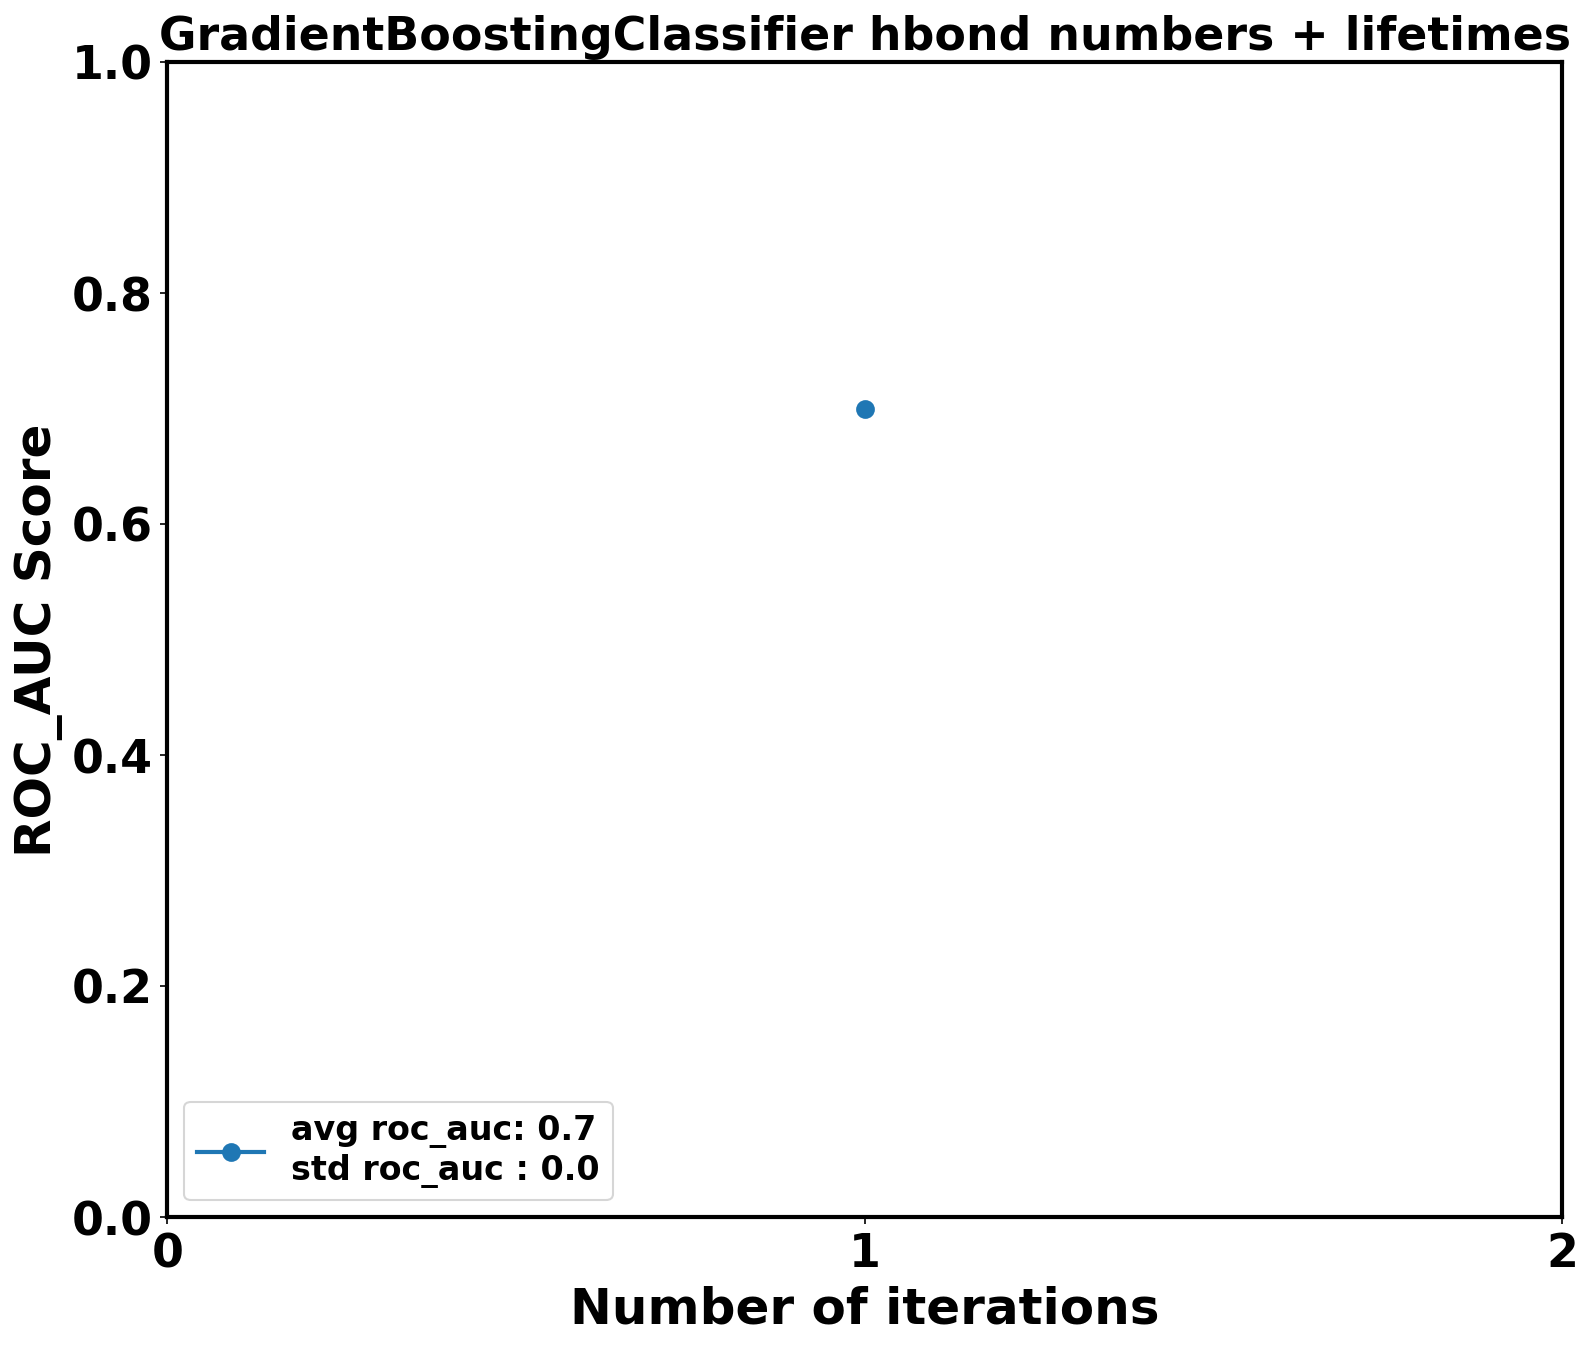

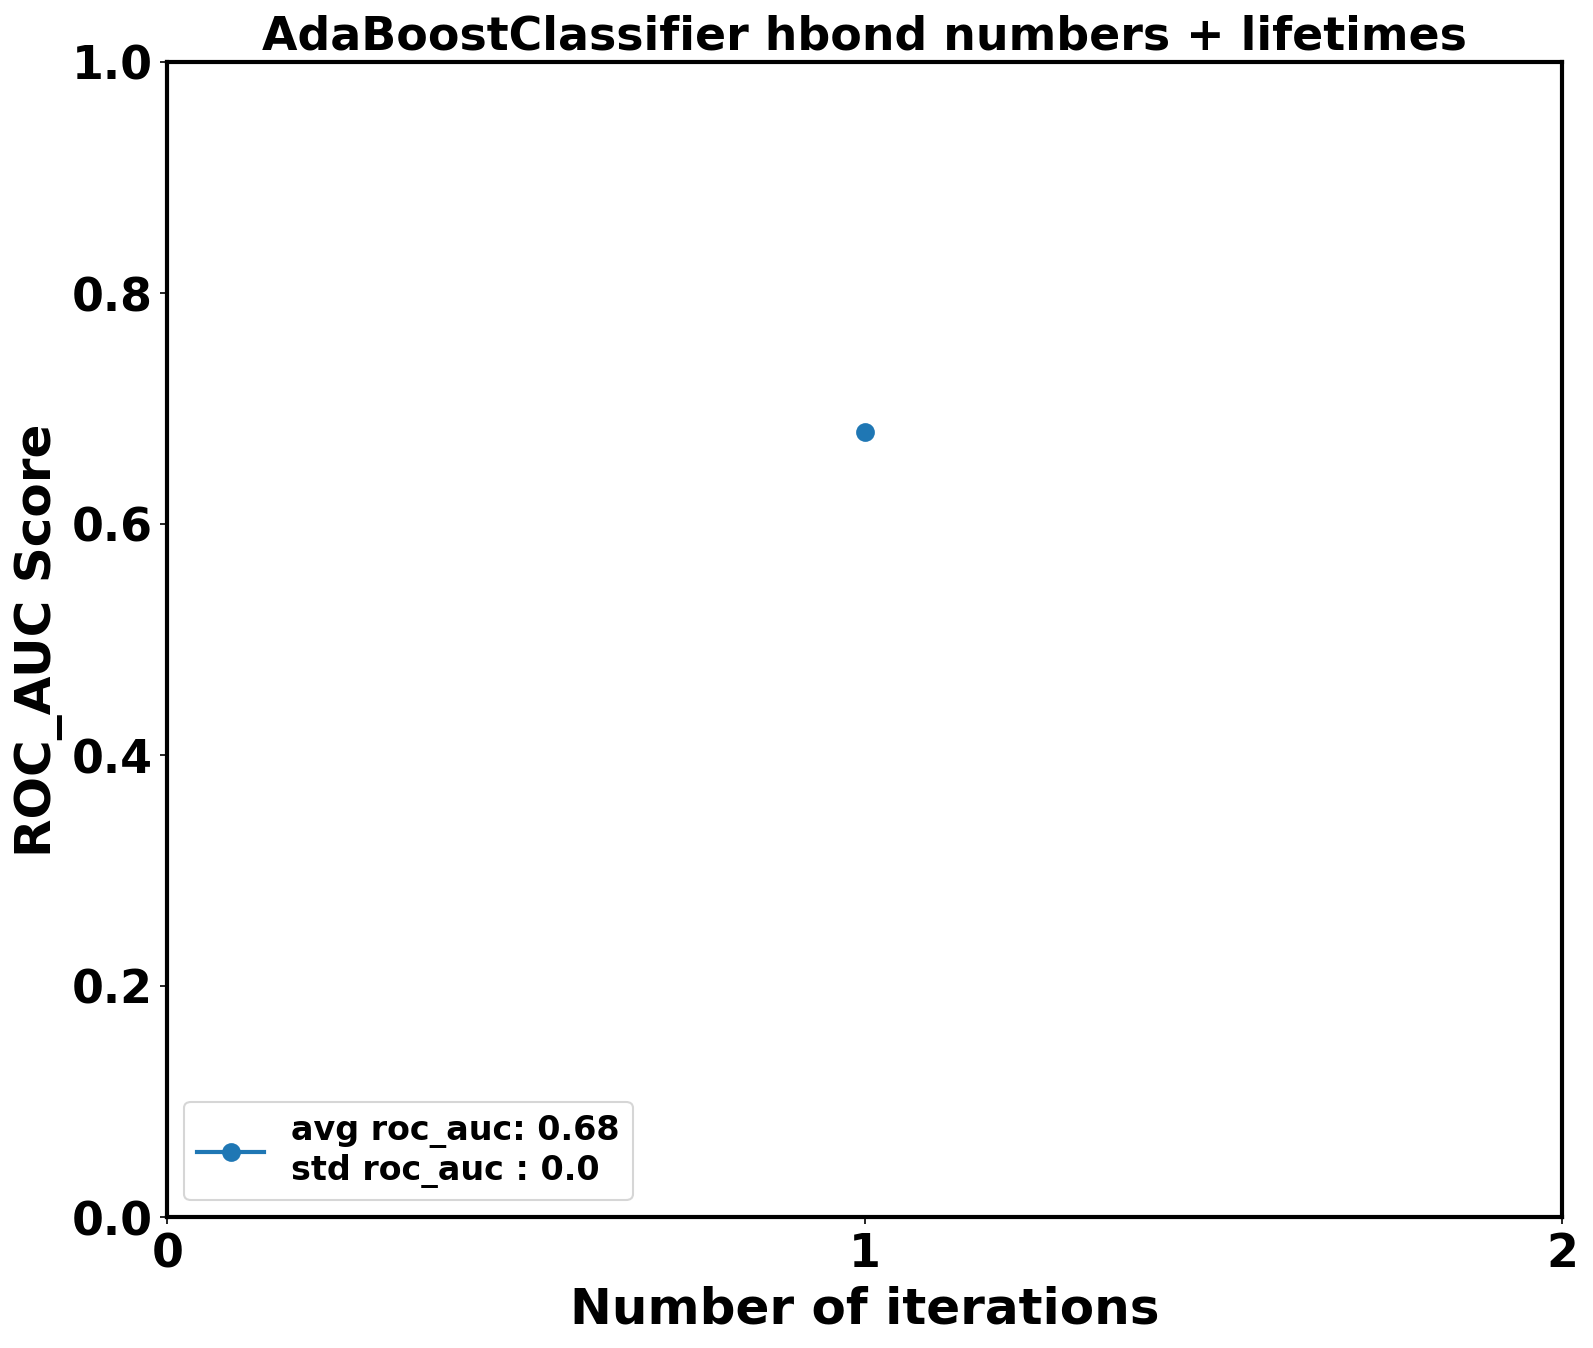

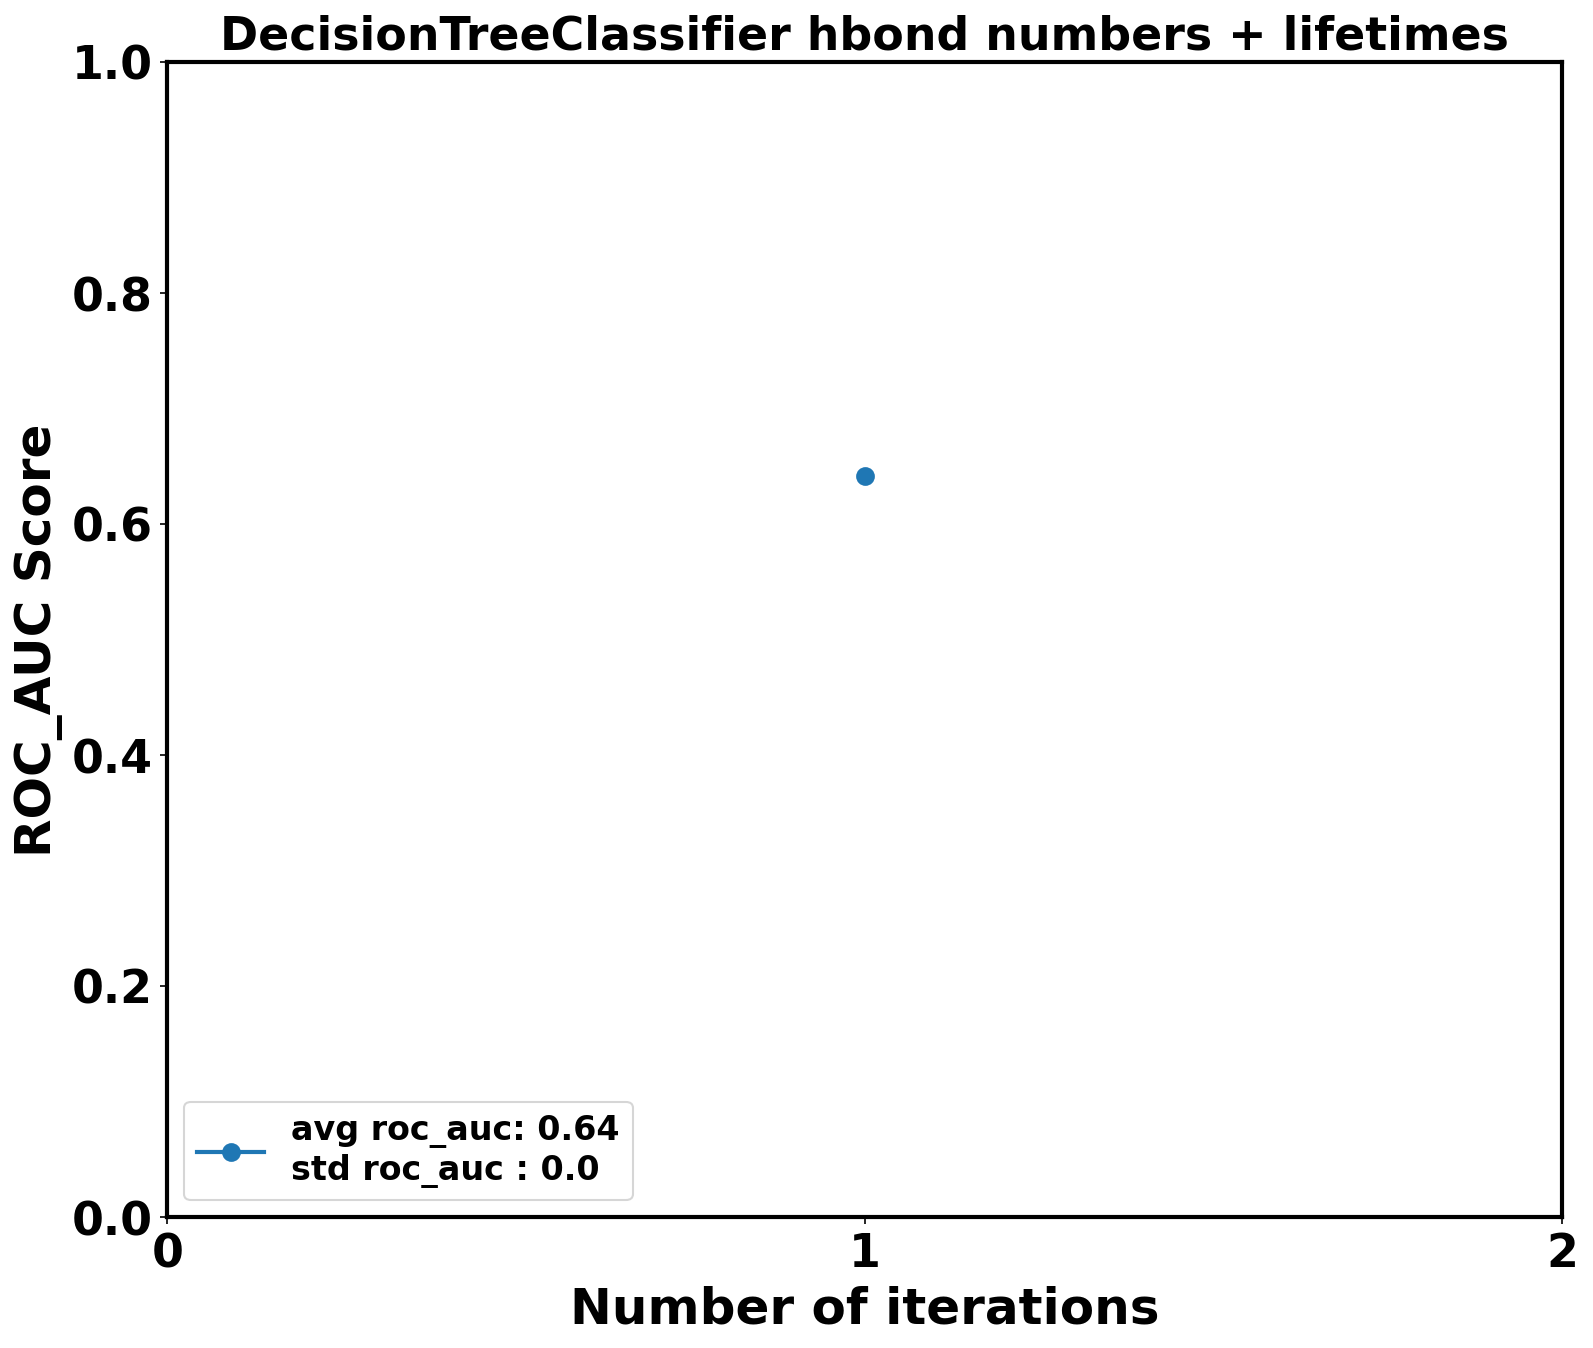

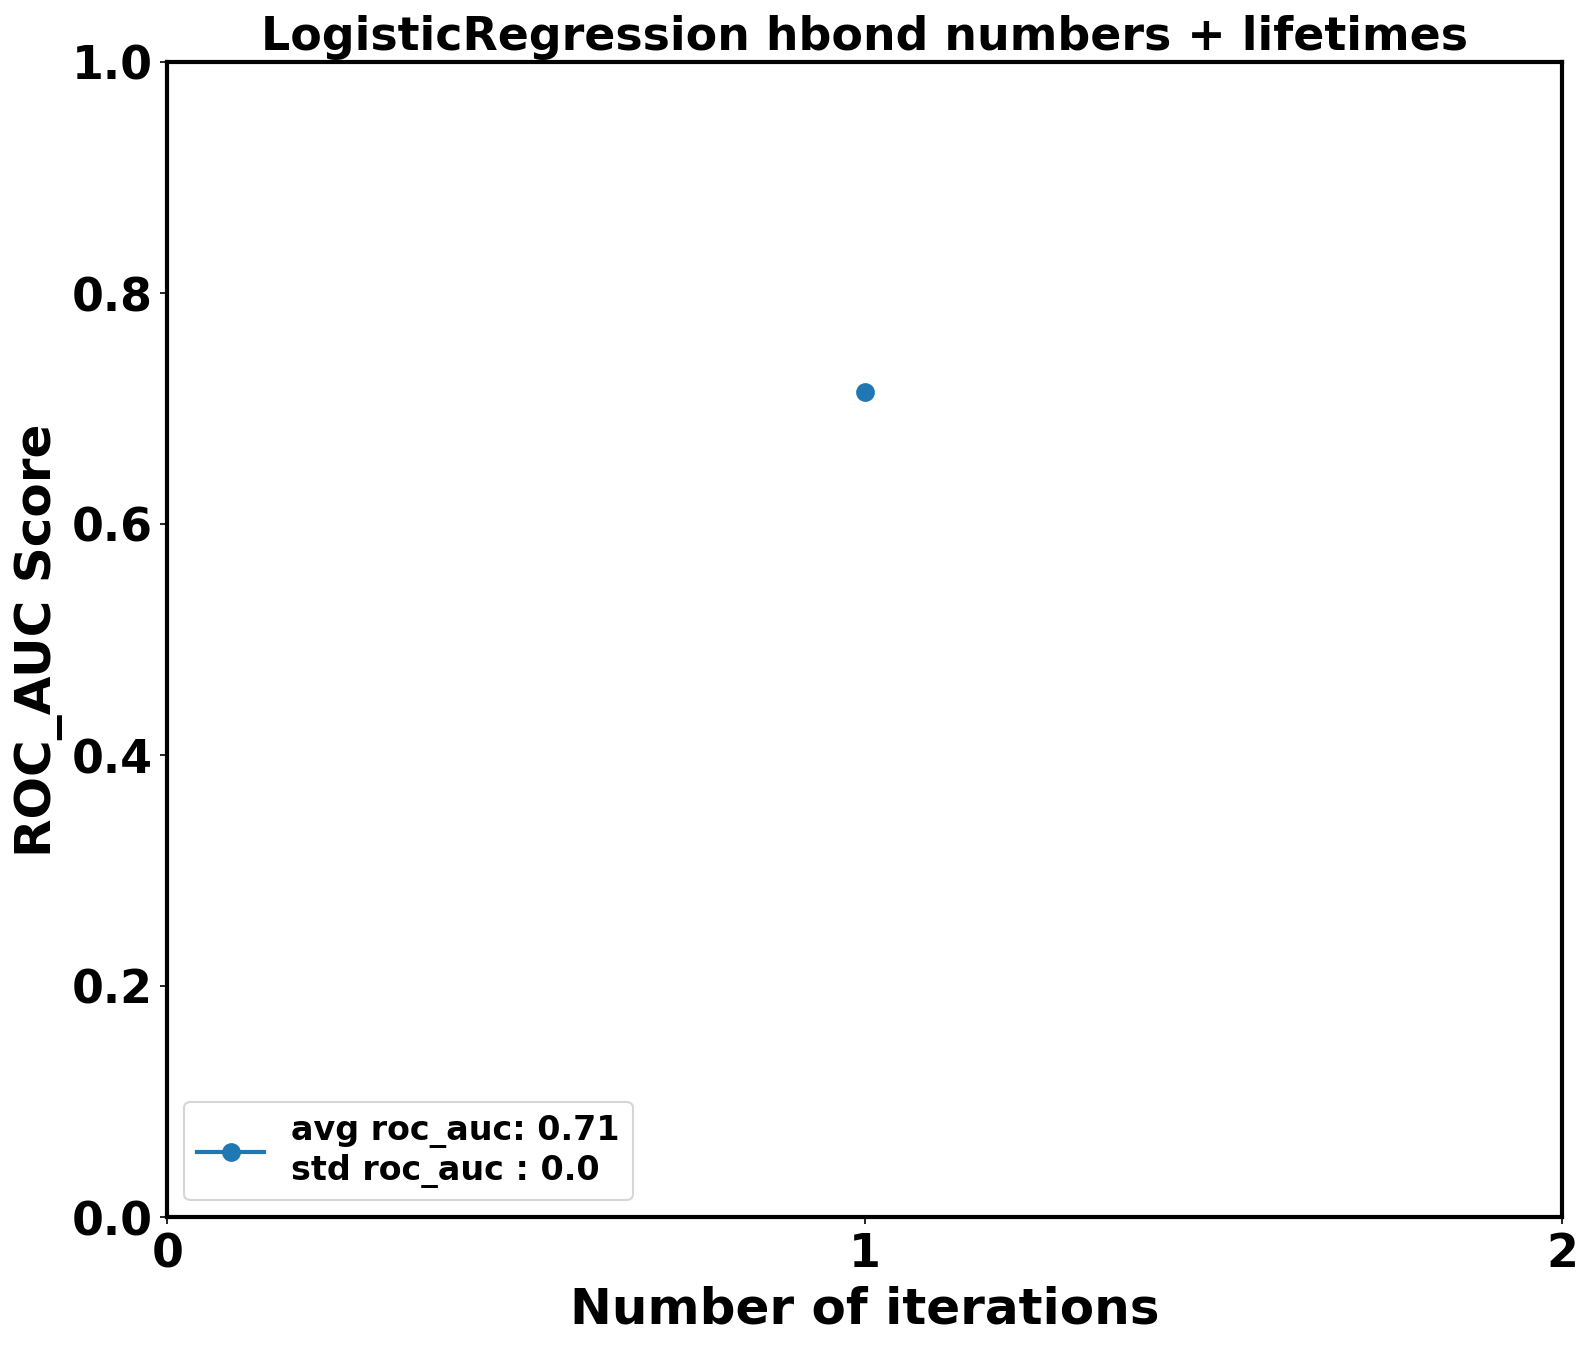

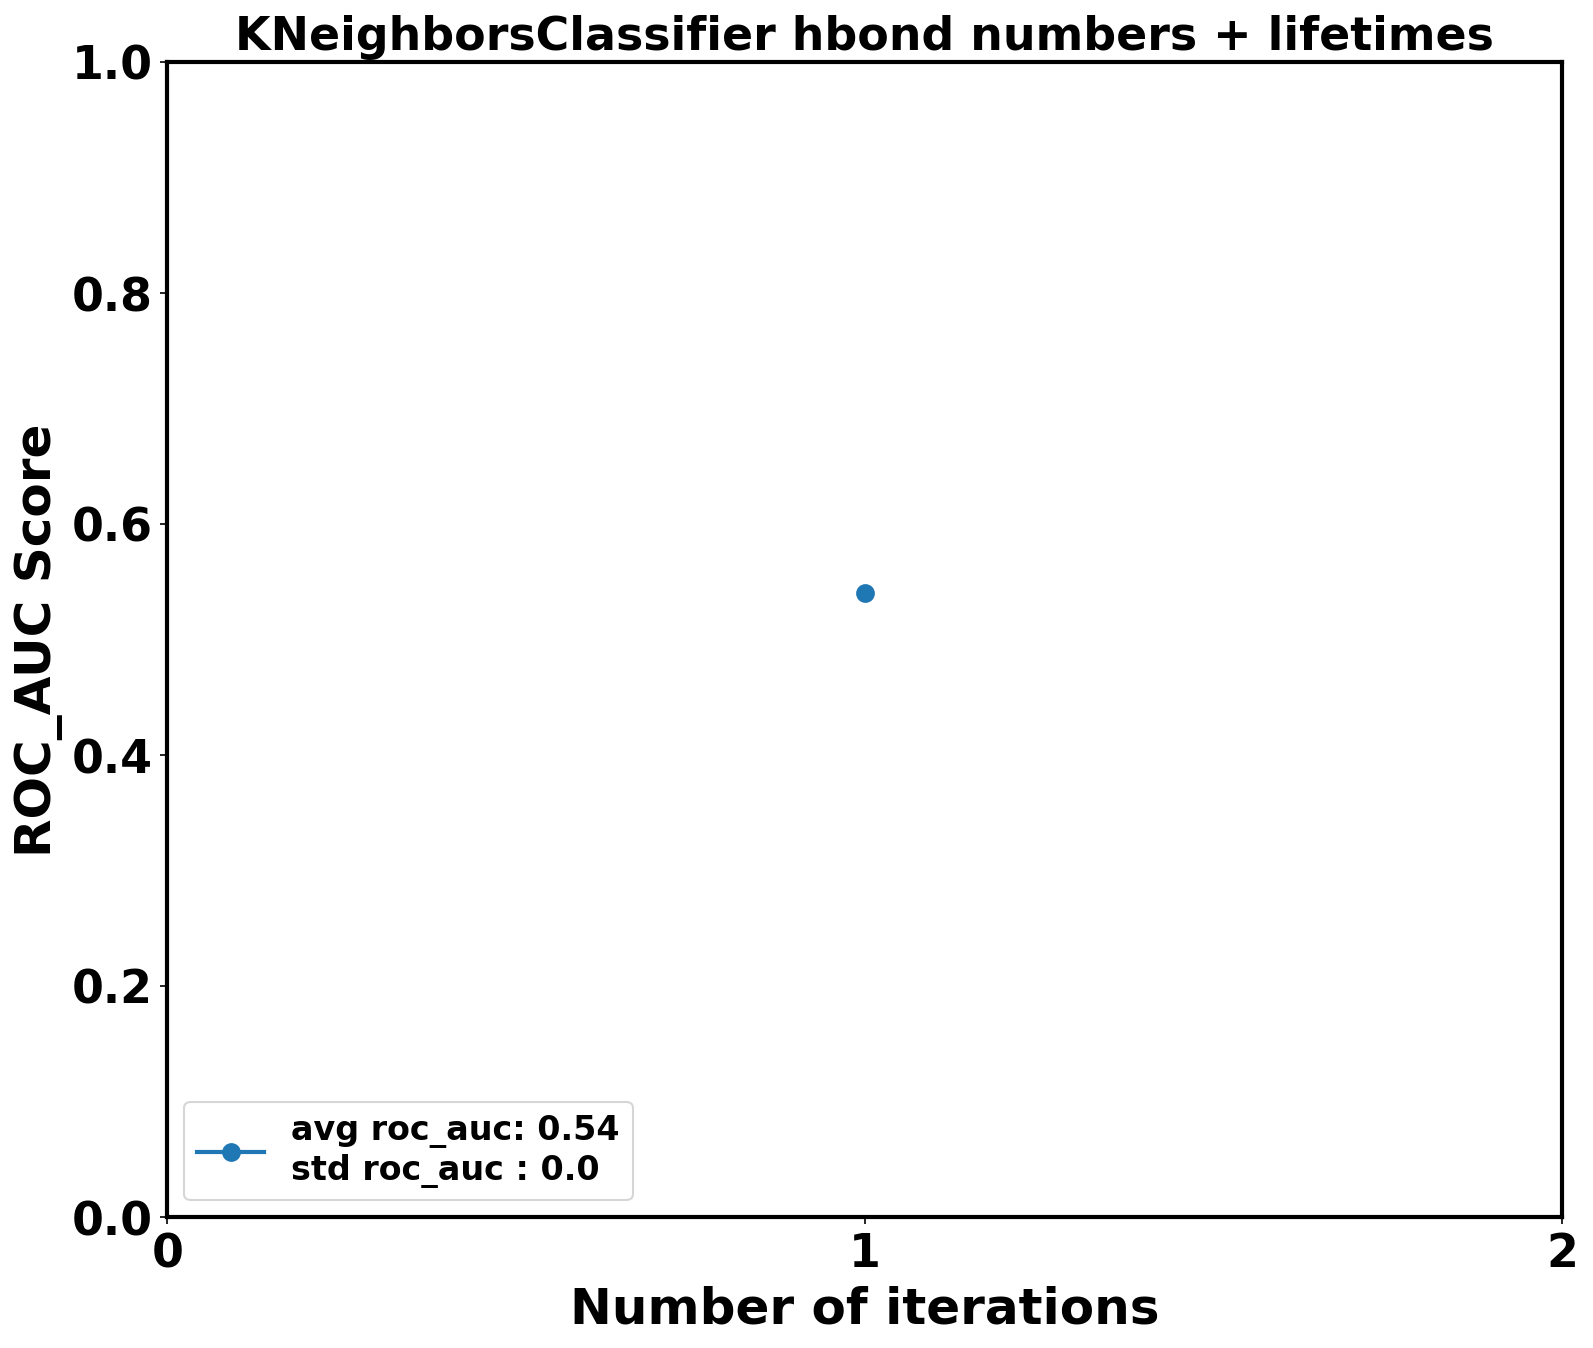

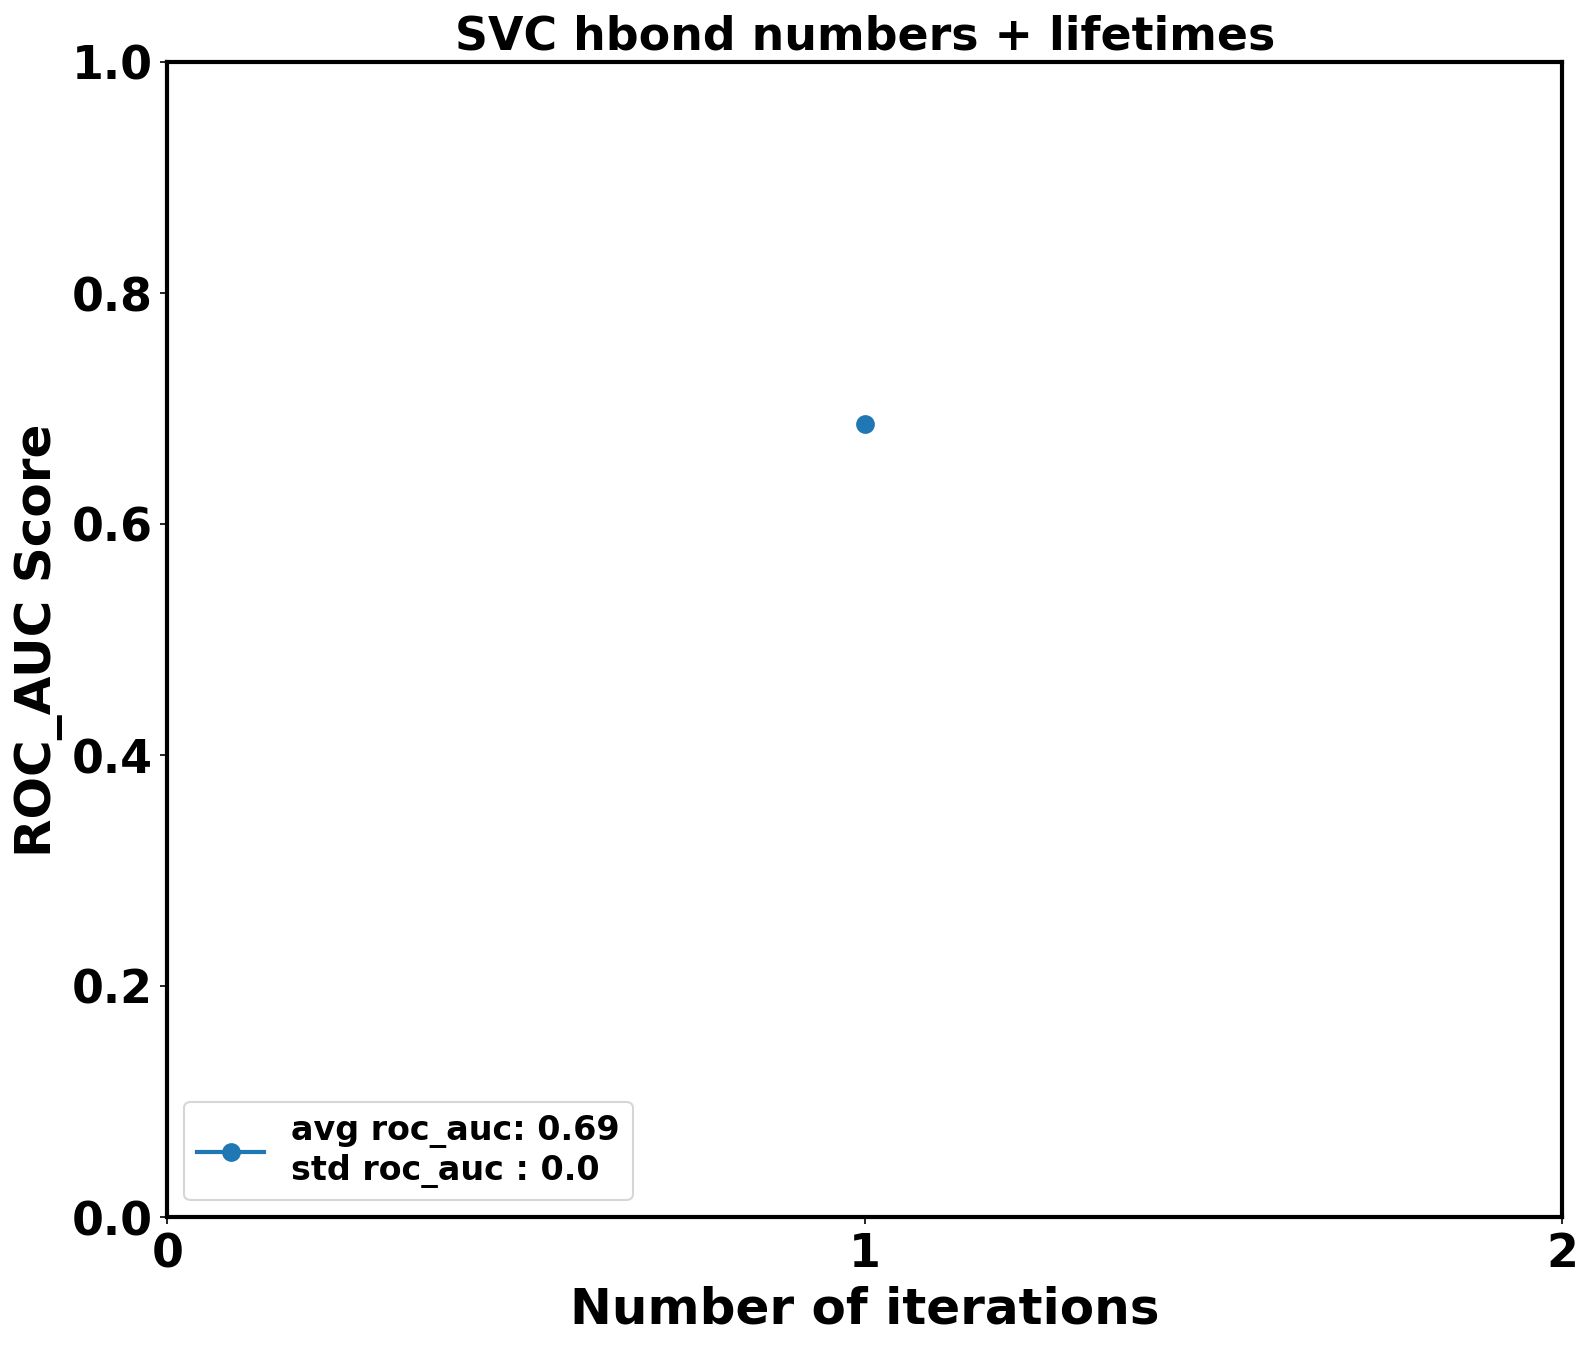

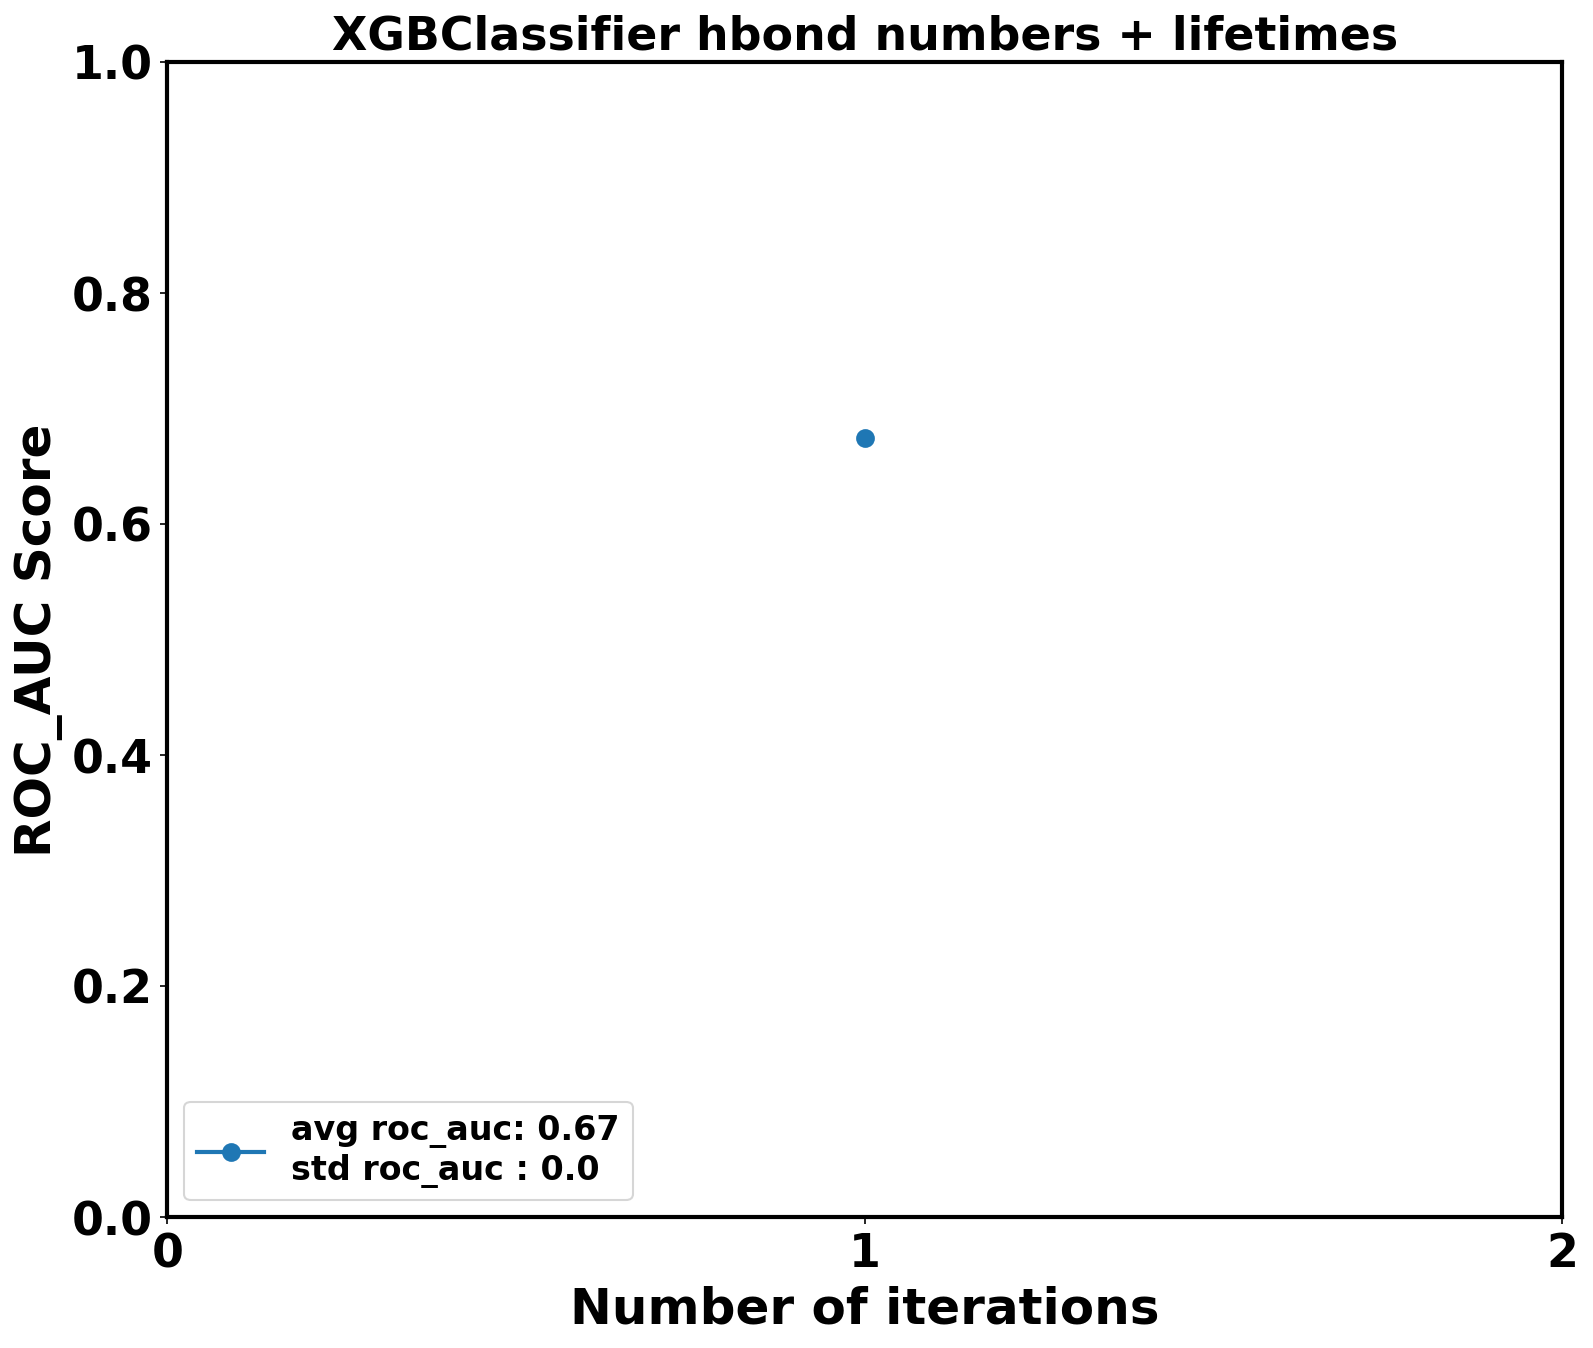

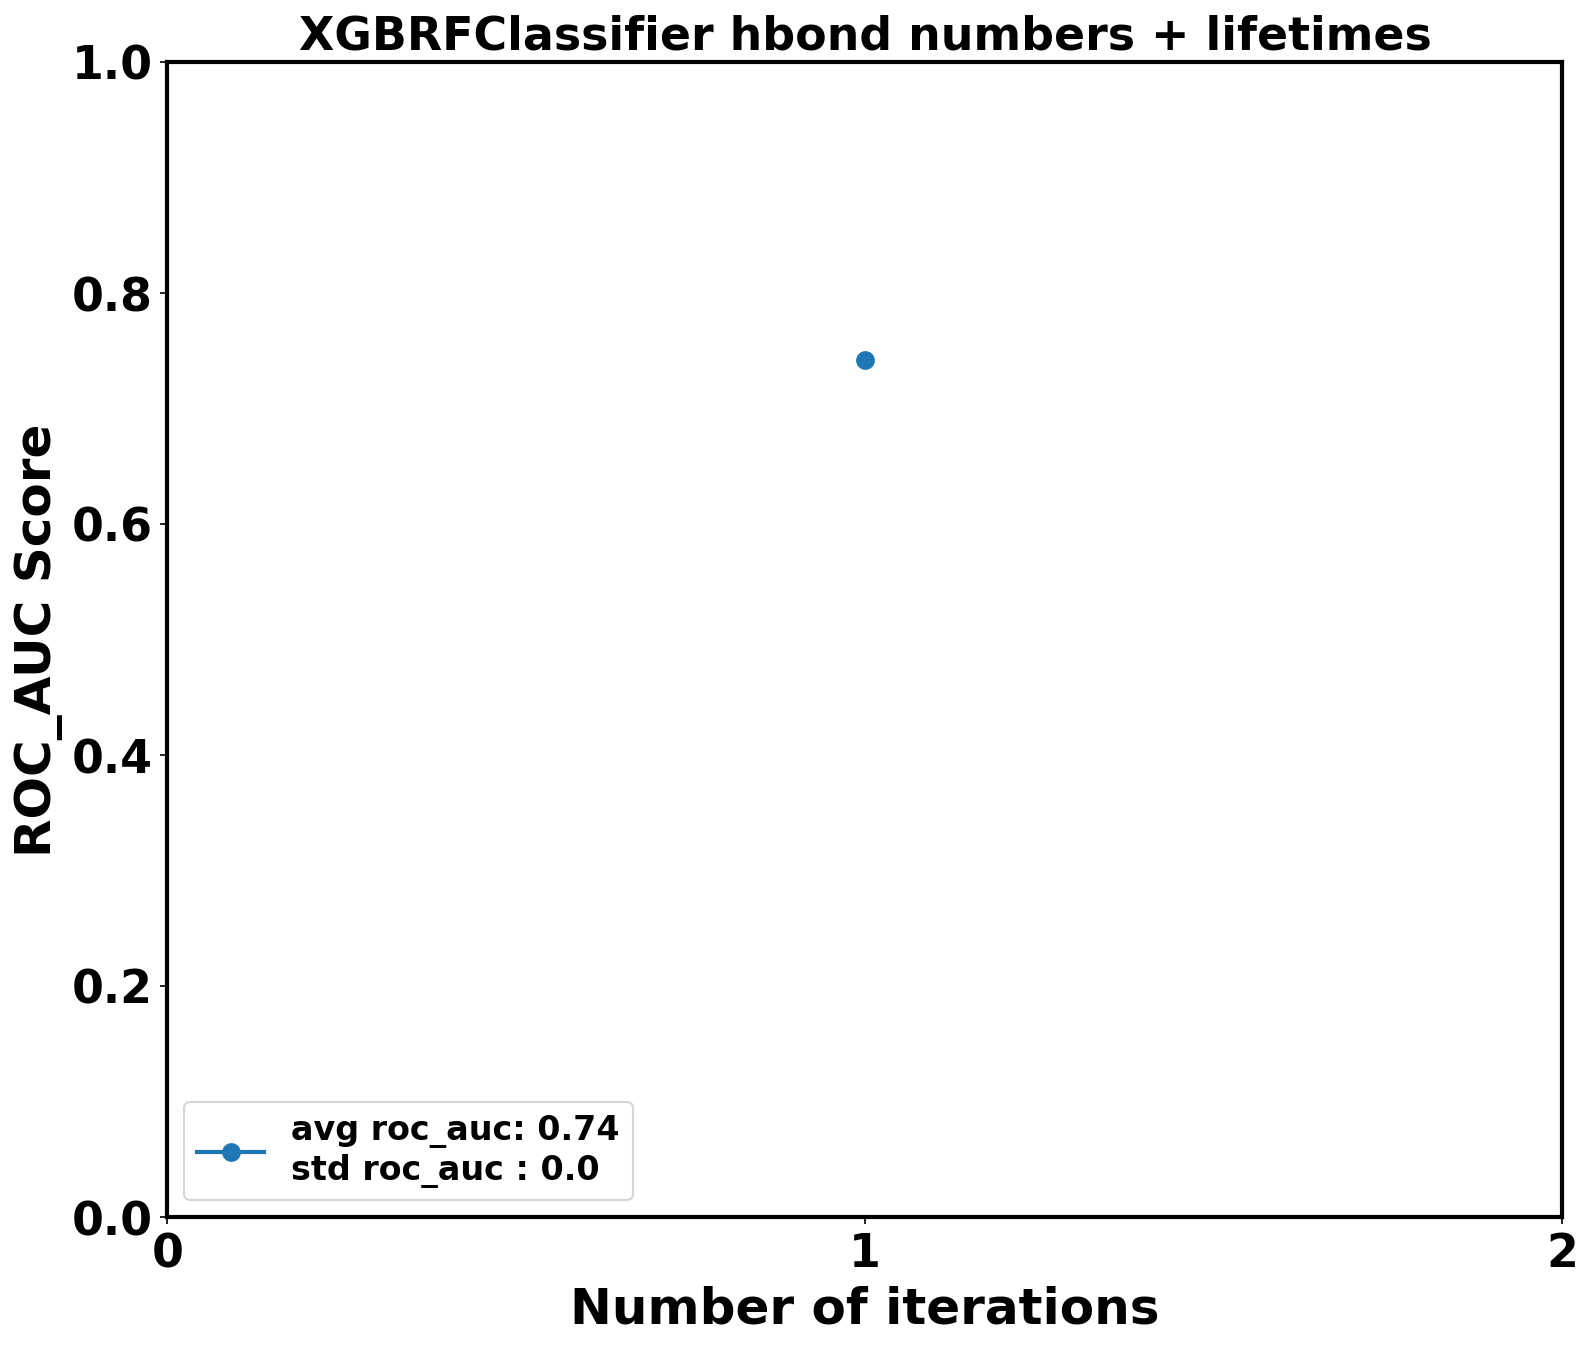

In [136]:
# Validation with lignin

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    'font.size': 18,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
})

xdate = datetime.datetime.now().strftime("%m-%d-%Y")
rand_seed = 100
n_repeat = 1
folder_type='merged'
folder_types = ['hlife', 'hnum', 'merged']
tag = "LR"

models = {
    "RF": "RandomForestClassifier",
    "EF": "ExtraTreesClassifier",
    "GB": "GradientBoostingClassifier",
    "AB": "AdaBoostClassifier",
    "DT": "DecisionTreeClassifier",
    "LR": "LogisticRegression",
    "KNN": "KNeighborsClassifier",
    "SVC": "SVC",
    "XGB": "XGBClassifier",
    "XGBRF": "XGBRFClassifier"

}


for model_tag in models.keys():
    model = models[model_tag]
    model_type = load(f'./saved-models/{folder_type}/{model}_{folder_type}.joblib')
    model_name = model_type.__str__().split('(')[0]
    # print(f"{tag} training for {n_repeat} runs")

    dirmaker(f'./model-logs/validation/{folder_type}/{xdate}')
    file_name = open(f"./model-logs/validation/{folder_type}/{xdate}/{model_name}_{lig}_{folder_type}_{n_repeat}_{xdate}_{rand_seed}.txt", "w+")     

    X, Y = data_validate(des_df_merged, nondes_df_merged)   
    validate_trained_models(model_type, X, Y,file_name=file_name, folder_type=folder_type, num=n_repeat, rand_seed=rand_seed)

## Boxplots

In [122]:
des_hlife_sum = des_df_hlife.describe()
des_hnum_sum = des_df_hnum.describe()
nondes_hlife_sum = nondes_df_hlife.describe()
nondes_hnum_sum = nondes_df_hnum.describe()

In [141]:
des_hlife_sum
# des_hnum_sum
# nondes_hlife_sum
# nondes_hnum_sum

,A-A,B-B,A-B,A-A/B-B,A-B/(A-A + B-B),output
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.0
mean,2.142763,1.160553,2.143439,2.322637,0.642668,1.0
std,1.122938,0.842266,1.168480,1.502644,0.183063,0.0
min,0.232701,0.206614,0.256956,0.661939,0.376253,1.0
25%,1.274320,0.512612,1.067480,1.196781,0.515790,1.0
50%,2.469649,0.963793,2.158384,1.945579,0.585537,1.0
75%,2.747975,1.752335,3.068056,2.910829,0.730091,1.0
max,3.859475,3.733872,4.013772,7.043183,1.146823,1.0


In [153]:
# # All tags
# taggsss = list(nondes_df_hnum.columns)
# taggsss.remove('output')
# taggsss

# # Excluding the ratios
# taggsss = list(nondes_df_hnum.columns)
# taggsss.remove('output')
# taggsss.remove('A-A/B-B')
# taggsss.remove('A-B/(A-A + B-B)')
# taggsss

# Excluding all but the ratios
taggsss = list(nondes_df_hnum.columns)
taggsss.remove('output')
taggsss.remove('A-A')
taggsss.remove('B-B')
taggsss.remove('A-B')
taggsss

['A-A/B-B', 'A-B/(A-A + B-B)']

In [154]:
def df_boxplot(df, list_of_tags):
    taggss = list_of_tags
    list_baba = []

    for i in range(len(taggss)):
        boxplot_dict = {
            'label' : taggss[i],  # hbond features
            'whislo': df[taggss[i]].loc['min'],    # Bottom whisker position
            'q1'    : df[taggss[i]].loc['25%'],    # First quartile (25th percentile)
            'med'   : df[taggss[i]].loc['50%'],    # Median         (50th percentile)
            'q3'    : df[taggss[i]].loc['75%'],    # Third quartile (75th percentile)
            'whishi': df[taggss[i]].loc['max'],    # Top whisker position
            'fliers': []        # Outliers
        }

        list_baba.append(boxplot_dict)
    
    return list_baba

In [155]:
deshnum_list = df_boxplot(des_hnum_sum, taggsss)
nondeshnum_list = df_boxplot(nondes_hnum_sum, taggsss)
deshlife_list = df_boxplot(des_hlife_sum, taggsss)
nondeshlife_list = df_boxplot(nondes_hlife_sum, taggsss)

In [162]:

def boxplotter(df_list, title_tag, fig_title, data_type='hnum'):
    xdate = datetime.datetime.now().strftime("%m-%d-%Y")

    fig_1, ax_1 = plt.subplots(1,1)
    fig_1.set_size_inches(12,10, forward=True)  

    ax_1.bxp(df_list, showfliers=False, boxprops=dict(linestyle='-', linewidth=3.5),
    flierprops=dict(linestyle='-', linewidth=5.5),
                medianprops=dict(linestyle='-', linewidth=3.5),
                whiskerprops=dict(linestyle='-', linewidth=3.5),
                capprops=dict(linestyle='-', linewidth=3.5))
    
    if data_type=='hnum':
        upper=60
    elif data_type=='hlife':
        upper=40
    else:
        upper=105
        
                        
    ax_1.set_ylim(bottom=0, top=upper)
    title = title_tag
    # ax_1.set_title(f'{title_tag}', weight='bold')
    plt.savefig(f"./plots/boxplots/{fig_title}_validation_ratios_{xdate}", facecolor="white", bbox_inches="tight", dpi=350)
    plt.show()

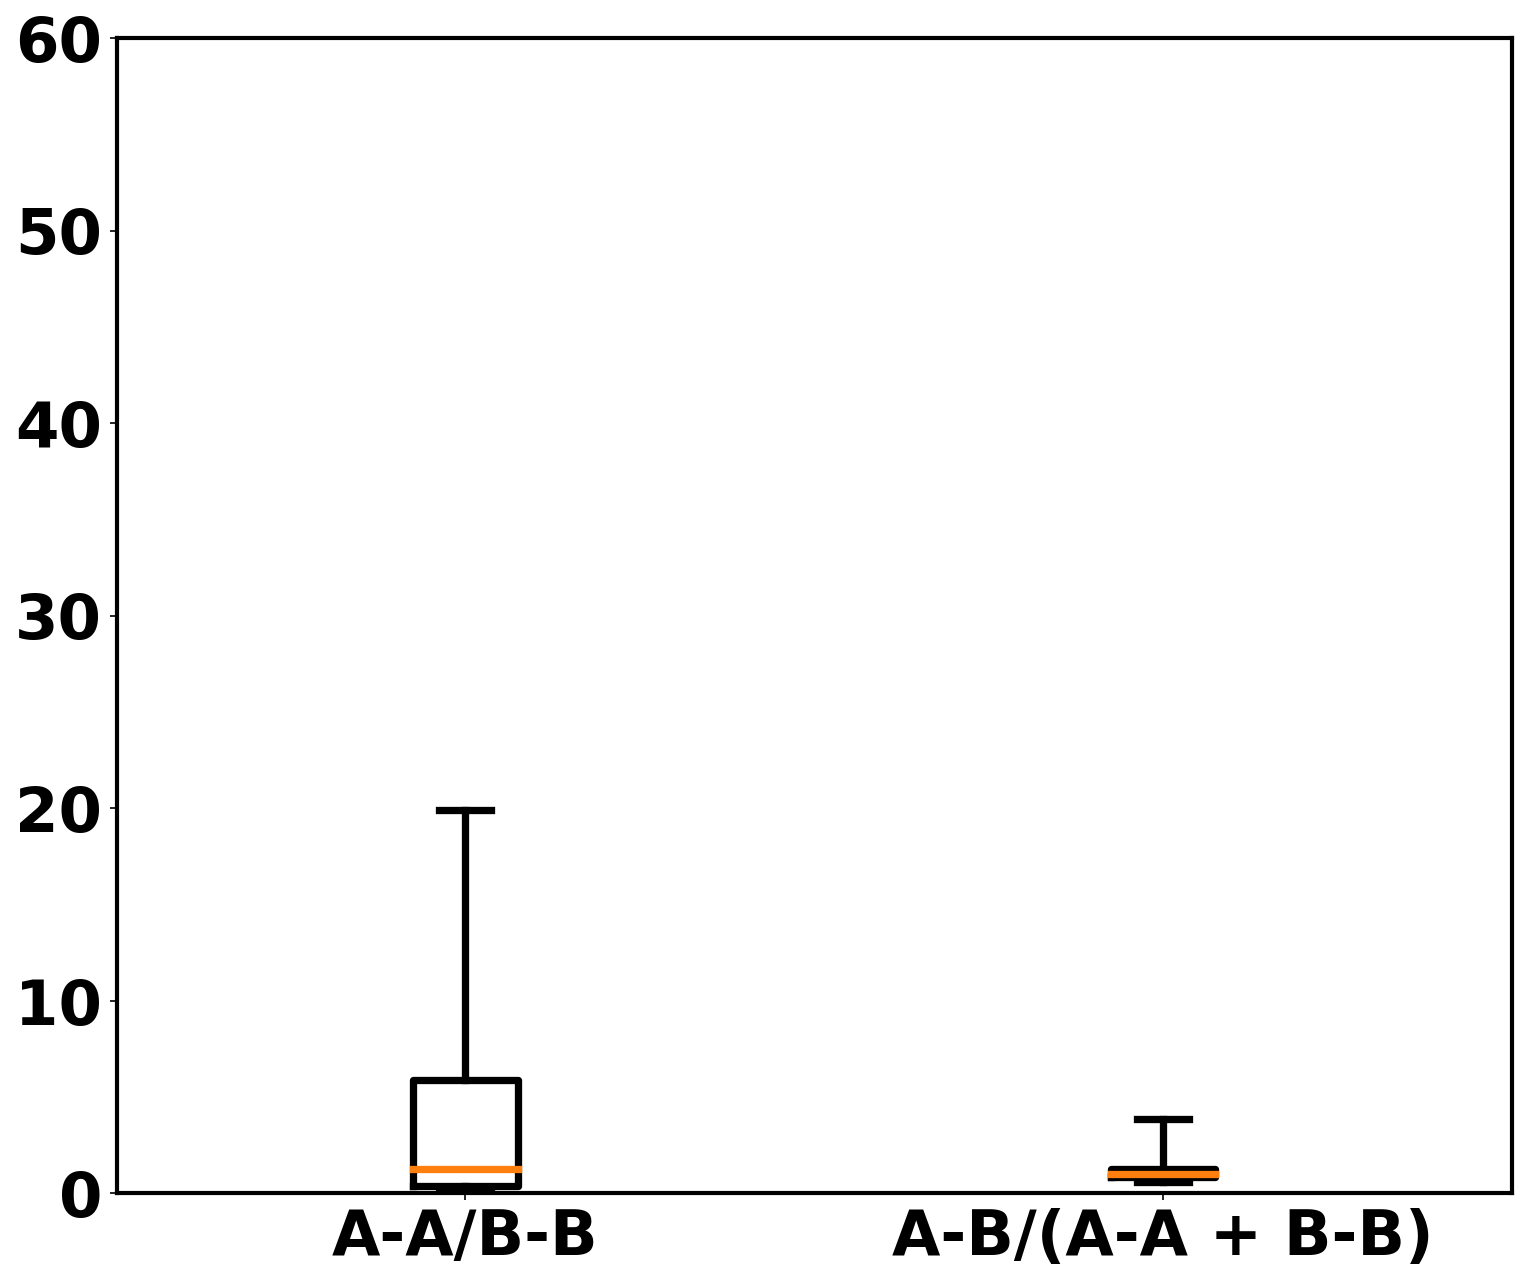

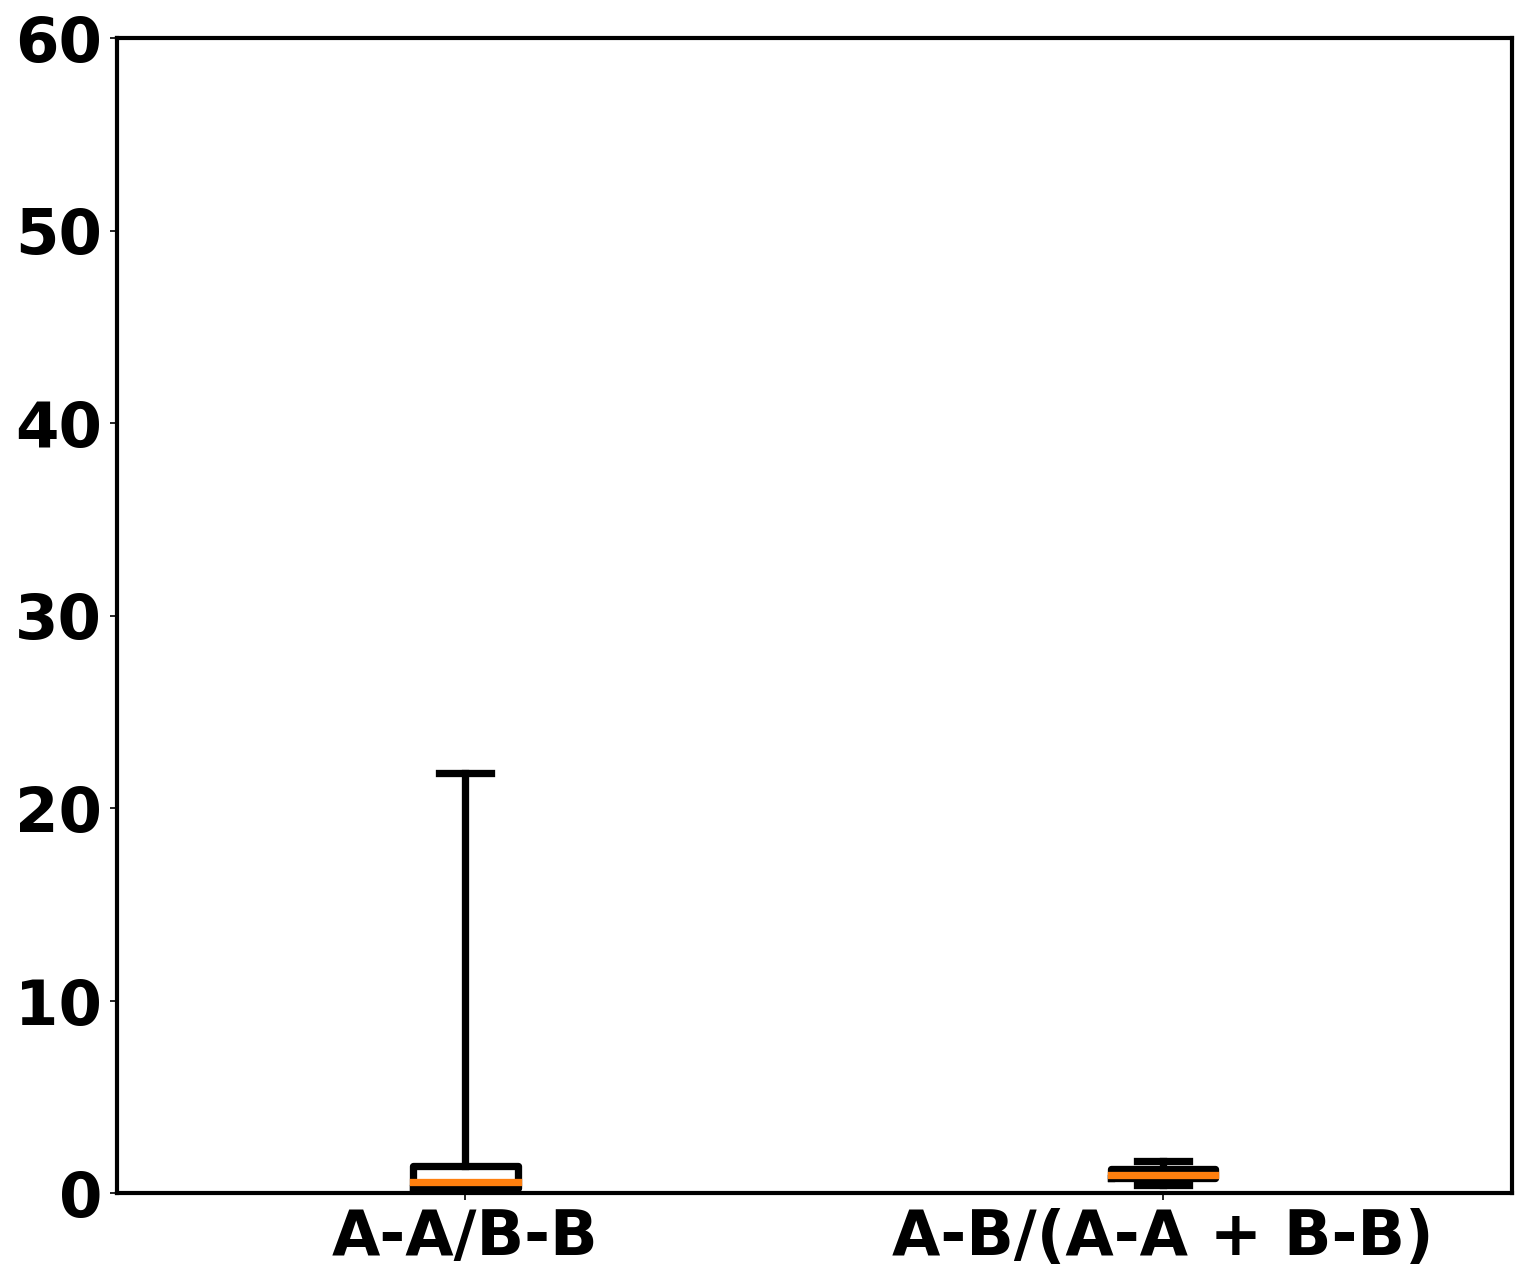

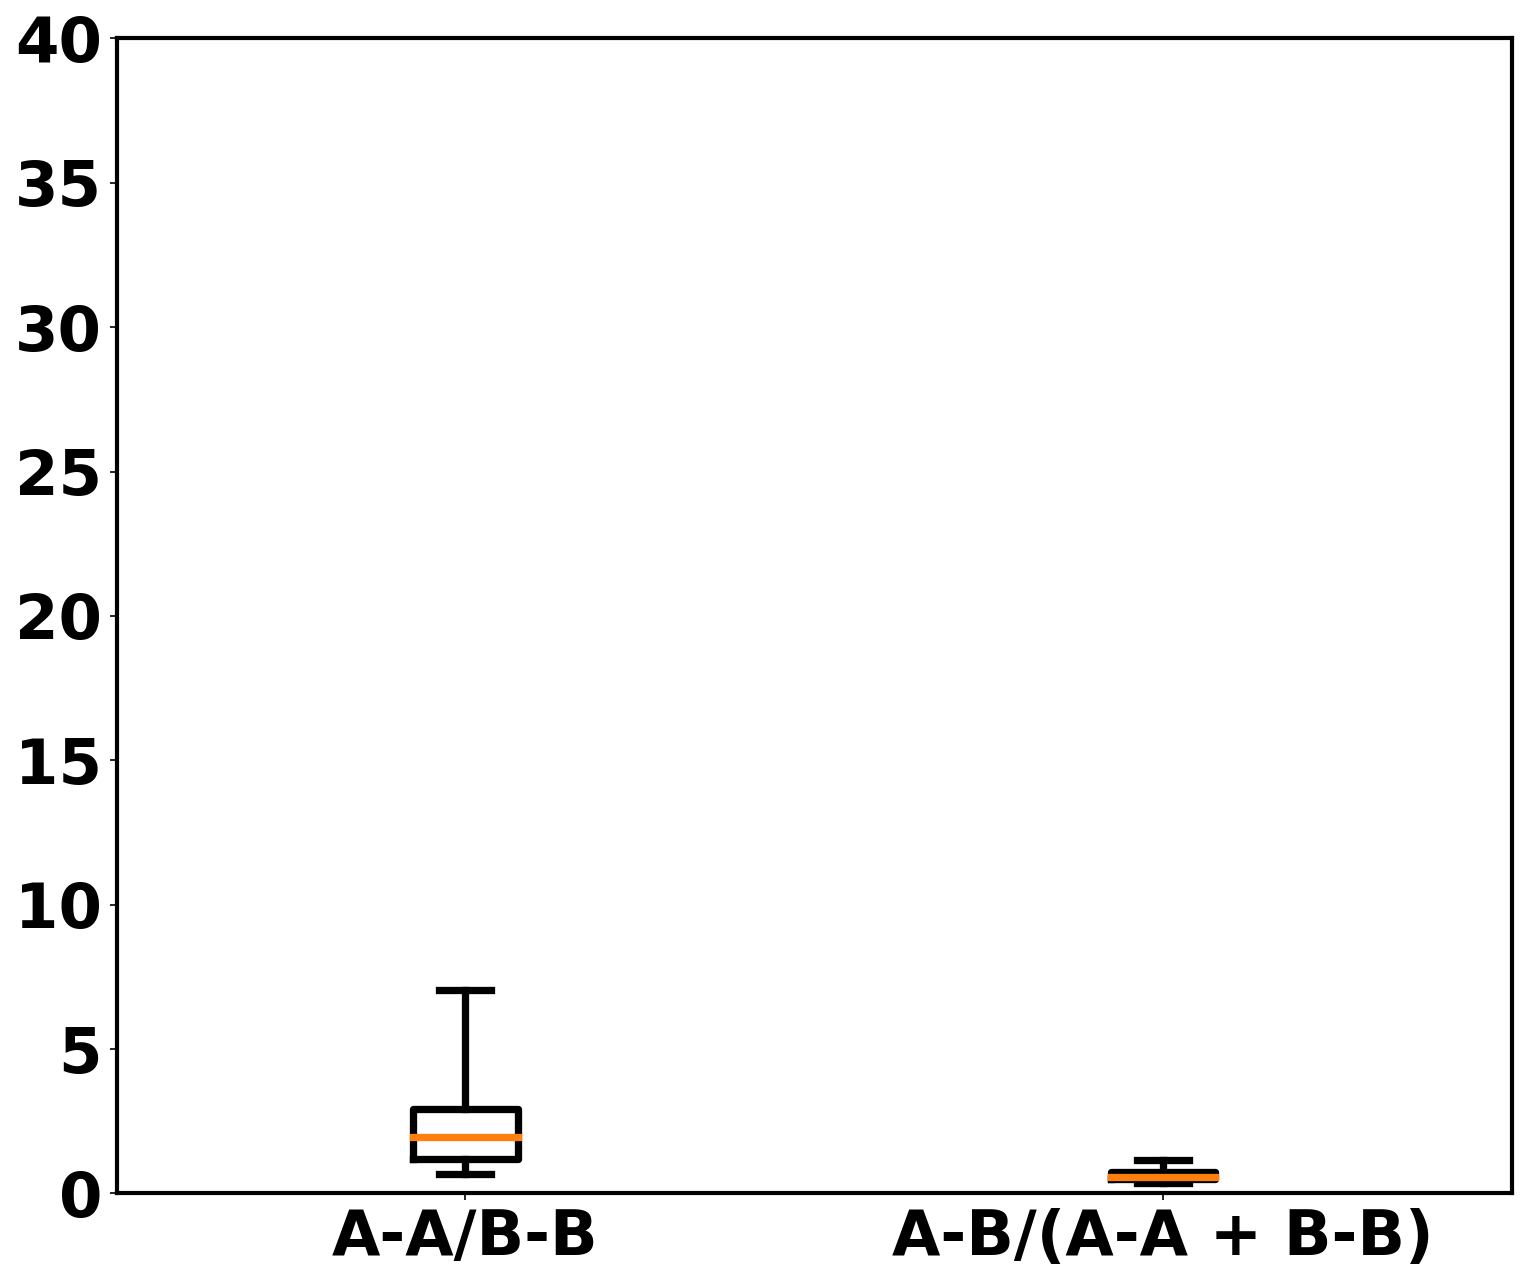

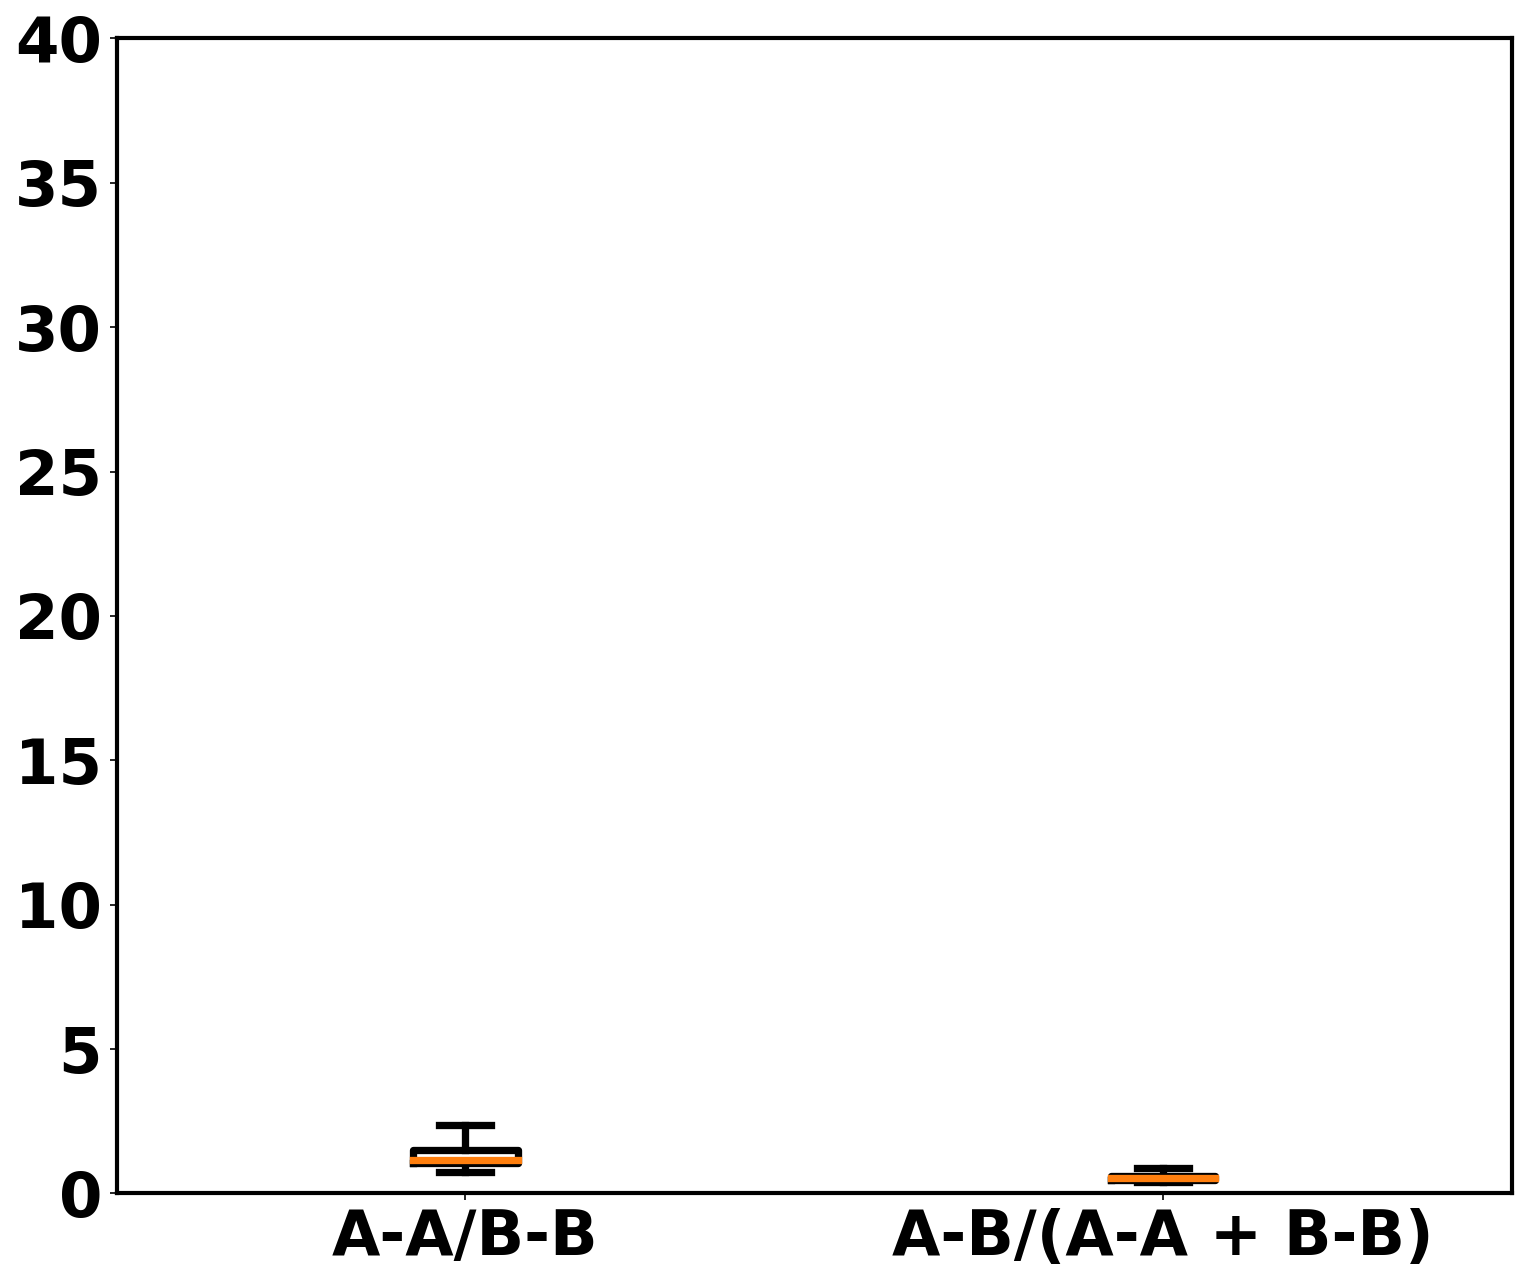

In [163]:
plt.rcParams.update({
    "font.weight": "bold",
    "xtick.labelsize": 30,
    "ytick.labelsize": 30,
    'font.size': 34,
    'axes.labelweight': 'bold',
    'figure.dpi': 150.0,
    'axes.linewidth':2.0,
})

titles = {
        'des_hnum':'DES hydrogen bond numbers per molecule',
        'nondes_hnum':'non-DES hydrogen bond numbers per molecule',
        'des_hlife':'DES hydrogen bond lifetimes per molecule',
        'nondes_hlife':'non-DES hydrogen bond lifetimes per molecule',
    }

df_lists = {
        'des_hnum':deshnum_list,
        'nondes_hnum':nondeshnum_list,
        'des_hlife':deshlife_list,
        'nondes_hlife':nondeshlife_list,
    }

for key in df_lists.keys():
    titletag = key
    dtype = titletag.split('_')[1]
    boxplotter(df_lists[titletag], titles[titletag], titletag, data_type=dtype)

## Confusion Matrices visualization

#### hnum

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}
plt.rc('font', **font)

models = {
    'KNN': knn_class_hnum,
    'SVC': sv_class_hnum,
    'LR': reg_log_hnum,
    'DT': dt_class_hnum,
    'RF': rf_class_hnum,
    'XG': xg_boost_hnum,
}

class_names = target_names

for name, model in models.items():
    titles_options = [
        (f"{name} confusion matrix (not normalized)_hnum", None),
        (f"{name} confusion matrix (normalized)_hnum", "true"), ]

    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test_hnum,
            y_test_hnum,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )

        disp.figure_.set_size_inches(14, 10)
        disp.ax_.set_title(title, fontsize=30, weight='bold')
        disp.ax_.set_xlabel("Predicted label", fontsize=24, weight='bold')
        disp.ax_.set_ylabel("True label", fontsize=24, weight='bold')

        print(title)
        print(disp.confusion_matrix)
        plt.savefig(
            f"./plots/classifiers/{title}.png", dpi=400, facecolor='white')

    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

font = {'family': 'normal',
        'weight': 'bold',
        'size': 22}
plt.rc('font', **font)

models = {
    'KNN': knn_class_hlife,
    'SVC': sv_class_hlife,
    'LR': reg_log_hlife,
    'DT': dt_class_hlife,
    'RF': rf_class_hlife,
    'XG': xg_boost_hlife,
}

class_names = target_names

for name, model in models.items():
    titles_options = [
        (f"{name} confusion matrix (not normalized)_hlife", None),
        (f"{name} confusion matrix (normalized)_hlife", "true"), ]

    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test_hlife,
            y_test_hlife,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )

        disp.figure_.set_size_inches(14, 10)
        disp.ax_.set_title(title, fontsize=30, weight='bold')
        disp.ax_.set_xlabel("Predicted label", fontsize=24, weight='bold')
        disp.ax_.set_ylabel("True label", fontsize=24, weight='bold')

        print(title)
        print(disp.confusion_matrix)
        plt.savefig(
            f"./plots/classifiers/{title}.png", dpi=400, facecolor='white')

    plt.show()


In [ ]:
models = {
    'KNN': knn_class_hnum,
    'SVC': sv_class_hnum,
    'LR': reg_log_hnum,
    'DT': dt_class_hnum,
    'RF': rf_class_hnum,
    'XG': xg_boost_hnum,
}
for name, model in models.items():
    print(name, model)


## Experiment Zone